In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

%matplotlib inline
from B00_util import *
%reload_ext autoreload
%autoreload 2

# Get data for ML4A and ML4B

In [2]:
dataset = extractDataset("B00_ML4TrgPos_Y2016", {  "AllMed",  "HF","NonVAMed", "DispensedDrug","Only10daysPrior30DaysAfter"})

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_01_04_cohort,BASE TABLE
1,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_05_04_Rad,BASE TABLE
2,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_04_04_Lab,BASE TABLE
3,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_04_RxOutpat,BASE TABLE
4,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_07_NonVAMed,BASE TABLE
5,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_05_BCMA_Dispense...,BASE TABLE
6,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_08_AllMed,BASE TABLE
7,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_08_Consult,BASE TABLE
8,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_12_ICD,BASE TABLE
9,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_14_Vital,BASE TABLE


dict_keys(['cohort', 'Rad', 'Lab', 'RxOutpat', 'Consult', 'ICD', 'Vital', 'withRole', 'Demorgraphics', 'Hosp'])


# Process cohort tables

In [3]:
cohorts = dataset['cohort']
print(cohorts[cohorts.TriggerType=='Dizziness'].shape, cohorts[cohorts.TriggerType=='AbdominalPain'].shape)

(197, 12) (911, 12)


In [ ]:
dizzy_cohort = cohorts[cohorts.TriggerType=='Dizziness'].copy()

# create a clean cohort table with merged hospitalizations
# get the patient trajectories with ER visits and hospitalizations

def make_cohort_df(cohort):
    # standardize PtSSN
    dizzy_cohort.rename(columns={'patientSSN':'PtSSN'},inplace=True)
    dizzy_cohort.PtSSN = dizzy_cohort.PtSSN.astype('int64')

    allrecs = pd.DataFrame()
    merged_pts = []

    for PtSSN in dizzy_cohort.PtSSN.unique():
        # get records for a patient
        recs = dizzy_cohort[dizzy_cohort.PtSSN==PtSSN].copy()
        num_EDs = dizzy_cohort[dizzy_cohort.PtSSN==PtSSN]['EDStartDateTime'].unique().shape[0]
        recs['num_ED_visits'] = num_EDs
        num_hosp = dizzy_cohort[dizzy_cohort.PtSSN==PtSSN]['AdmitDateTime'].unique().shape[0]
        recs['num_hosp'] = num_hosp
    
        # if more than 1 visit for a patient, check for opportunities to merge
        if recs.shape[0] > 1:
            recs['diffEE'] = (recs['EDStartDateTime'] - recs['EDStartDateTime'].shift(1))/np.timedelta64(1,'h')
            # remove records where the time difference between successive EDs is > 1 year
            if recs['diffEE'].values[-1] > 365*24:
                print('drop last record for patient ',PtSSN)
                recs = recs[:-1]
                recs['num_ED_visits'] = recs['num_ED_visits'] - 1
                recs['num_hosp'] = recs['num_hosp'] - 1
    
        # does patient have a single ED visit with more than 1 hospitalization?
        # if yes, check for opportunities to merge hospitalizations that are within 2 hours
        if (num_EDs == 1) & (num_hosp > 1):
            recs['diffHH'] = (recs['AdmitDateTime'] - recs['DischargeDateTime'].shift(1))/np.timedelta64(1,'h')
            to_merge = recs[recs['diffHH']<2].copy()
            if to_merge.shape[0] > 0:
                #merge two hospitalizations within 2 hours of each other
                to_merge['AdmitDateTime'] = recs.iloc[:-1]['AdmitDateTime'].values[0]
                recs = to_merge
                recs['num_hosp'] = recs['num_hosp'] - 1
                merged_pts.append(PtSSN)
         
        allrecs = pd.concat([allrecs,recs]) 
        
    # now add ed_duration, hosp_stay and ed_first_inp_delta to the cleaned records
    allrecs['ed_duration'] = (allrecs.EDEndDateTime - allrecs.EDStartDateTime)/np.timedelta64(1,'h')
    tmp = allrecs.groupby(['PtSSN'])[['ed_duration']].agg(['sum'])
    tmp.columns = [x[0] + '_' + x[1] for x in tmp.columns.to_flat_index()]
    allrecs = pd.merge(allrecs,tmp,on='PtSSN')
    
    
    allrecs['hosp_stay'] = (allrecs.DischargeDateTime - allrecs.AdmitDateTime)/np.timedelta64(1,'D')
    tmp = allrecs.groupby(['PtSSN','EDStartDateTime'])[['hosp_stay']].agg(['sum'])
    tmp.columns = [x[0] + '_' + x[1] for x in tmp.columns.to_flat_index()]
    allrecs = pd.merge(allrecs,tmp,on=['PtSSN','EDStartDateTime'])
    
    tmp = allrecs.groupby(['PtSSN'])[['AdmitDateTime']].agg('min')
    tmp.rename(columns={'AdmitDateTime':'FirstAdmission'},inplace=True)
    tmp = tmp.reset_index()
    allrecs = pd.merge(allrecs,tmp,on=['PtSSN'])
    allrecs['ed_first_inp_delta'] = (allrecs.FirstAdmission - allrecs.EDEndDateTime)/(np.timedelta64(1,'D'))
    
    # take the min of the ed_first_inp_delta for patients with multiple ED visits
    tmp = allrecs.groupby(['PtSSN'])[['ed_first_inp_delta']].agg(['min'])
    tmp.columns = [x[0] + '_'+x[1] for x in tmp.columns.to_flat_index()]
    allrecs = pd.merge(allrecs,tmp,on='PtSSN')
   
    return allrecs

clean_dizzy_cohort = make_cohort_df(dizzy_cohort)

In [5]:
cohort_columns =  ['PtSSN', 'EDStartDateTime', 'EDEndDateTime','EDVisitReason', 'AdmitDateTime', 
                   'DischargeDateTime','num_ED_visits','num_hosp','ed_duration','ed_duration_sum',
                   'hosp_stay','hosp_stay_sum','ed_first_inp_delta'
                   ]
cohort_columns_1pp = ['PtSSN', 'num_ED_visits','num_hosp','ed_duration_sum', 'hosp_stay_sum','ed_first_inp_delta_min']

print(clean_dizzy_cohort[cohort_columns].shape)
clean_dizzy_cohort_1pp = clean_dizzy_cohort[cohort_columns_1pp].drop_duplicates()
print(clean_dizzy_cohort_1pp.shape)
len(clean_dizzy_cohort_1pp.PtSSN.unique())

(184, 13)
(172, 6)


172

In [6]:
# null analysis
clean_dizzy_cohort_1pp.isnull().sum()

PtSSN                     0
num_ED_visits             0
num_hosp                  0
ed_duration_sum           0
hosp_stay_sum             0
ed_first_inp_delta_min    0
dtype: int64

In [7]:
# check if all pts are in the labeled data
dizzy_df, dizzy_labels_df = retrieveLabels_dizzy(dizzy_fname)
set(dizzy_labels_df.PtSSN).difference(set(dizzy_cohort.PtSSN))

set()

# Demographic data

In [8]:
demog = dataset['Demorgraphics']

def make_clean_demo(demog,clean_cohort):
    # drop demog records that have null DOB values
    demog = demog.dropna(subset=['DOB']).copy()

    # standardize PtSSN field
    demog.rename(columns={'patientSSN':'PtSSN'},inplace=True)
    demog.PtSSN = demog.PtSSN.astype('int64')

    # pull out the relevant records
    clean_demo = demog[demog.PtSSN.isin(clean_cohort['PtSSN'])].copy()


    clean_demo = make_demo_df(clean_demo)
    clean_demo_coded = code_demodf(clean_demo)
    return clean_demo_coded

dizzy_demo_coded = make_clean_demo(demog, clean_dizzy_cohort)
print(dizzy_demo_coded.shape)

dizzy_demo_coded.isnull().sum()

(172, 9)


PtSSN                                 0
age_at_index_visit                    0
new_race_ALASKA/PACIFIC               0
new_race_ASIAN                        0
new_race_BLACK OR AFRICAN AMERICAN    0
new_race_UNKNOWN                      0
new_race_WHITE                        0
Gender                                0
Ethnicity                             0
dtype: int64

#  ED vitals
- vitals during ED visit
    - systolic, diastolic (count, min, max, first for multiple readings)
    - pulse, respiration, pulse oximetry, pain, temperature (count, min, max, first for multiple readings) 

In [9]:
vitals = dataset['Vital']

def add_EDvital_column(vitals,vital_col,colname):
    tmp = vitals.groupby(['PtSSN'])[[vital_col]].agg(['count','max','min','first'])
    tmp = tmp.reset_index()
    tmp.columns = [colname + '_'+x[1] if x[1]!= '' else x[0] for x in tmp.columns.to_flat_index()]
    
    return tmp

def make_EDvitals_df(EDvitals_df,cohort_df):
    systolic = add_EDvital_column(EDvitals_df,'Systolic','Systolic')
    # fill out missing values
    systolic = pd.merge(cohort_df[['PtSSN']],systolic,how='left')
    systolic['Systolic_count'].fillna(0,inplace=True)
    
    diastolic = add_EDvital_column(EDvitals_df,'Diastolic','Diastolic')
    diastolic = pd.merge(cohort_df[['PtSSN']],diastolic,how='left')
    diastolic['Diastolic_count'].fillna(0,inplace=True)
    
    vdf = pd.merge(systolic,diastolic,on=['PtSSN'])

    vital_types = ['PULSE','RESPIRATION','PAIN','TEMPERATURE']
    for vital_type in vital_types:
        subset_EDvitals = EDvitals_df[EDvitals_df.VitalType==vital_type]
        tmp_df = add_EDvital_column(subset_EDvitals,'VitalResultNumeric',vital_type)
        tmp_df = pd.merge(cohort_df[['PtSSN']],tmp_df,how='left')
        tmp_df[vital_type+'_count'].fillna(0,inplace=True)
        vdf = pd.merge(vdf,tmp_df,on=['PtSSN'])
        vdf.drop_duplicates(inplace=True)
    return vdf

def make_clean_EDvitals(vitals,clean_cohort):
    # standardize PtSSN
    vitals.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
    vitals.PtSSN = vitals.PtSSN.astype('int64')
    
    # extract relevant records for every patient for all ED visits (start and end times)   
    cohort_vitals = pd.merge(vitals,clean_cohort[['PtSSN','EDStartDateTime','EDEndDateTime']],on='PtSSN')
    cohort_vitals = cohort_vitals[(cohort_vitals.VitalSignTakenDateTime >= cohort_vitals.EDStartDateTime) & 
                       (cohort_vitals.VitalSignTakenDateTime <= cohort_vitals.EDEndDateTime)].copy()

    cohort_EDvitals = make_EDvitals_df(cohort_vitals,clean_cohort)
    return cohort_EDvitals 

dizzy_EDvitals = make_clean_EDvitals(vitals,clean_dizzy_cohort)
dizzy_EDvitals.shape

(172, 25)

In [56]:
# drop cols with more than thresh% NA
def check_nas(df,thresh):
    drop_cols = []
    for col in df.columns:
        pct_na = df[col].isna().sum()/df.shape[0] * 100
        if pct_na > thresh:
            #print(col,pct_na)
            drop_cols = drop_cols + [col]
    return drop_cols

def clean_lab_df(merged_df,cols,thresh):
    drop_labs = check_nas(merged_df,thresh)
    #print('Lab cols to drop:',drop_labs)
    lab_retain = [x for x in cols if x not in drop_labs]
    return merged_df[['PtSSN'] + lab_retain]

def clean_and_impute(merged_df,cols,thresh):
    # throw out columns with more than thresh% missing values
    clean_df = clean_lab_df(merged_df,merged_df.columns[1:],thresh)

    # find the rows with null values
    null_rows = clean_df[pd.isnull(clean_df).any(axis=1)]
    imp = IterativeImputer(max_iter = 100, random_state = 0)
    imp.fit(clean_df.iloc[:,1:])

    fitted_null_rows = pd.DataFrame(imp.transform(null_rows.iloc[:,1:]),columns=clean_df.columns[1:])
    print(fitted_null_rows.shape, null_rows['PtSSN'].shape)

    complete_null_rows = pd.concat([null_rows[['PtSSN']].reset_index(drop=True),fitted_null_rows],axis=1)
    print(complete_null_rows.shape, clean_df.dropna().shape)
    imp_dizzy_df = pd.concat([clean_df.dropna(),complete_null_rows],axis=0)
    return imp_dizzy_df


In [11]:
# clean dizzy_EDvitals removing columns with more than 10% nulls
clean_dizzy_EDvitals = clean_lab_df(dizzy_EDvitals,dizzy_EDvitals.columns[1:],10)
clean_dizzy_EDvitals.shape

(172, 22)

In [16]:
imp_dizzy_EDvitals = clean_and_impute(dizzy_EDvitals,dizzy_EDvitals.columns[1:],10)
imp_dizzy_EDvitals.shape

(16, 21) (16,)
(16, 22) (156, 22)


(172, 22)

In [12]:
clean_dizzy_EDvitals.isnull().sum()

PtSSN                 0
Systolic_count        0
Systolic_max         10
Systolic_min         10
Systolic_first       10
Diastolic_count       0
Diastolic_max        10
Diastolic_min        10
Diastolic_first      10
PULSE_count           0
PULSE_max            10
PULSE_min            10
PULSE_first          10
RESPIRATION_count     0
RESPIRATION_max      11
RESPIRATION_min      11
RESPIRATION_first    11
PAIN_count            0
TEMPERATURE_count     0
TEMPERATURE_max      16
TEMPERATURE_min      16
TEMPERATURE_first    16
dtype: int64

# Vitals during the hospitalizations subsequent to ED visits

In [13]:
def add_hosp_vital_column(vitals,vital_col,colname):
    tmp = vitals.groupby(['PtSSN'])[[vital_col]].agg(['count','max','min','first'])
    tmp = tmp.reset_index()
    tmp.columns = ['HOSP_'+ colname + '_'+x[1] if x[1]!= '' else x[0] for x in tmp.columns.to_flat_index()]
    return tmp

def make_hosp_vitals_df(hosp_vitals_df,cohort_df):
    systolic = add_hosp_vital_column(hosp_vitals_df,'Systolic','Systolic')
    systolic = pd.merge(cohort_df[['PtSSN']],systolic,how='left')
    systolic['HOSP_Systolic_count'].fillna(0,inplace=True)
    diastolic = add_hosp_vital_column(hosp_vitals_df,'Diastolic','Diastolic')
    diastolic = pd.merge(cohort_df[['PtSSN']],diastolic,how='left')
    diastolic['HOSP_Diastolic_count'].fillna(0,inplace=True)
    
    vdf = pd.merge(systolic,diastolic,on=['PtSSN'])
    

    vital_types = ['PULSE','RESPIRATION','PAIN','TEMPERATURE']
    for vital_type in vital_types:
        subset_hosp_vitals = hosp_vitals_df[hosp_vitals_df.VitalType==vital_type]
        tmp_df = add_hosp_vital_column(subset_hosp_vitals,'VitalResultNumeric',vital_type)
        tmp_df = pd.merge(cohort_df[['PtSSN']],tmp_df,how='left')
        tmp_df['HOSP_'+vital_type + '_count'].fillna(0,inplace=True)
        vdf = pd.merge(vdf,tmp_df,on=['PtSSN'])
    return vdf.drop_duplicates()

def make_clean_hosp_vitals(vitals,clean_cohort):
    # standardize PtSSN
    vitals.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
    vitals.PtSSN = vitals.PtSSN.astype('int64')
    
    # extract relevant records for every patient for all ED visits (start and end times)   
    cohort_vitals = pd.merge(vitals,clean_cohort[['PtSSN','AdmitDateTime','DischargeDateTime']],on='PtSSN')
    cohort_vitals = cohort_vitals[(cohort_vitals.VitalSignTakenDateTime >= cohort_vitals.AdmitDateTime) & 
                       (cohort_vitals.VitalSignTakenDateTime <= cohort_vitals.DischargeDateTime)].copy()

    cohort_hosp_vitals = make_hosp_vitals_df(cohort_vitals,clean_cohort)
    return cohort_hosp_vitals 

dizzy_hosp_vitals = make_clean_hosp_vitals(vitals,clean_dizzy_cohort)
dizzy_hosp_vitals.shape


(172, 25)

In [14]:
# clean dizzy_hosp_vitals removing columns with more than 5% nulls
clean_dizzy_hosp_vitals = clean_lab_df(dizzy_hosp_vitals,dizzy_hosp_vitals.columns[1:],5)
clean_dizzy_hosp_vitals.shape

(172, 25)

In [15]:
clean_dizzy_hosp_vitals.isnull().sum()

PtSSN                     0
HOSP_Systolic_count       0
HOSP_Systolic_max         6
HOSP_Systolic_min         6
HOSP_Systolic_first       6
HOSP_Diastolic_count      0
HOSP_Diastolic_max        6
HOSP_Diastolic_min        6
HOSP_Diastolic_first      6
HOSP_PULSE_count          0
HOSP_PULSE_max            6
HOSP_PULSE_min            6
HOSP_PULSE_first          6
HOSP_RESPIRATION_count    0
HOSP_RESPIRATION_max      6
HOSP_RESPIRATION_min      6
HOSP_RESPIRATION_first    6
HOSP_PAIN_count           0
HOSP_PAIN_max             6
HOSP_PAIN_min             6
HOSP_PAIN_first           6
HOSP_TEMPERATURE_count    0
HOSP_TEMPERATURE_max      6
HOSP_TEMPERATURE_min      6
HOSP_TEMPERATURE_first    6
dtype: int64

In [21]:
imp_dizzy_hosp_vitals = clean_and_impute(dizzy_hosp_vitals,dizzy_hosp_vitals.columns[1:],5)
imp_dizzy_hosp_vitals.shape

(8, 24) (8,)
(8, 25) (164, 25)


(172, 25)

# Consults ordered during ED visit

    - count up top three consult depts for dizzy


In [16]:
consults = dataset['Consult']

def make_EDconsult_df(consults,cohort_df,N):
    consults.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
    consults.PtSSN = consults.PtSSN.astype('int64')
    
    dconsults = pd.merge(consults,cohort_df[['PtSSN','EDStartDateTime','EDEndDateTime']],on='PtSSN')
    dconsults = dconsults[(dconsults.requestDateTime >= dconsults.EDStartDateTime) &                                 
                       (dconsults.requestDateTime <= dconsults.EDEndDateTime)].copy()
    result = topN_consult_counts(dconsults,cohort_df,N)
    
    return result

def topN_consult_counts(consults,cohort_df,N):
    # look at which departments are being consulted (pick top N)
    consult_codes = consults.groupby('ConStopCodeName')['PtSSN'].agg('count').sort_values(ascending=False).reset_index()
    #print(consult_codes)
    ccodes = consult_codes.iloc[:N].ConStopCodeName

    
    # count up for each patient how many of each of these codes occurs
    # filter dizzy_consults to only include the top three codes
    consults_filtered = consults[consults.ConStopCodeName.isin(ccodes)]
    tmp = consults_filtered.groupby(['PtSSN','ConStopCodeName'])['PatientSID'].agg('count').reset_index().rename(columns={'PatientSID':'consult_count'})
   
    # pivot table and convert ConStopCodeName to another axis
    topNconsult_counts = pd.pivot_table(tmp,index='PtSSN',columns='ConStopCodeName',values='consult_count').fillna(0)
    
    # patients not in consults should be assigned zero counts.
    pts = pd.DataFrame(cohort_df['PtSSN'].unique(),columns=['PtSSN'])
    result = pd.merge(pts,topNconsult_counts,on='PtSSN',how='left').fillna(0).astype(int)
    return result


dizzy_EDconsults = make_EDconsult_df(consults,clean_dizzy_cohort,4)
dizzy_EDconsults.columns = ['PtSSN'] + ['ED_' + x for x in dizzy_EDconsults.columns[1:]]
dizzy_EDconsults.shape

(172, 5)

In [17]:
dizzy_EDconsults.isnull().sum()

PtSSN                     0
ED_CARDIOLOGY             0
ED_EKG                    0
ED_NEUROLOGY              0
ED_TELEPHONE/NEUROLOGY    0
dtype: int64

In [18]:
def make_hosp_consult_df(consults,cohort_df,N):
    consults.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
    consults.PtSSN = consults.PtSSN.astype('int64')
    
    dconsults = pd.merge(consults,cohort_df[['PtSSN','AdmitDateTime','DischargeDateTime']],on='PtSSN')
    dconsults = dconsults[(dconsults.requestDateTime >= dconsults.AdmitDateTime) &                                 
                       (dconsults.requestDateTime <= dconsults.DischargeDateTime)].copy()
    result = topN_hosp_consult_counts(dconsults,cohort_df,N)
    
    return result

def topN_hosp_consult_counts(consults,cohort_df,N):
    # look at which departments are being consulted (pick top N)
    consult_codes = consults.groupby('ConStopCodeName')['PtSSN'].agg('count').sort_values(ascending=False).reset_index()
    #print(consult_codes.iloc[:60])
    ccodes = consult_codes.iloc[:N].ConStopCodeName
     
    # manual selection of neurologically relevant consults 
    ccodes = ['CARDIOLOGY','EKG','NEUROLOGY','TELEPHONE/NEUROLOGY','CARDIAC ECHO']
    
    # count up for each patient how many of each of these codes occurs
    # filter dizzy_consults to only include the top three codes
    consults_filtered = consults[consults.ConStopCodeName.isin(ccodes)]
    tmp = consults_filtered.groupby(['PtSSN','ConStopCodeName'])['PatientSID'].agg('count').reset_index().rename(columns={'PatientSID':'consult_count'})
   
    # pivot table and convert ConStopCodeName to another axis
    topNconsult_counts = pd.pivot_table(tmp,index='PtSSN',columns='ConStopCodeName',values='consult_count').fillna(0)
    
    # patients not in consults should be assigned zero counts.
    pts = pd.DataFrame(cohort_df['PtSSN'].unique(),columns=['PtSSN'])
    result = pd.merge(pts,topNconsult_counts,on='PtSSN',how='left').fillna(0).astype(int)
    return result
dizzy_hosp_consults = make_hosp_consult_df(consults,clean_dizzy_cohort,4)
dizzy_hosp_consults.columns = ['PtSSN'] + ['HOSP_' + x for x in dizzy_hosp_consults.columns[1:]]
dizzy_hosp_consults.shape

(172, 6)

In [19]:
dizzy_hosp_consults.isnull().sum()

PtSSN                       0
HOSP_CARDIAC ECHO           0
HOSP_CARDIOLOGY             0
HOSP_EKG                    0
HOSP_NEUROLOGY              0
HOSP_TELEPHONE/NEUROLOGY    0
dtype: int64

# Imaging features in ED
- ct images: - how many ordered, how many w/contrast, how many abnormal
- xr images: how many ordered, how many abnormal
- mri images: how many ordered, how many abnormal

In [20]:
images = dataset['Rad']

def fill_zero_df(df,cohort_df):
    return pd.merge(cohort_df[['PtSSN']],df,on=['PtSSN'],how='left').fillna(0)


def get_images_mode(images,mode_name,mode_fn,abnormal_fn,contrast_fn=None):
    images_mode = images[images.CPTName.apply(mode_fn)]
    images_mode_count = images_mode.groupby(['PtSSN'])['PatientSID'].agg('count').reset_index().rename(columns={'PatientSID':mode_name+'_count'})
    if contrast_fn:
        images_mode_contrast = images_mode[images_mode.CPTName.apply(contrast_fn)]
        images_mode_contrast_count = images_mode_contrast.groupby(['PtSSN'])['PatientSID'].agg('count').reset_index().rename(columns={'PatientSID':mode_name+'_contrast_count'})
    else:
        images_mode_contrast_count=None
    images_mode_abnormal = images_mode[images_mode.RadiologyDiagnosticCode.apply(abnormal_fn)]
    images_mode_abnormal_count = images_mode_abnormal.groupby(['PtSSN'])['PatientSID'].agg('count').reset_index().rename(columns={'PatientSID':mode_name+'_abnormal_count'})
    return images_mode_count,images_mode_contrast_count,images_mode_abnormal_count


def make_EDimages_df(images,cohort_df):

    images.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
    images.PtSSN = images.PtSSN.astype('int64')

    # restrict images to  cohort
    cohort_img = pd.merge(images,cohort_df[['PtSSN','EDStartDateTime','EDEndDateTime']],on='PtSSN')
    # restrict images to cohort  within the ED Start and End Times
    cohort_img = cohort_img[(cohort_img.ExamDateTime >= cohort_img.EDStartDateTime) & (cohort_img.ExamDateTime <= cohort_img.EDEndDateTime)].copy()

    # clean up records with no CPTName
    cohort_img = cohort_img.dropna(subset = ['CPTName'])
    
    # CT images
    cohort_images_ct_count, cohort_images_ct_contrast_count, cohort_images_ct_abnormal_count = get_images_mode(cohort_img,'ct',is_ct_head,is_img_abnormal,is_ct_with_contrast)
    
    #Xray images
    cohort_images_xr_count, cohort_images_xr_contrast_count, cohort_images_xr_abnormal_count = get_images_mode(cohort_img,'xr',is_xray,is_img_abnormal,None)
    
    #MRI images
    cohort_images_mri_count, cohort_images_mri_contrast_count, cohort_images_mri_abnormal_count = get_images_mode(cohort_img,'mri',is_mri,is_img_abnormal,is_ct_with_contrast)


    # fix the zero counts
    # CT
    cohort_images_ct_count = fill_zero_df(cohort_images_ct_count,cohort_df)
    cohort_images_ct_contrast_count = fill_zero_df(cohort_images_ct_contrast_count,cohort_df)
    cohort_images_ct_abnormal_count = fill_zero_df(cohort_images_ct_abnormal_count,cohort_df)

    #XRay
    cohort_images_xr_count = fill_zero_df(cohort_images_xr_count,cohort_df)
    cohort_images_xr_abnormal_count = fill_zero_df(cohort_images_xr_abnormal_count,cohort_df)

    #MRI
    cohort_images_mri_count = fill_zero_df(cohort_images_mri_count,cohort_df)
    cohort_images_mri_abnormal_count = fill_zero_df(cohort_images_mri_abnormal_count,cohort_df)


    # combine into CT, XRay, MRI for dizzy 
    tmp_cohort = pd.merge(cohort_images_ct_count,cohort_images_ct_contrast_count,on=['PtSSN'])
    tmp_cohort = pd.merge(tmp_cohort,cohort_images_ct_abnormal_count,on=['PtSSN'])
    tmp_cohort = pd.merge(tmp_cohort,cohort_images_xr_count,on=['PtSSN'])
    tmp_cohort = pd.merge(tmp_cohort,cohort_images_xr_abnormal_count,on=['PtSSN'])
    tmp_cohort = pd.merge(tmp_cohort,cohort_images_mri_count,on=['PtSSN'])
    tmp_cohort = pd.merge(tmp_cohort,cohort_images_mri_abnormal_count,on=['PtSSN'])
    

    return tmp_cohort.drop_duplicates()

dizzy_EDimages = make_EDimages_df(images,clean_dizzy_cohort)
dizzy_EDimages.shape

(172, 8)

In [21]:
dizzy_EDimages.isnull().sum()

PtSSN                 0
ct_count              0
ct_contrast_count     0
ct_abnormal_count     0
xr_count              0
xr_abnormal_count     0
mri_count             0
mri_abnormal_count    0
dtype: int64

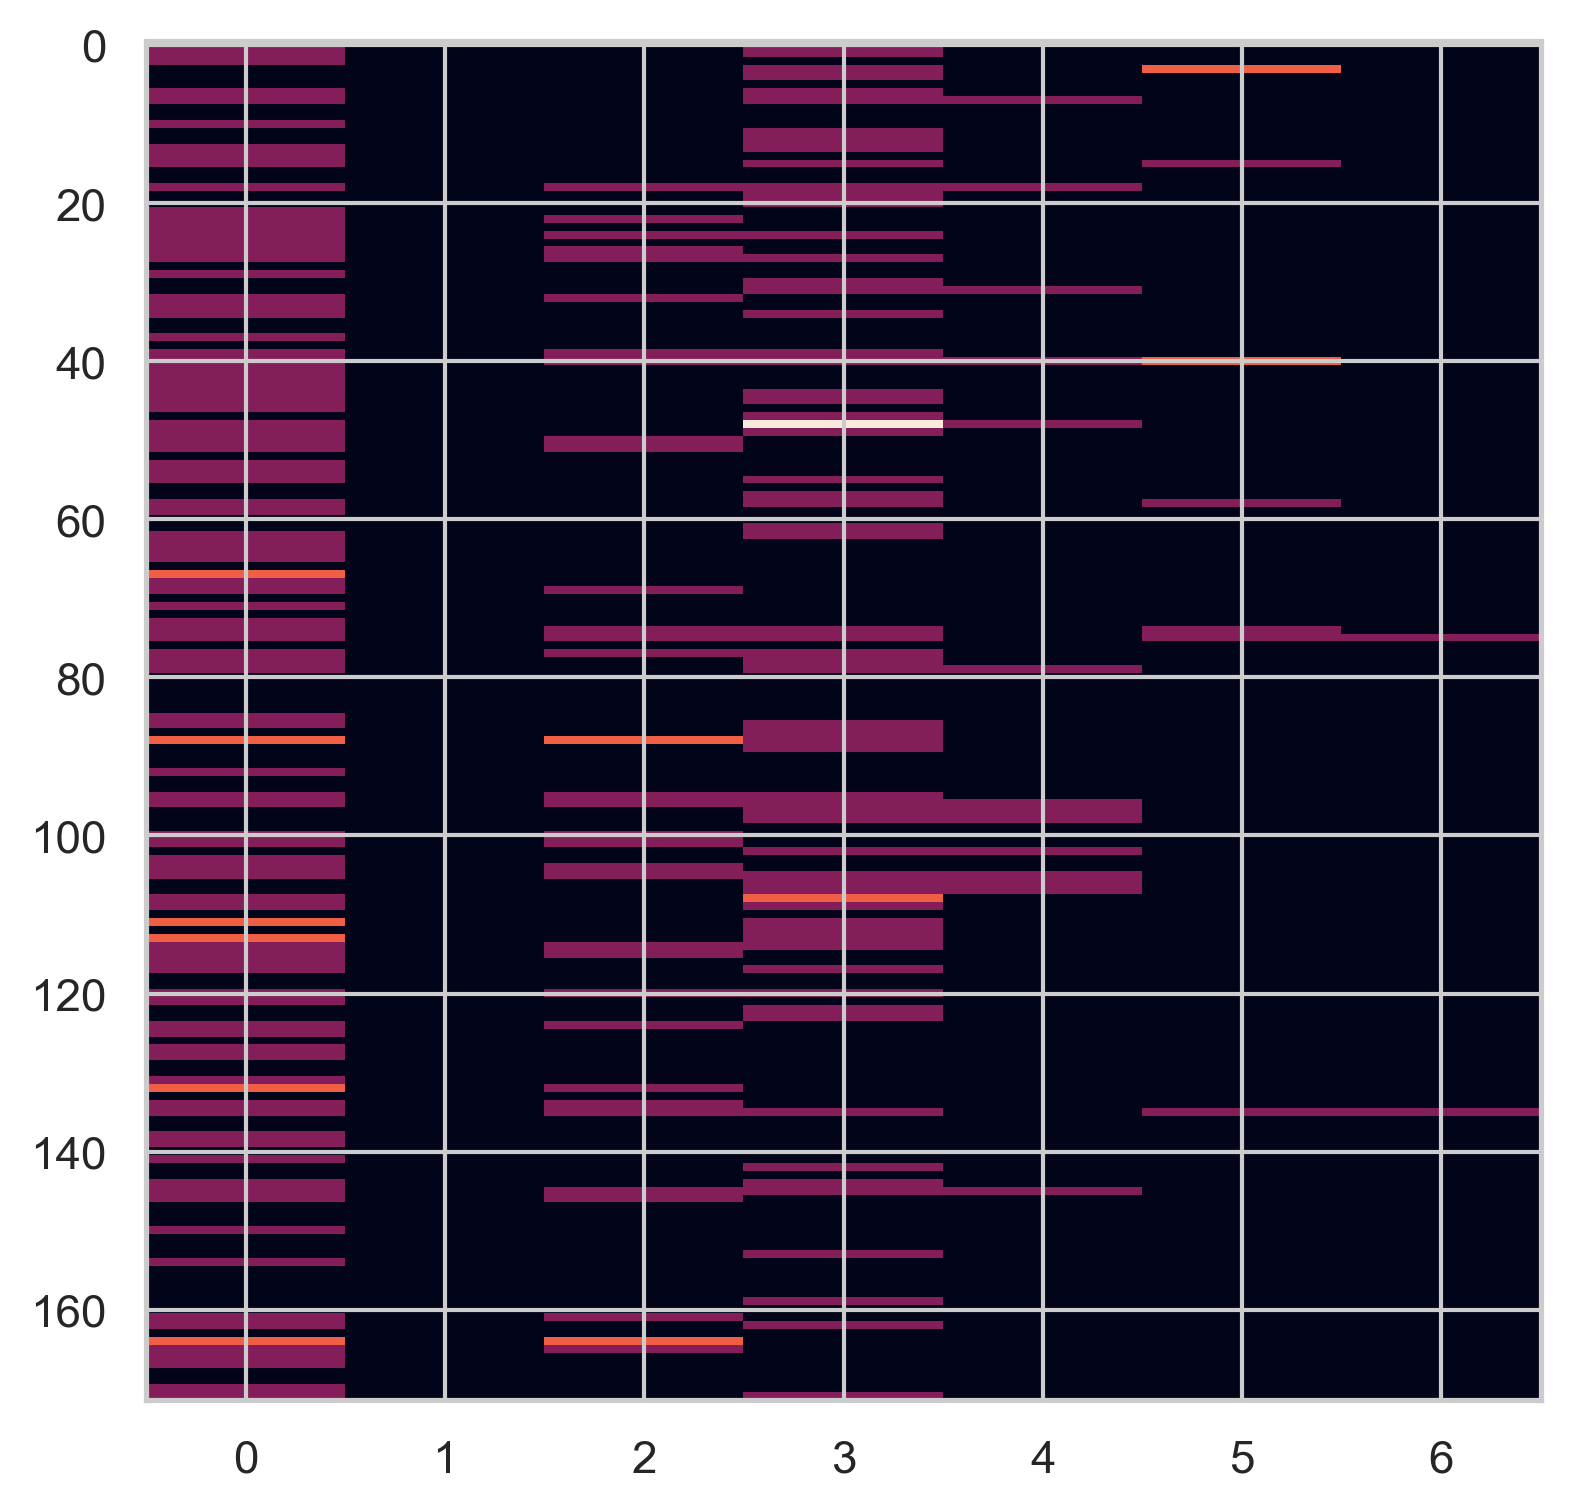

In [29]:
plt.imshow(dizzy_EDimages.iloc[:,1:],aspect='auto')

In [22]:
def make_hosp_images_df(images,cohort_df):

    images.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
    images.PtSSN = images.PtSSN.astype('int64')

    # restrict images to  cohort
    cohort_img = pd.merge(images,cohort_df[['PtSSN','AdmitDateTime','DischargeDateTime']],on='PtSSN')
    # restrict images to cohort  within the Admit and Discharge times
    cohort_img = cohort_img[(cohort_img.ExamDateTime >= cohort_img.AdmitDateTime) & (cohort_img.ExamDateTime <= cohort_img.DischargeDateTime)].copy()

    # clean up records with no CPTName
    cohort_img = cohort_img.dropna(subset = ['CPTName'])
    
    # CT images
    cohort_images_ct_count, cohort_images_ct_contrast_count, cohort_images_ct_abnormal_count = get_images_mode(cohort_img,'ct',is_ct_head,is_img_abnormal,is_ct_with_contrast)
    
    #Xray images
    cohort_images_xr_count, cohort_images_xr_contrast_count, cohort_images_xr_abnormal_count = get_images_mode(cohort_img,'xr',is_xray,is_img_abnormal,None)
    
    #MRI images
    cohort_images_mri_count, cohort_images_mri_contrast_count, cohort_images_mri_abnormal_count = get_images_mode(cohort_img,'mri',is_mri,is_img_abnormal,is_ct_with_contrast)


    # fix the zero counts
    # CT
    cohort_images_ct_count = fill_zero_df(cohort_images_ct_count,cohort_df)
    cohort_images_ct_contrast_count = fill_zero_df(cohort_images_ct_contrast_count,cohort_df)
    cohort_images_ct_abnormal_count = fill_zero_df(cohort_images_ct_abnormal_count,cohort_df)

    #XRay
    cohort_images_xr_count = fill_zero_df(cohort_images_xr_count,cohort_df)
    cohort_images_xr_abnormal_count = fill_zero_df(cohort_images_xr_abnormal_count,cohort_df)

    #MRI
    cohort_images_mri_count = fill_zero_df(cohort_images_mri_count,cohort_df)
    cohort_images_mri_abnormal_count = fill_zero_df(cohort_images_mri_abnormal_count,cohort_df)


    # combine into CT, XRay, MRI for dizzy 
    tmp_cohort = pd.merge(cohort_images_ct_count,cohort_images_ct_contrast_count,on=['PtSSN'])
    tmp_cohort = pd.merge(tmp_cohort,cohort_images_ct_abnormal_count,on=['PtSSN'])
    tmp_cohort = pd.merge(tmp_cohort,cohort_images_xr_count,on=['PtSSN'])
    tmp_cohort = pd.merge(tmp_cohort,cohort_images_xr_abnormal_count,on=['PtSSN'])
    tmp_cohort = pd.merge(tmp_cohort,cohort_images_mri_count,on=['PtSSN'])
    tmp_cohort = pd.merge(tmp_cohort,cohort_images_mri_abnormal_count,on=['PtSSN'])
    
    tmp_cohort.columns = ['PtSSN'] + ['hosp_' + x for x in tmp_cohort.columns[1:]]

    return tmp_cohort.drop_duplicates()

dizzy_hosp_images = make_hosp_images_df(images,clean_dizzy_cohort)
dizzy_hosp_images.shape

(172, 8)

In [23]:
dizzy_hosp_images.isnull().sum()

PtSSN                      0
hosp_ct_count              0
hosp_ct_contrast_count     0
hosp_ct_abnormal_count     0
hosp_xr_count              0
hosp_xr_abnormal_count     0
hosp_mri_count             0
hosp_mri_abnormal_count    0
dtype: int64

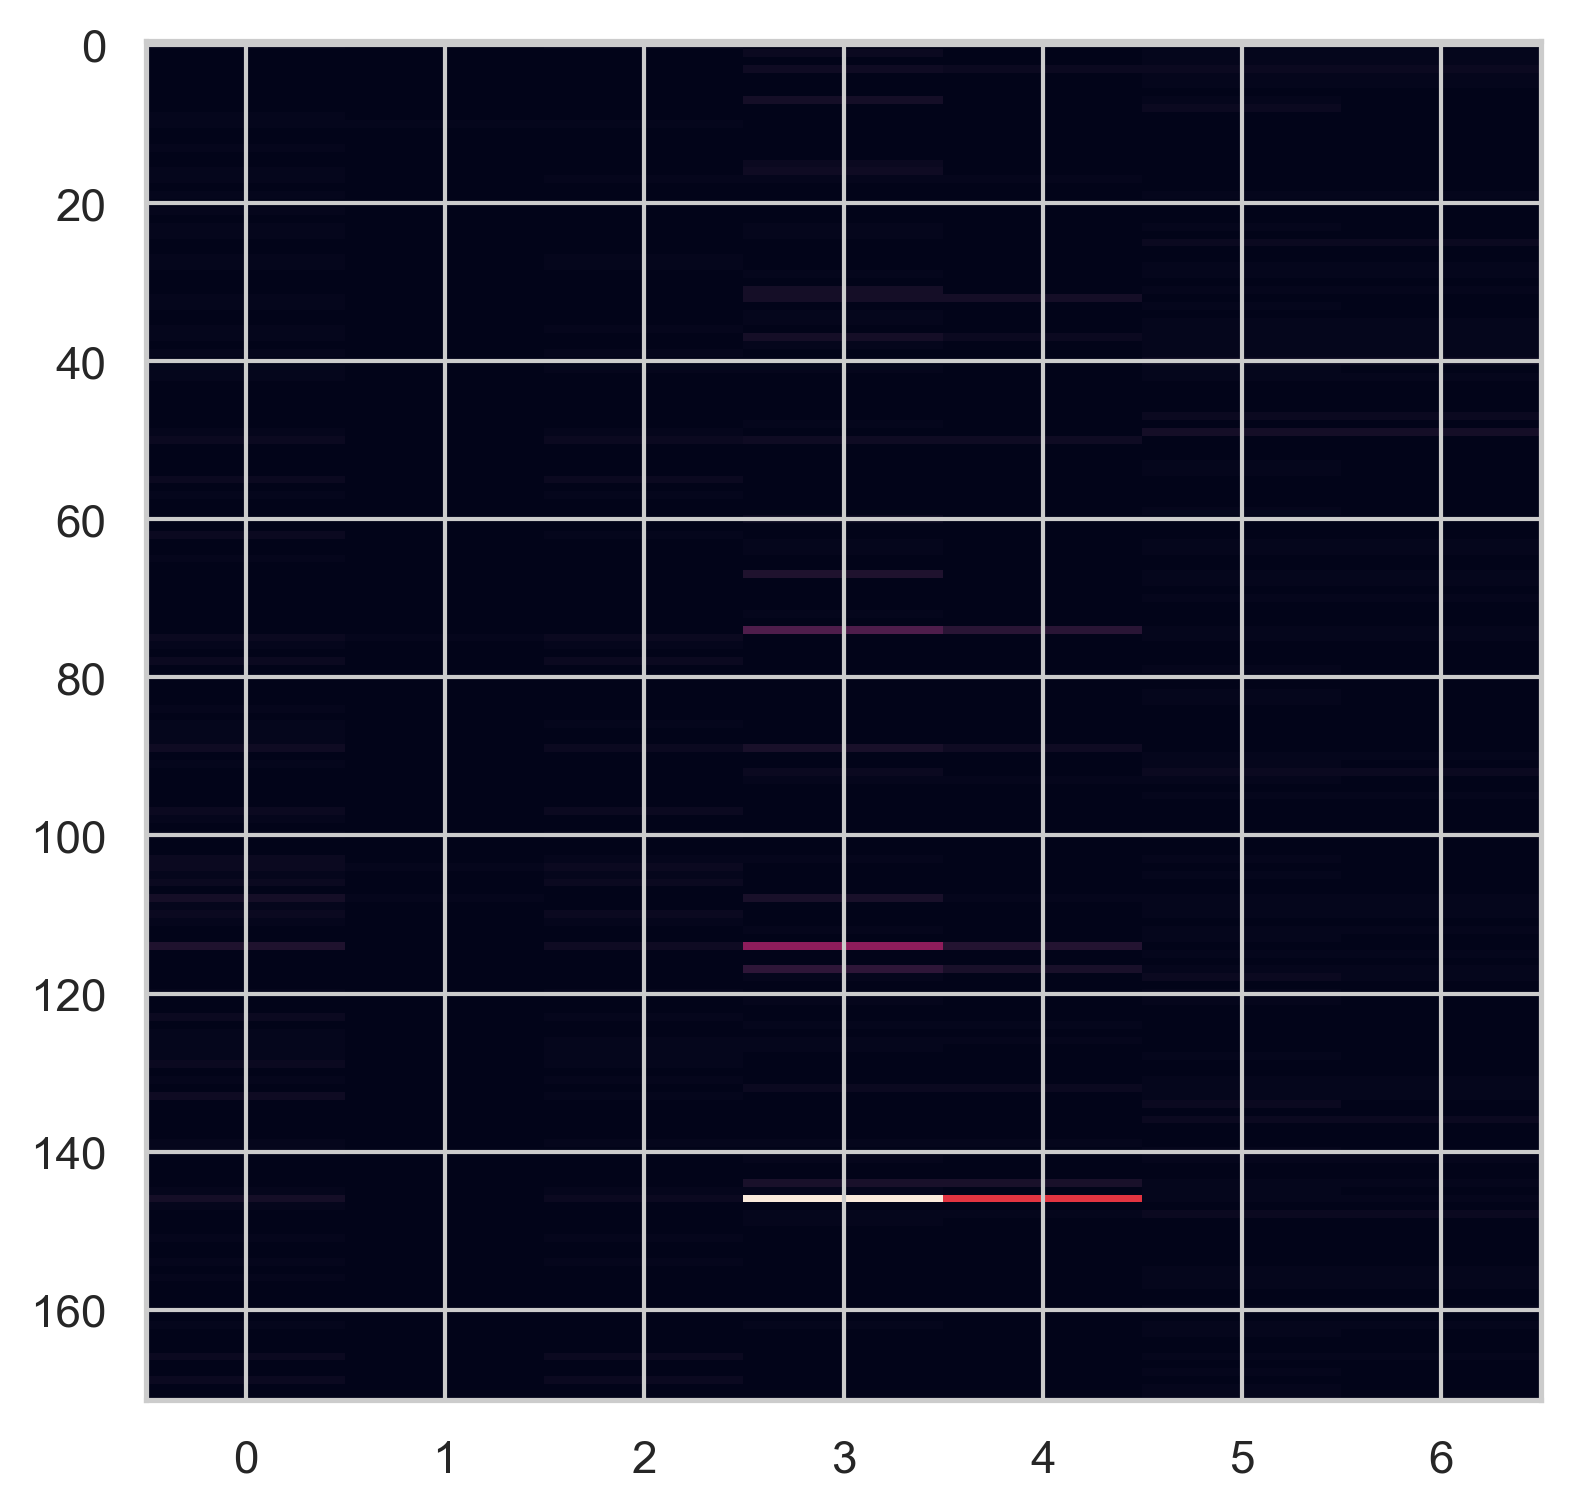

In [32]:
plt.imshow(dizzy_hosp_images.iloc[:,1:],aspect='auto')

# History

In [24]:
icds = dataset['ICD']

def make_dizzy_icds_df(icds,dizzy_cohort_df):
    icds.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
    icds.PtSSN = icds.PtSSN.astype('int64')

    # restrict icds to  cohort
    dizzy_cohort_icds = pd.merge(icds,dizzy_cohort_df[['PtSSN','EDStartDateTime','EDEndDateTime']],on='PtSSN')
    # restrict icds to cohort to before ED Start 
    dizzy_cohort_icds = dizzy_cohort_icds[(dizzy_cohort_icds.DiagDateTime <= dizzy_cohort_icds.EDEndDateTime)].copy()

    # get dizzy risk factors and boolean version of it
    dizzy_rf_df = get_dizzy_rf(dizzy_cohort_icds,dizzy_cohort_df)
    bool_dizzy_rf_df = pd.concat([dizzy_rf_df.PtSSN, dizzy_rf_df.iloc[:,1:].astype(bool).astype(int)],axis=1 )

    # add a column which is the number of risk factors
    bool_dizzy_rf_df['total_rf'] = bool_dizzy_rf_df.iloc[:,1:].sum(axis=1)
    return dizzy_rf_df, bool_dizzy_rf_df

dizzy_rf_df, bool_dizzy_rf_df = make_dizzy_icds_df(icds,clean_dizzy_cohort)
print(dizzy_rf_df.shape, bool_dizzy_rf_df.shape)

(172, 10) (172, 11)


In [25]:
bool_dizzy_rf_df.isnull().sum()

PtSSN                                                   0
Atrial fibrillation                                     0
Coronary artery disease (CAD)                           0
Diabetes                                                0
Hx aneurysm                                             0
Hx of stroke or TIA                                     0
Hyperlipidemia                                          0
Hypertension                                            0
Occlusion/Stenosis of cerebral or precerebral artery    0
Smoking                                                 0
total_rf                                                0
dtype: int64

# Labs at ED

In [26]:
labs = dataset['Lab']


def make_EDlabs_df(labs,cohort_df):
    labs.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
    labs.PtSSN = labs.PtSSN.astype('int64')

    # restrict labs to cohort
    cohort_labs = pd.merge(labs,cohort_df[['PtSSN','EDStartDateTime','EDEndDateTime']],on='PtSSN')
    # restrict labs to cohort within the ED Start and End Times
    cohort_labs = cohort_labs[(cohort_labs.LabChemSpecimenDateTime >= cohort_labs.EDStartDateTime) & 
                              (cohort_labs.LabChemSpecimenDateTime <= cohort_labs.EDEndDateTime)].copy()

    labs = ['WBC','glucose','albumin','potassium','calcium','lact','chloride','bun','creat','troponin','CO2','ast','alt',
        'alkphos','lipase','amylase','hgb']
    lab_fns = ['matches_' + lab + '_loinc' for lab in labs]

    # collect all labs and then filter later on
    lab_dict = {}

    for i in range(len(labs)):
        lab, labfn = labs[i], lab_fns[i]
        lab_dict[lab] = get_labs_data(cohort_labs,lab,eval(labfn),cohort_df)
        
    merged_labs = pd.DataFrame(cohort_df.PtSSN.unique(),columns=['PtSSN'])
    
    for lab in labs:
        merged_labs = pd.merge(merged_labs,lab_dict[lab],on='PtSSN')
        
    merged_labs.columns = ['PtSSN'] + ['ED_' + x for x in merged_labs.columns[1:]]
        
    return merged_labs

dizzy_EDlabs = make_EDlabs_df(labs,clean_dizzy_cohort)
dizzy_EDlabs.shape

(172, 69)

In [27]:
clean_dizzy_EDlabs = clean_lab_df(dizzy_EDlabs,dizzy_EDlabs.columns[1:],20)
clean_dizzy_EDlabs.shape

(172, 51)

In [37]:
imp_dizzy_EDlabs = clean_and_impute(dizzy_EDlabs,dizzy_EDlabs.columns[1:],20)
imp_dizzy_EDlabs.shape


(34, 50) (34,)
(34, 51) (138, 51)


(172, 51)

In [28]:
clean_dizzy_EDlabs.isnull().sum()

PtSSN                           0
ED_WBC_count                    0
ED_WBC_min                     27
ED_WBC_max                     27
ED_WBC_abnormal_count           0
ED_glucose_count                0
ED_glucose_min                 17
ED_glucose_max                 17
ED_glucose_abnormal_count       0
ED_albumin_count                0
ED_albumin_abnormal_count       0
ED_potassium_count              0
ED_potassium_min               20
ED_potassium_max               20
ED_potassium_abnormal_count     0
ED_calcium_count                0
ED_calcium_abnormal_count       0
ED_lact_count                   0
ED_lact_abnormal_count          0
ED_chloride_count               0
ED_chloride_min                20
ED_chloride_max                20
ED_chloride_abnormal_count      0
ED_bun_count                    0
ED_bun_min                     27
ED_bun_max                     27
ED_bun_abnormal_count           0
ED_creat_count                  0
ED_creat_min                   20
ED_creat_max  

# Labs at hospital

In [29]:
def make_hosp_labs_df(labs,cohort_df):
    labs.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
    labs.PtSSN = labs.PtSSN.astype('int64')

    # restrict labs to cohort
    cohort_labs = pd.merge(labs,cohort_df[['PtSSN','AdmitDateTime','DischargeDateTime']],on='PtSSN')
    # restrict labs to cohort within the Admit and Discharge 
    cohort_labs = cohort_labs[(cohort_labs.LabChemSpecimenDateTime >= cohort_labs.AdmitDateTime) & 
                              (cohort_labs.LabChemSpecimenDateTime <= cohort_labs.DischargeDateTime)].copy()

    labs = ['WBC','glucose','albumin','potassium','calcium','lact','chloride','bun','creat','troponin','CO2','ast','alt',
        'alkphos','lipase','amylase','hgb']
    lab_fns = ['matches_' + lab + '_loinc' for lab in labs]

    # collect all labs and then filter later on
    lab_dict = {}

    for i in range(len(labs)):
        lab, labfn = labs[i], lab_fns[i]
        lab_dict[lab] = get_labs_data(cohort_labs,lab,eval(labfn),cohort_df)
        
    merged_labs = pd.DataFrame(cohort_df.PtSSN.unique(),columns=['PtSSN'])
    
    for lab in labs:
        merged_labs = pd.merge(merged_labs,lab_dict[lab],on='PtSSN')
        
    merged_labs.columns = ['PtSSN'] + ['HOSP_' + x for x in merged_labs.columns[1:]]
        
    return merged_labs

dizzy_hosp_labs = make_hosp_labs_df(labs,clean_dizzy_cohort)
dizzy_hosp_labs.shape

(172, 69)

In [31]:
clean_dizzy_hosp_labs = clean_lab_df(dizzy_hosp_labs,dizzy_hosp_labs.columns[1:],20)
clean_dizzy_hosp_labs.shape

(172, 53)

In [32]:
clean_dizzy_hosp_labs.isnull().sum()

PtSSN                             0
HOSP_WBC_count                    0
HOSP_WBC_min                     29
HOSP_WBC_max                     29
HOSP_WBC_abnormal_count           0
HOSP_glucose_count                0
HOSP_glucose_min                 12
HOSP_glucose_max                 12
HOSP_glucose_abnormal_count       0
HOSP_albumin_count                0
HOSP_albumin_abnormal_count       0
HOSP_potassium_count              0
HOSP_potassium_min               20
HOSP_potassium_max               20
HOSP_potassium_abnormal_count     0
HOSP_calcium_count                0
HOSP_calcium_min                 27
HOSP_calcium_max                 27
HOSP_calcium_abnormal_count       0
HOSP_lact_count                   0
HOSP_lact_abnormal_count          0
HOSP_chloride_count               0
HOSP_chloride_min                21
HOSP_chloride_max                21
HOSP_chloride_abnormal_count      0
HOSP_bun_count                    0
HOSP_bun_min                     23
HOSP_bun_max                

In [42]:
imp_dizzy_hosp_labs = clean_and_impute(dizzy_hosp_labs,dizzy_hosp_labs.columns[1:],20)
imp_dizzy_hosp_labs.shape

(44, 52) (44,)
(44, 53) (128, 53)


(172, 53)

# Merge everything!
- use unimputed versions of all tables

In [33]:
dizzy_all = pd.merge(clean_dizzy_cohort_1pp,dizzy_demo_coded,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,clean_dizzy_EDvitals,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,clean_dizzy_hosp_vitals,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_EDconsults,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_hosp_consults,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_EDimages,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,dizzy_hosp_images,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,bool_dizzy_rf_df,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,clean_dizzy_EDlabs,on='PtSSN')
dizzy_all = pd.merge(dizzy_all,clean_dizzy_hosp_labs,on='PtSSN')

print(dizzy_all.shape)

dizzy_df, dizzy_labels_df = retrieveLabels_dizzy(dizzy_fname)
print(dizzy_labels_df.label.value_counts())



(172, 194)
NoMOD       44
MOD         38
PMOD        12
CodingEr     6
Name: label, dtype: int64
(154, 195)
unknown    72
NoMOD      44
MOD        38
Name: label, dtype: int64


# Use clinically relevant features from the tables for analysis
- clinical judgement provided by Andy Z

In [57]:
clinical_features= ['ed_duration_sum','hosp_stay_sum',
                    'ed_first_inp_delta_min',
                   'age_at_index_visit', 'Systolic_max', 'Systolic_min',
                   'Systolic_first',  'Diastolic_max', 'Diastolic_min',
                   'Diastolic_first', 'PULSE_max', 'PULSE_min',
                   'PULSE_first', 'TEMPERATURE_max', 'TEMPERATURE_min',
                   'TEMPERATURE_first', 'HOSP_Systolic_max',
                   'HOSP_Systolic_min', 'HOSP_Systolic_first', 
                   'HOSP_Diastolic_max', 'HOSP_Diastolic_min', 'HOSP_Diastolic_first',
                    'HOSP_PULSE_max', 'HOSP_PULSE_min',
                   'HOSP_PULSE_first', 'HOSP_TEMPERATURE_max',
                   'HOSP_TEMPERATURE_min', 'HOSP_TEMPERATURE_first', 
                   'ED_NEUROLOGY','ED_TELEPHONE/NEUROLOGY','HOSP_NEUROLOGY', 'HOSP_TELEPHONE/NEUROLOGY',
                   'mri_count','hosp_mri_count','Atrial fibrillation', 'Coronary artery disease (CAD)',
                   'Diabetes', 'Hx of stroke or TIA','Hypertension', 
                    'Occlusion/Stenosis of cerebral or precerebral artery','Hx aneurysm',
                   'ED_WBC_min', 'ED_WBC_max','ED_WBC_abnormal_count',
                   'ED_CO2_count','ED_CO2_min','ED_CO2_max', 'ED_CO2_abnormal_count',
                   'ED_lact_count', 'ED_lact_abnormal_count',
                   'ED_glucose_min','ED_creat_max','ED_troponin_abnormal_count','ED_hgb_min',
                    'HOSP_WBC_min', 'HOSP_WBC_max','HOSP_WBC_abnormal_count',
                   'HOSP_CO2_count','HOSP_CO2_min', 'HOSP_CO2_max', 'HOSP_CO2_abnormal_count',
                   'HOSP_lact_count','HOSP_lact_abnormal_count',
                   'HOSP_hgb_min', 'HOSP_creat_max','HOSP_troponin_abnormal_count',
                   'HOSP_glucose_min']

datadf = dizzy_all.loc[:,['PtSSN'] + clinical_features]
print(datadf.shape)
# clean and impute the datadf
imp_datadf = clean_and_impute(datadf,datadf.columns[1:-1],10)

# get the labeled dizzy_all (no completions)
dizzy_all_labeled = pd.merge(imp_datadf,dizzy_labels_df,on='PtSSN',how='left')
dizzy_all_labeled.label.fillna('unknown',inplace=True)
dizzy_all_labeled_nm = dizzy_all_labeled[dizzy_all_labeled.label.isin(['NoMOD','MOD','unknown'])]
print(dizzy_all_labeled_nm.shape)
print(dizzy_all_labeled_nm.label.value_counts())

(172, 68)
(44, 55) (44,)
(44, 56) (128, 56)
(154, 57)
unknown    72
NoMOD      44
MOD        38
Name: label, dtype: int64


In [70]:
sig_fields

['ed_duration_sum',
 'ed_first_inp_delta_min',
 'Systolic_max',
 'Systolic_first',
 'Diastolic_max',
 'Diastolic_first',
 'HOSP_Systolic_max',
 'HOSP_Diastolic_max',
 'Atrial fibrillation',
 'Hx aneurysm',
 'ED_WBC_abnormal_count',
 'HOSP_lact_abnormal_count']

In [73]:
dizzy_all_labeled_nm.columns

Index(['PtSSN', 'ed_duration_sum', 'hosp_stay_sum', 'ed_first_inp_delta_min',
       'age_at_index_visit', 'Systolic_max', 'Systolic_min', 'Systolic_first',
       'Diastolic_max', 'Diastolic_min', 'Diastolic_first', 'PULSE_max',
       'PULSE_min', 'PULSE_first', 'TEMPERATURE_max', 'TEMPERATURE_min',
       'TEMPERATURE_first', 'HOSP_Systolic_max', 'HOSP_Systolic_min',
       'HOSP_Systolic_first', 'HOSP_Diastolic_max', 'HOSP_Diastolic_min',
       'HOSP_Diastolic_first', 'HOSP_PULSE_max', 'HOSP_PULSE_min',
       'HOSP_PULSE_first', 'HOSP_TEMPERATURE_max', 'HOSP_TEMPERATURE_min',
       'HOSP_TEMPERATURE_first', 'ED_NEUROLOGY', 'ED_TELEPHONE/NEUROLOGY',
       'HOSP_NEUROLOGY', 'HOSP_TELEPHONE/NEUROLOGY', 'mri_count',
       'hosp_mri_count', 'Atrial fibrillation',
       'Coronary artery disease (CAD)', 'Diabetes', 'Hx of stroke or TIA',
       'Hypertension', 'Occlusion/Stenosis of cerebral or precerebral artery',
       'Hx aneurysm', 'ED_WBC_abnormal_count', 'ED_CO2_count',
     

(154, 15)
(154, 13) (154,)


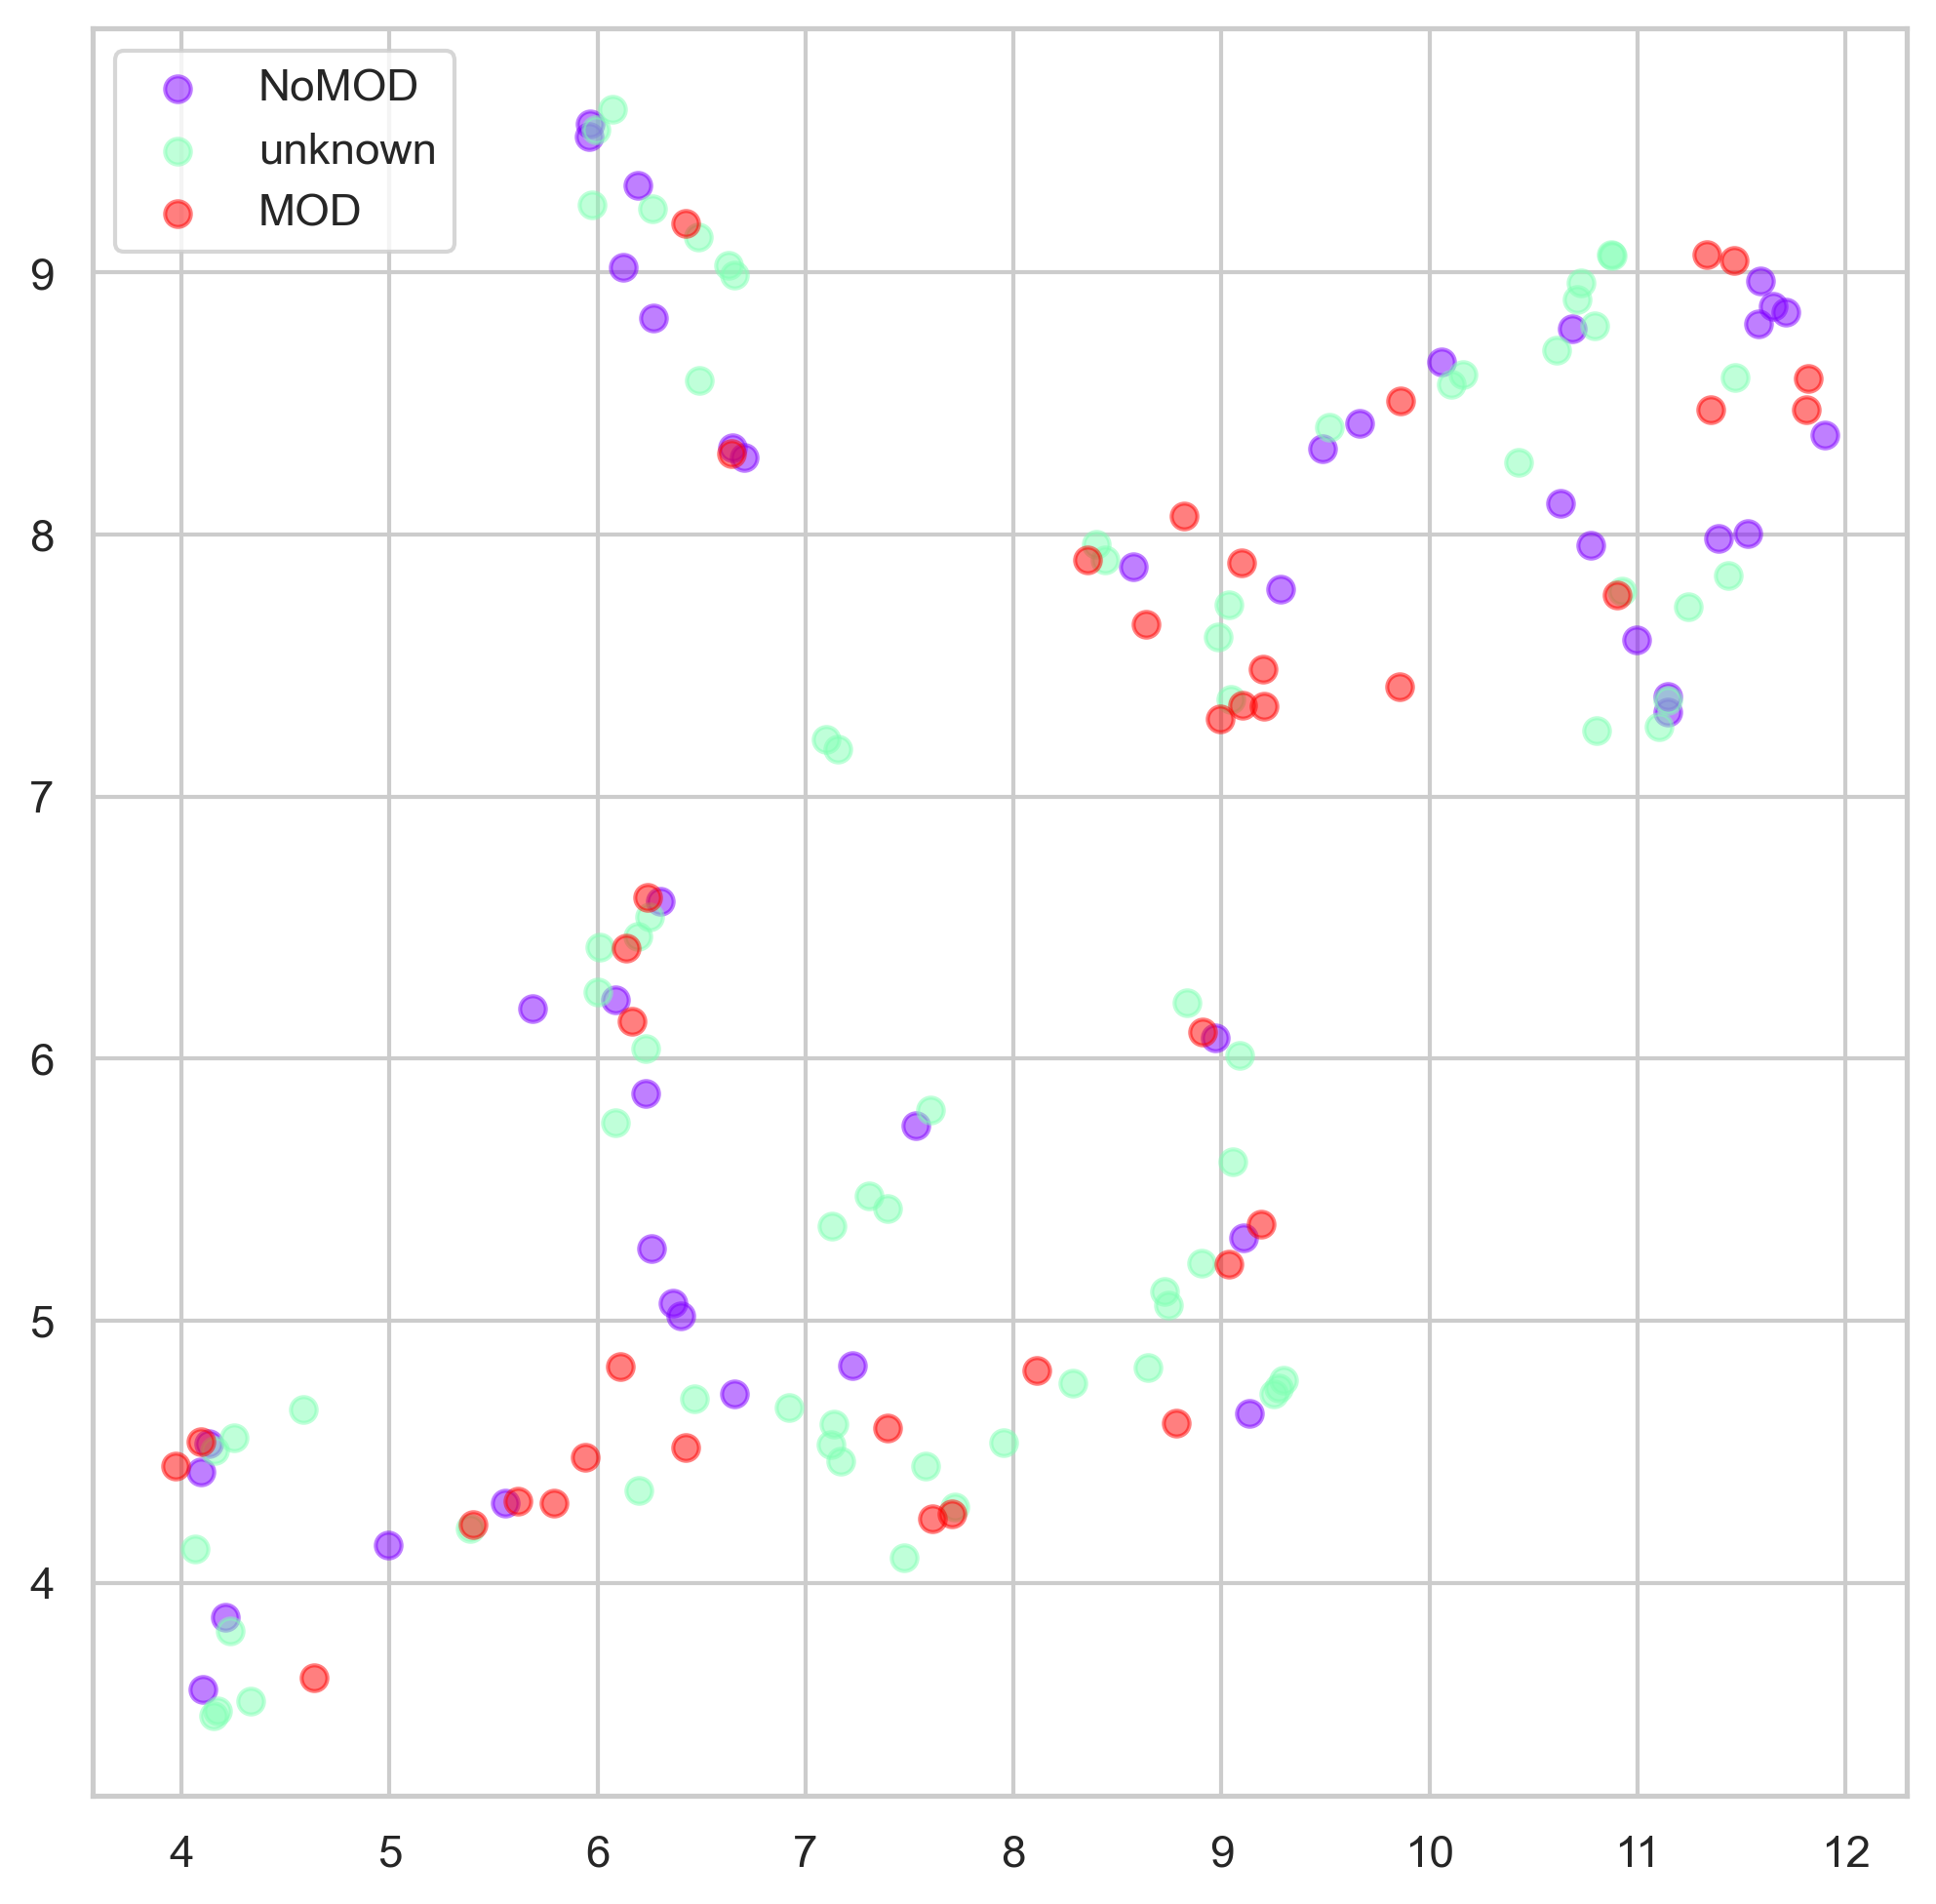

In [78]:
# UMAP with Andy features

tmp = dizzy_all_labeled_nm[sig_fields + ['TEMPERATURE_max','HOSP_CO2_abnormal_count'] + ['label']]
print(tmp.shape)

X = tmp.iloc[:,1:-1]
y = tmp['label']

print(X.shape,y.shape)
label_list = list(tmp.label.value_counts().index)
u = umap_plot_label(X,y,1,7,['NoMOD','unknown','MOD'],'upper left');


Cluster  1
unknown    10
NoMOD       7
MOD         2
Name: label, dtype: int64
Cluster  2
unknown    38
MOD        19
NoMOD      18
Name: label, dtype: int64
Cluster  3
unknown    24
NoMOD      19
MOD        17
Name: label, dtype: int64


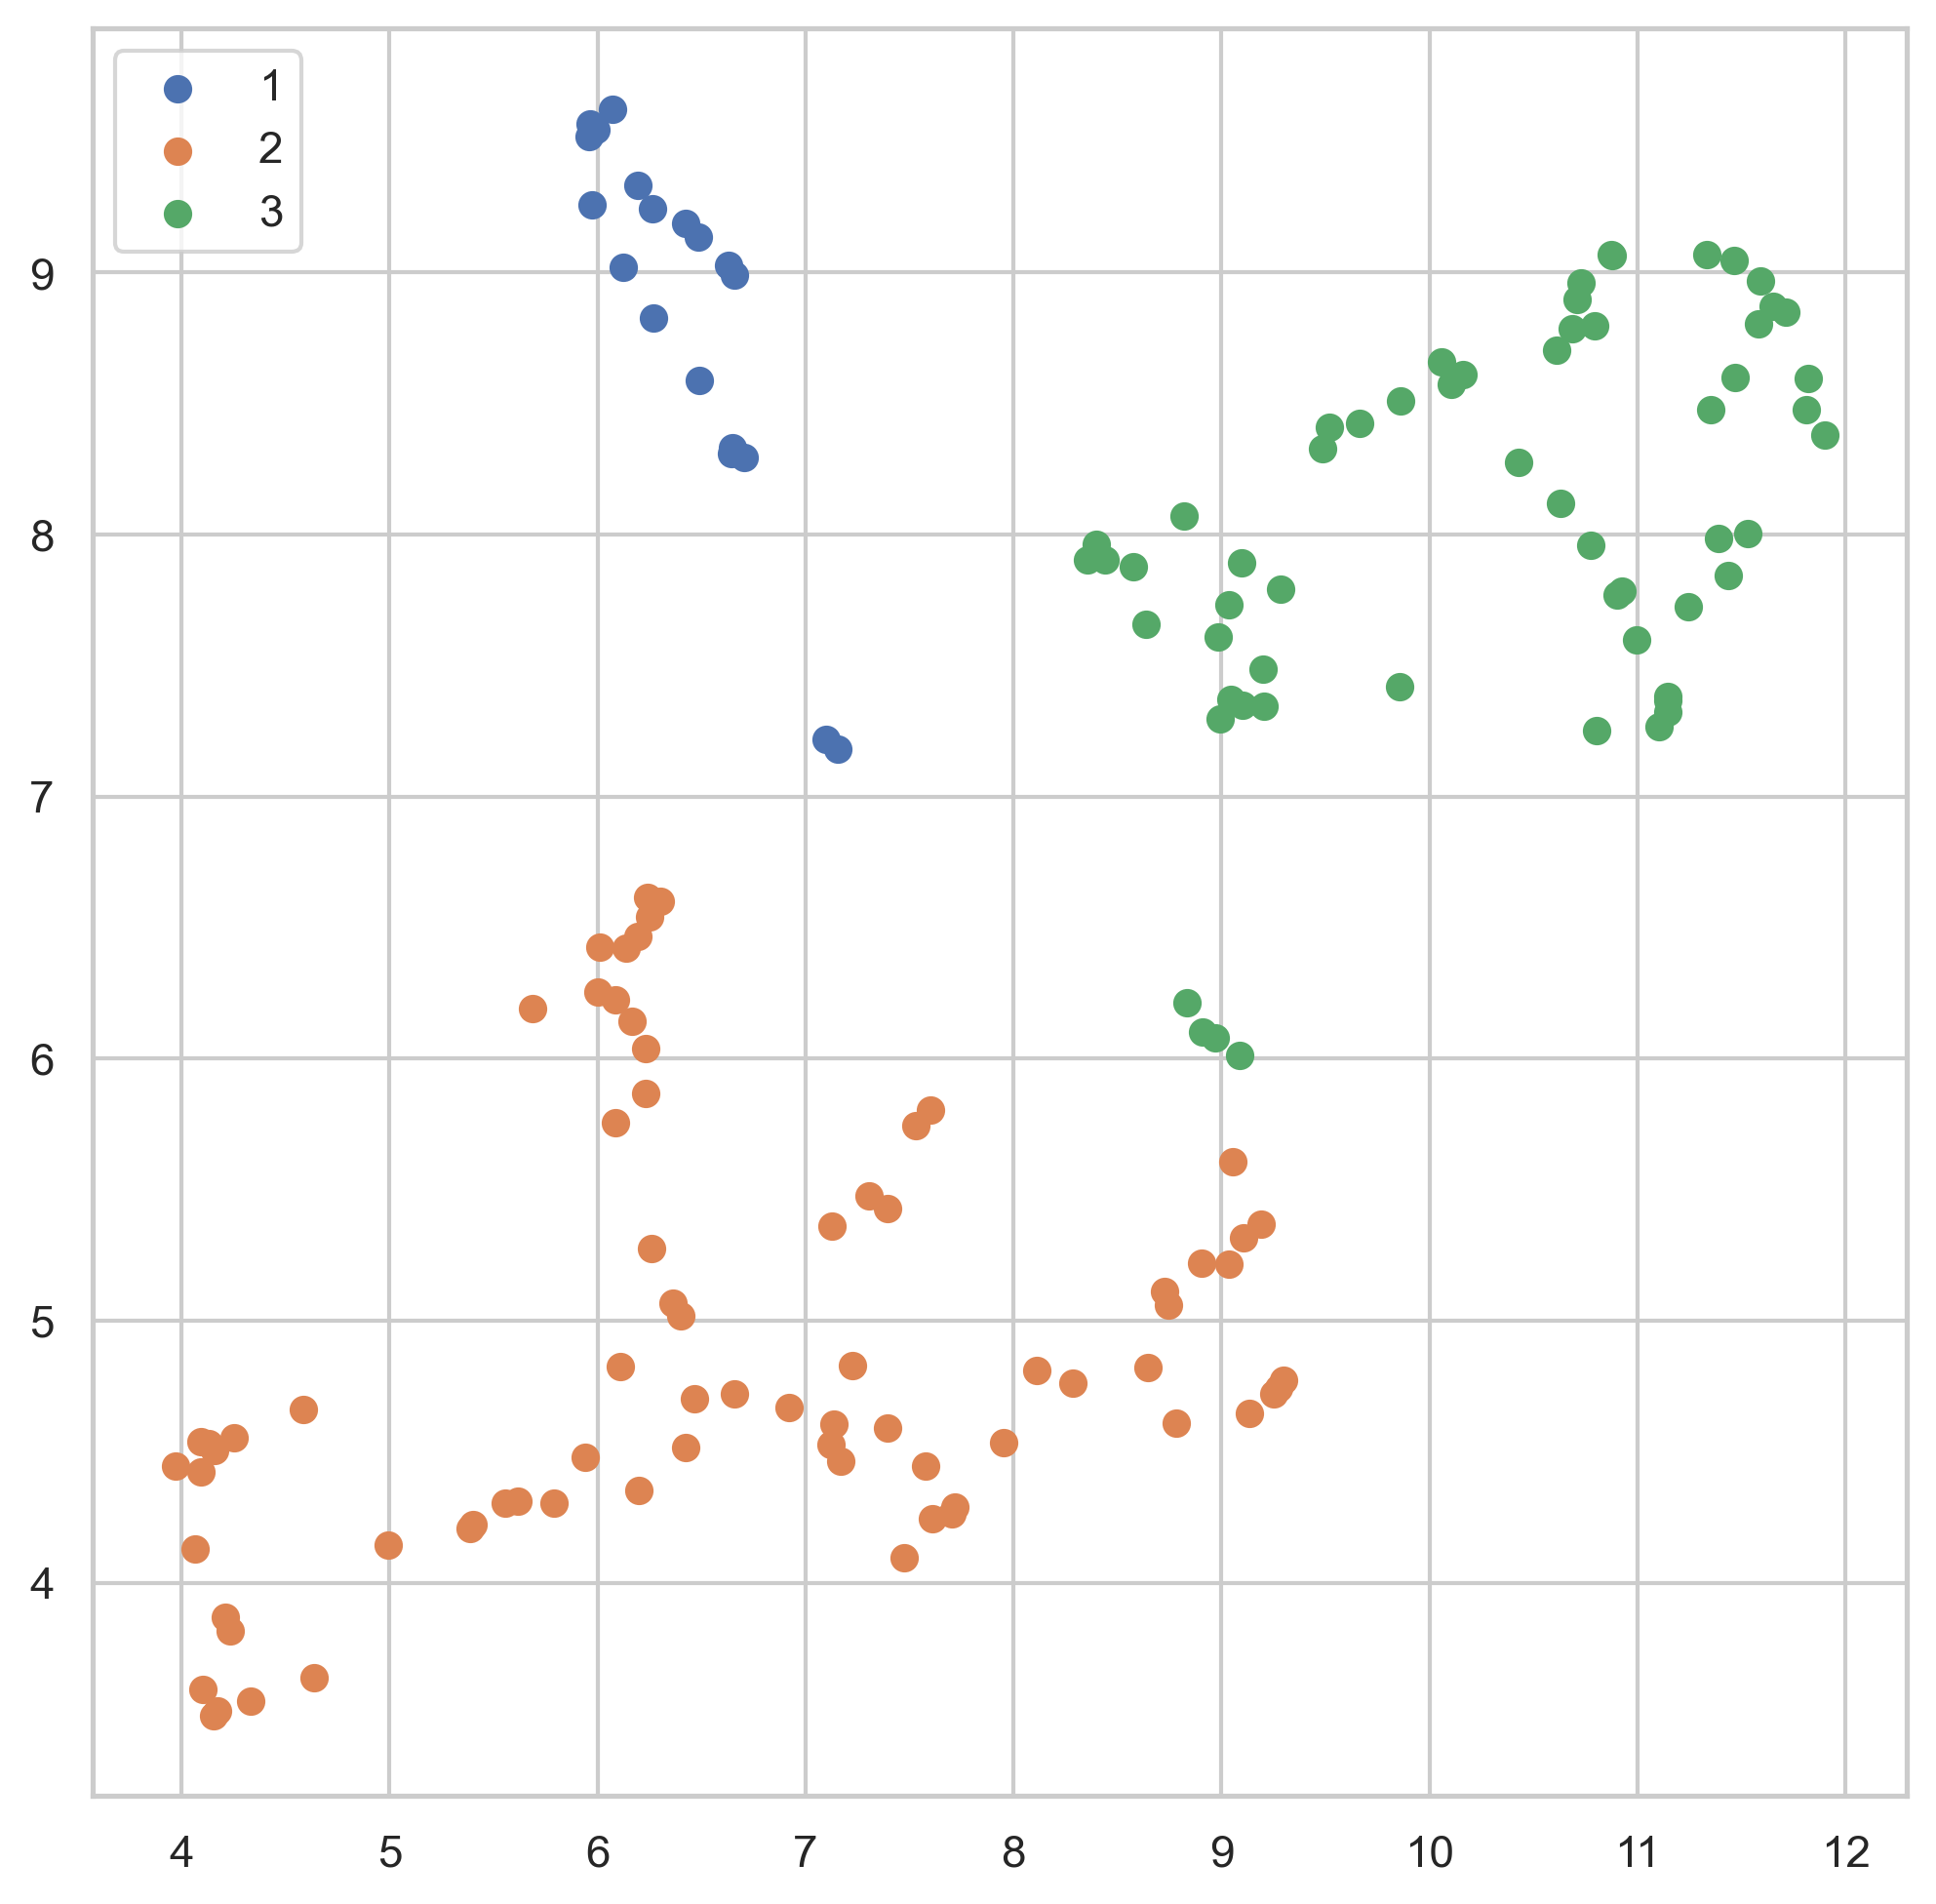

In [81]:
clust = cluster_umap(u,3,tmp,'upper left')

(82, 13) (82,)
Best C =  5.736152510448681
(82, 13) (82,)
AUC =  0.6977678571428572 0.15323604866958349
F1 =  0.7000869821612856 0.14659199258886002
Accuracy =  0.7051470588235295 0.14386983496120617
Confusion matrix:
[[30 14]
 [12 26]]
13  features chosen by L1 model.


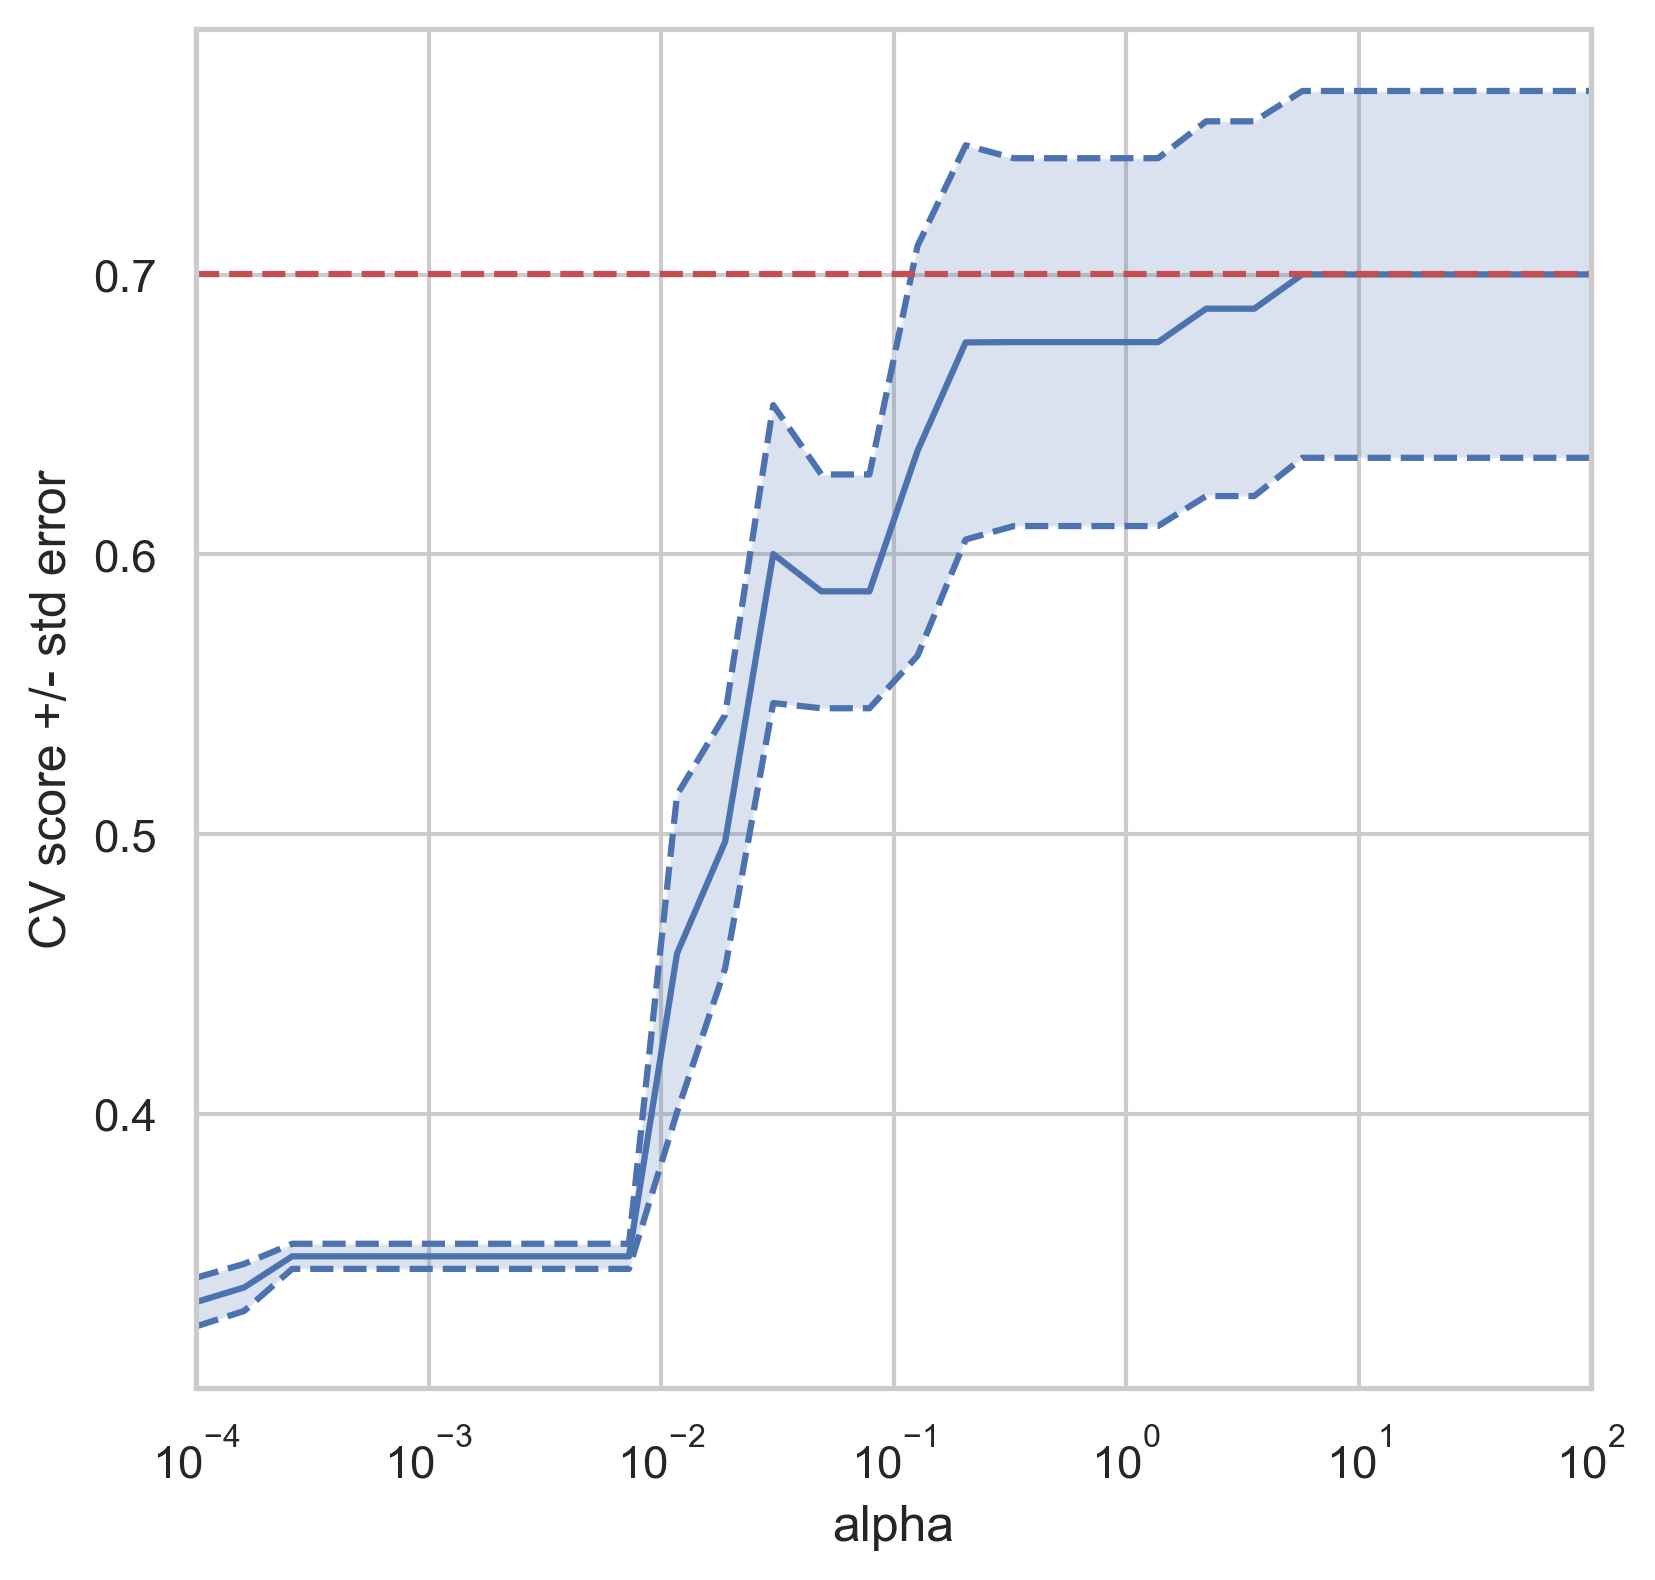

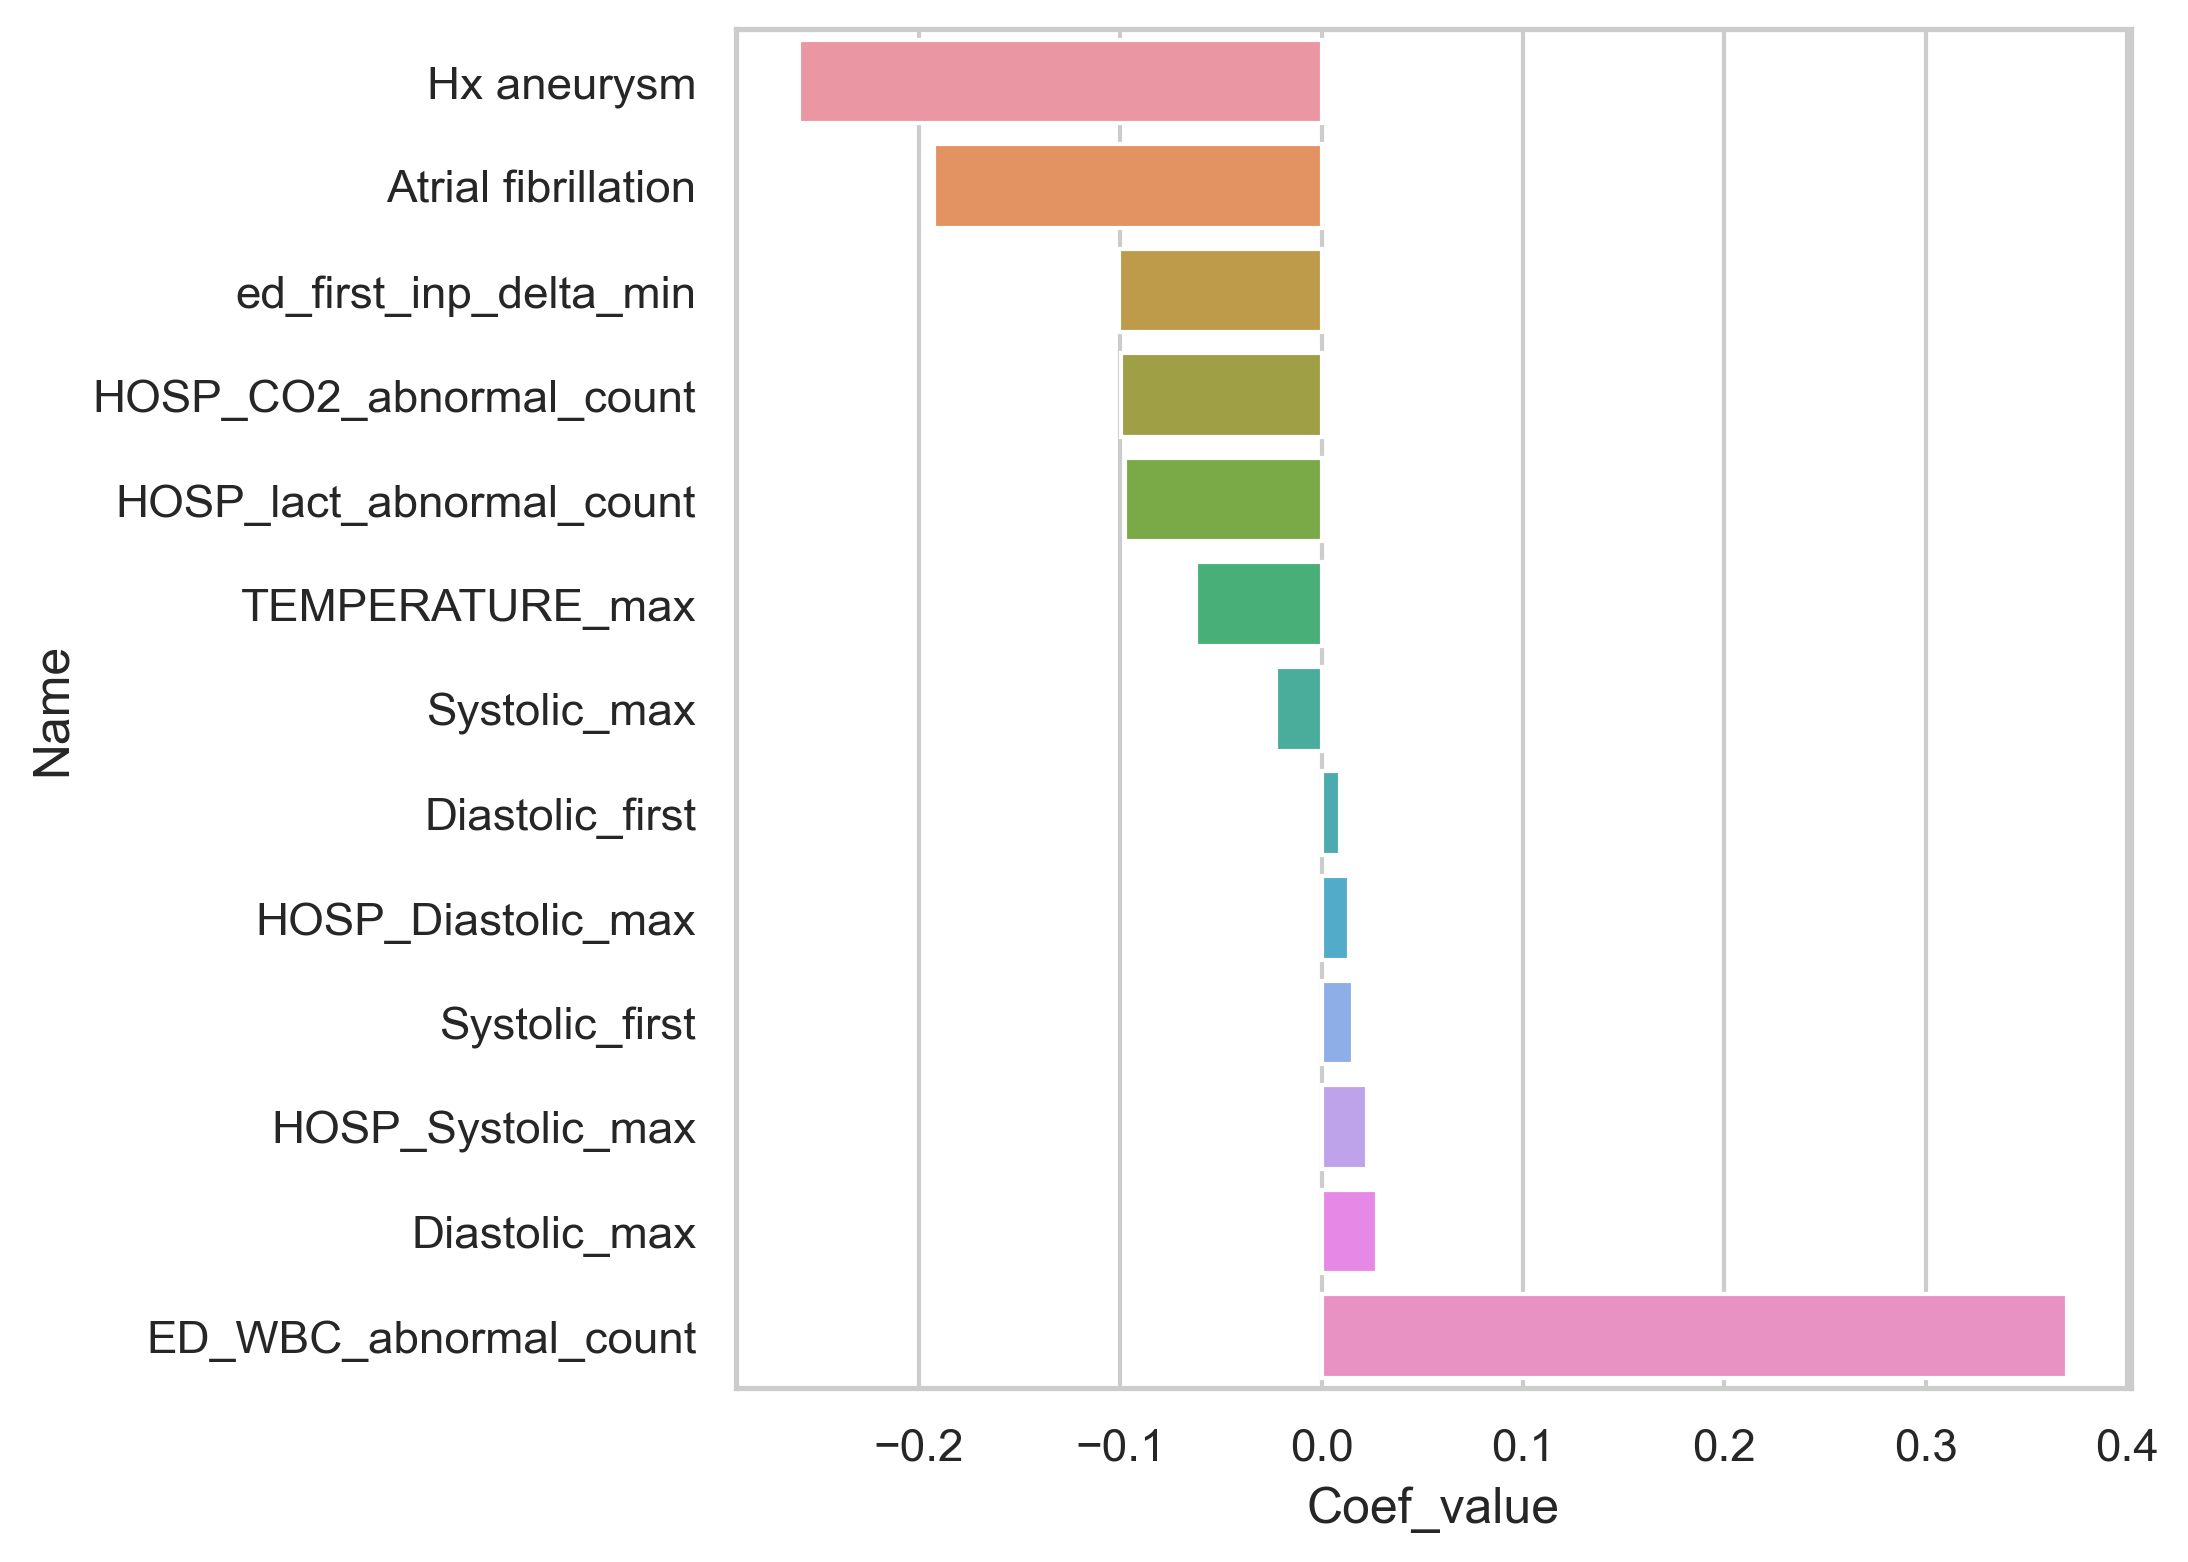

In [82]:
# a logistic regression model on ttest selected features

bin_tmp = tmp[tmp.label.isin(['MOD','NoMOD'])]
X = bin_tmp.iloc[:,1:-1]
yy = bin_tmp['label']
y = np.array([1 if (x=='MOD') else 0 for x in yy])
print(X.shape,y.shape)
clf = tune_model(X,y)
print('Best C = ',clf.best_params_['C'])

logreg, select_feats = build_L1_model(X,y,clf.best_params_['C'])
plt.figure()
visualize_model(logreg,select_feats)

(82, 13) (82,)
0.5717261904761906 0.15422538768504088
[[38  6]
 [ 1 37]]


<AxesSubplot:>

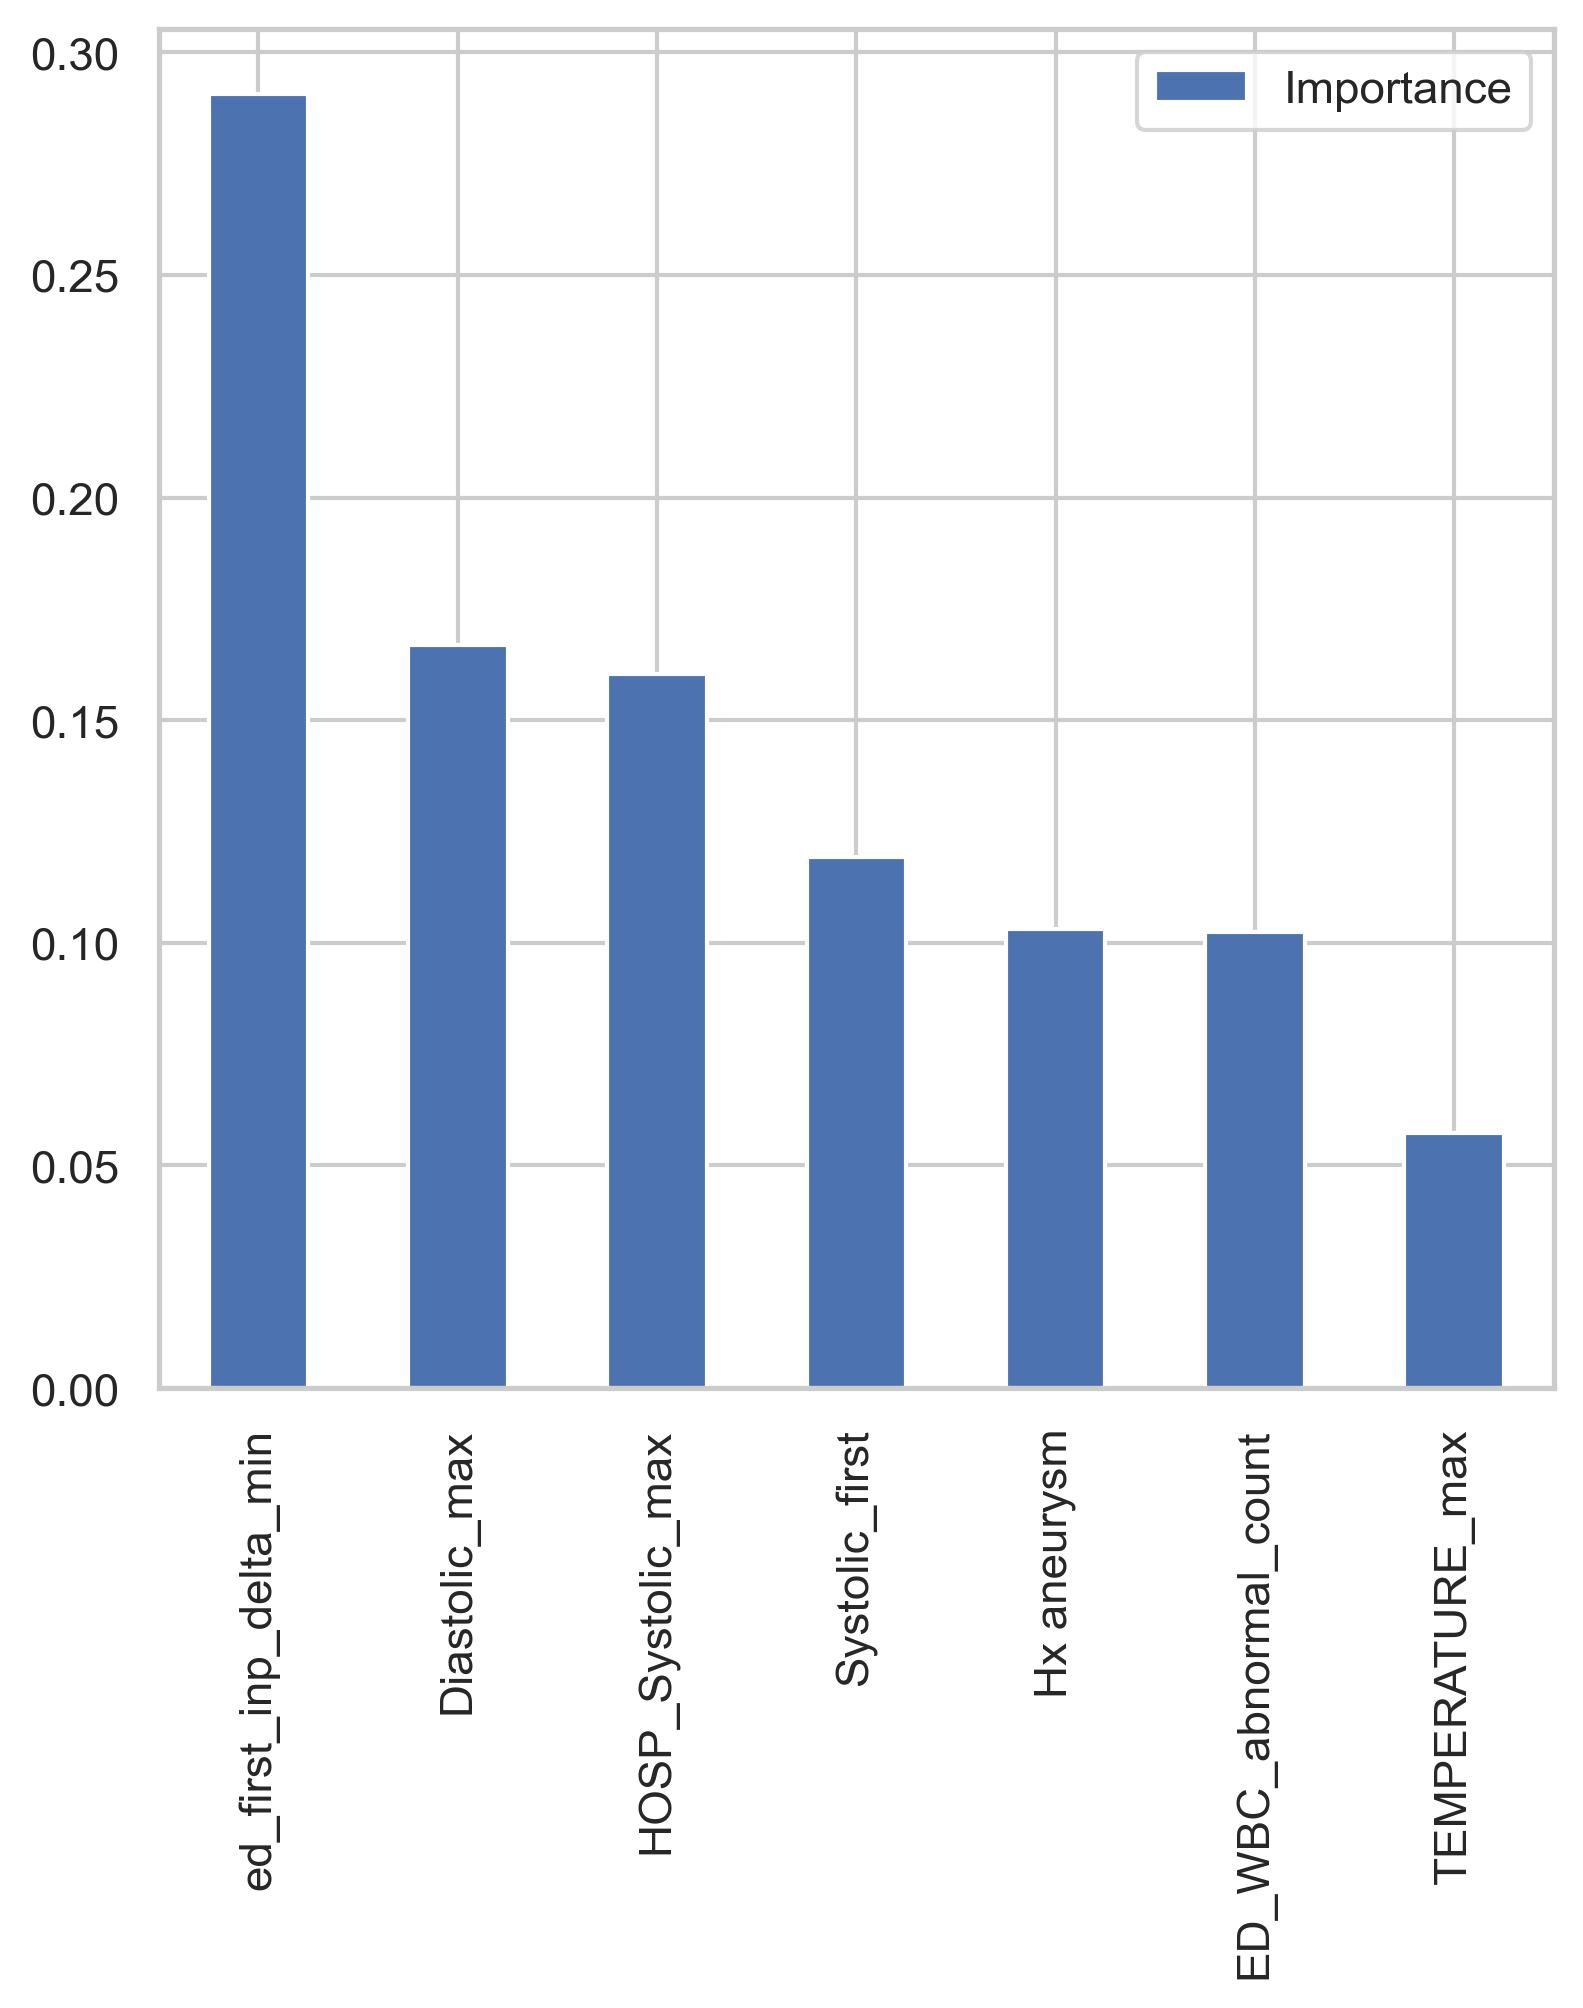

In [83]:
# single decision tree




X = bin_tmp.iloc[:,1:-1]
yy = bin_tmp['label']
y = np.array([1 if (x=='MOD') else 0 for x in yy])
print(X.shape,y.shape)

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0,max_depth=4)
scores = cross_val_score(clf,X,y,cv=5,scoring='roc_auc')
print(scores.mean(),scores.std())
clf.fit(X,y)

ypred = clf.predict(X)
print(metrics.confusion_matrix(y,ypred))
featimp_dt = pd.DataFrame(clf.feature_importances_,index=X.columns,columns=['Importance'])
featimp_dt.sort_values(by='Importance',ascending=False,inplace=True)
featimp_dt[featimp_dt.Importance > 0].plot(kind='bar')

In [86]:
# do a train-test split to understand the nature of the overfitting
from sklearn.model_selection import train_test_split

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,stratify=y)



clf = DecisionTreeClassifier(random_state=0,max_depth=6)
clf.fit(Xtrain,ytrain)

ypred = clf.predict(Xtest)
print(metrics.confusion_matrix(ytest,ypred))

np.unique(ytest,return_counts=True)

[[7 2]
 [4 4]]


(array([0, 1]), array([9, 8], dtype=int64))

(154, 7) (154,)


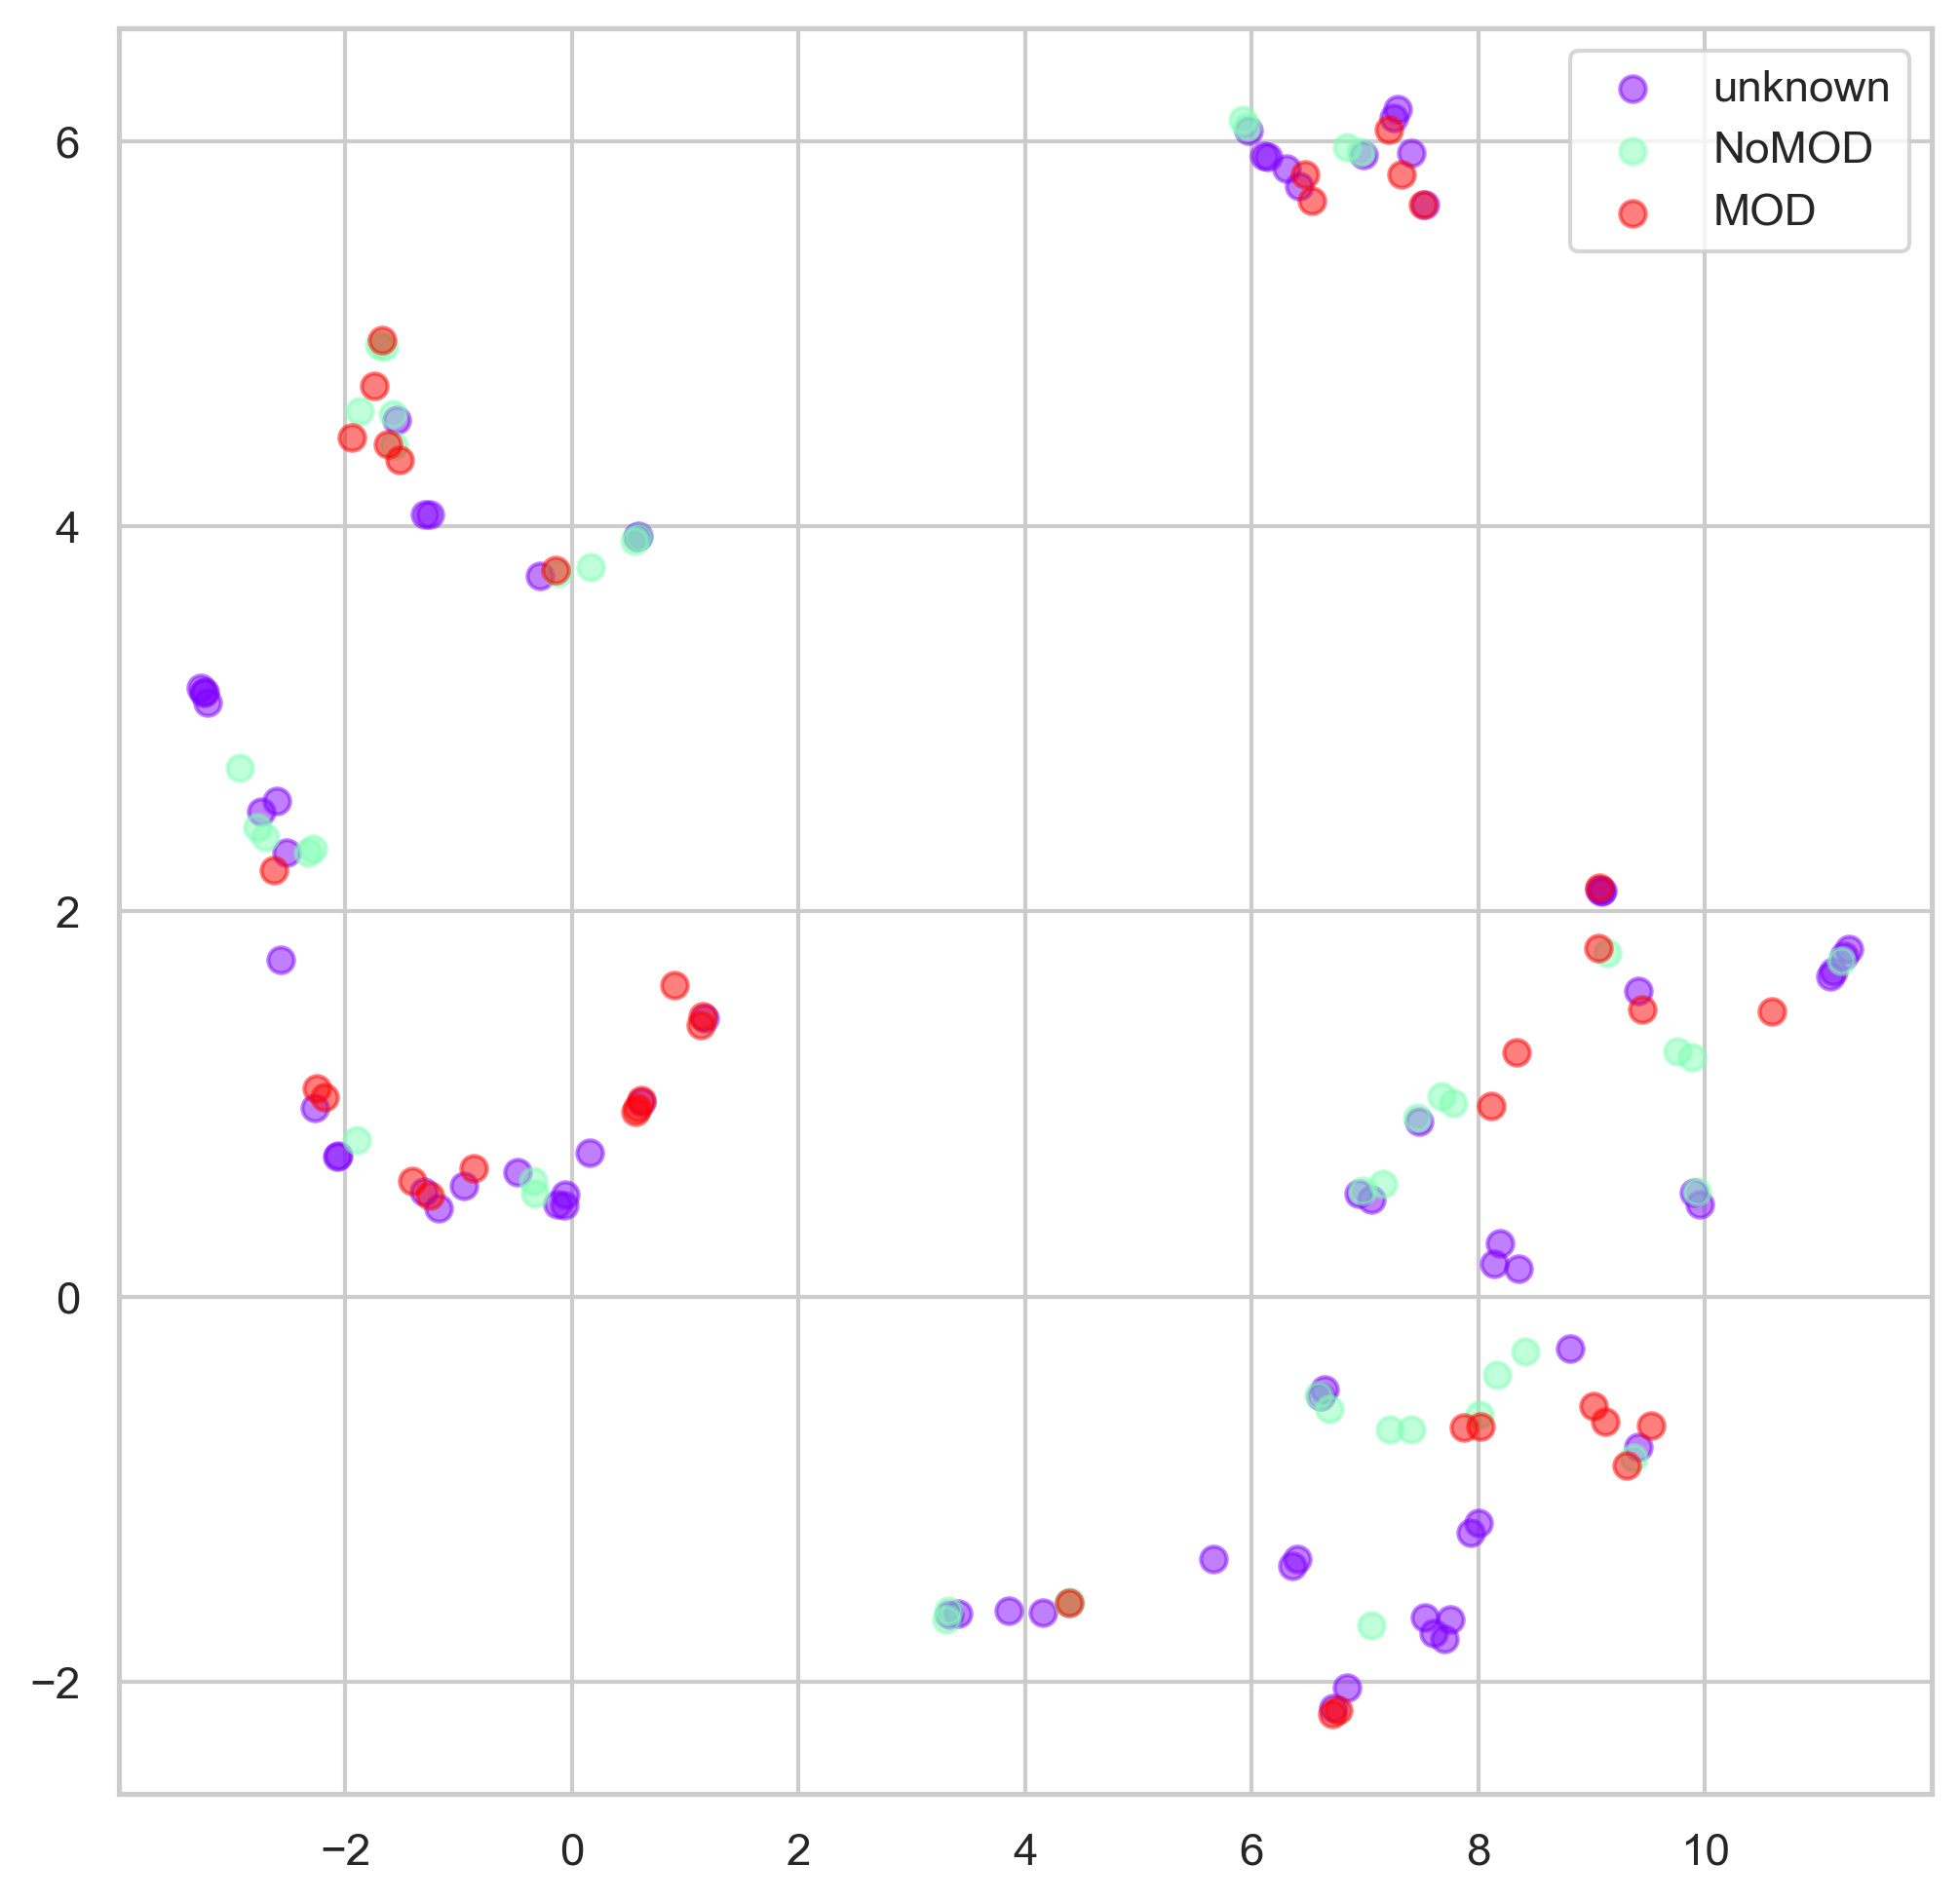

In [88]:
# what is the UMAP like on these five features?
dt_feats = featimp_dt[featimp_dt.Importance > 0].index

utmp = dizzy_all_labeled_nm.loc[:,list(dt_feats) + ['label']].dropna()
uX = utmp.iloc[:,:-1]
uy = utmp['label']

print(uX.shape,uy.shape)
label_list = list(utmp.label.value_counts().index)
u = umap_plot_label(uX,uy,1,4,label_list,'upper right');


Cluster  1
unknown    16
NoMOD      11
MOD        10
Name: label, dtype: int64
Cluster  2
unknown    13
MOD        11
NoMOD       3
Name: label, dtype: int64
Cluster  3
unknown    19
NoMOD      12
MOD         5
Name: label, dtype: int64
Cluster  4
unknown    10
MOD         5
NoMOD       4
Name: label, dtype: int64
Cluster  5
NoMOD      14
unknown    14
MOD         7
Name: label, dtype: int64


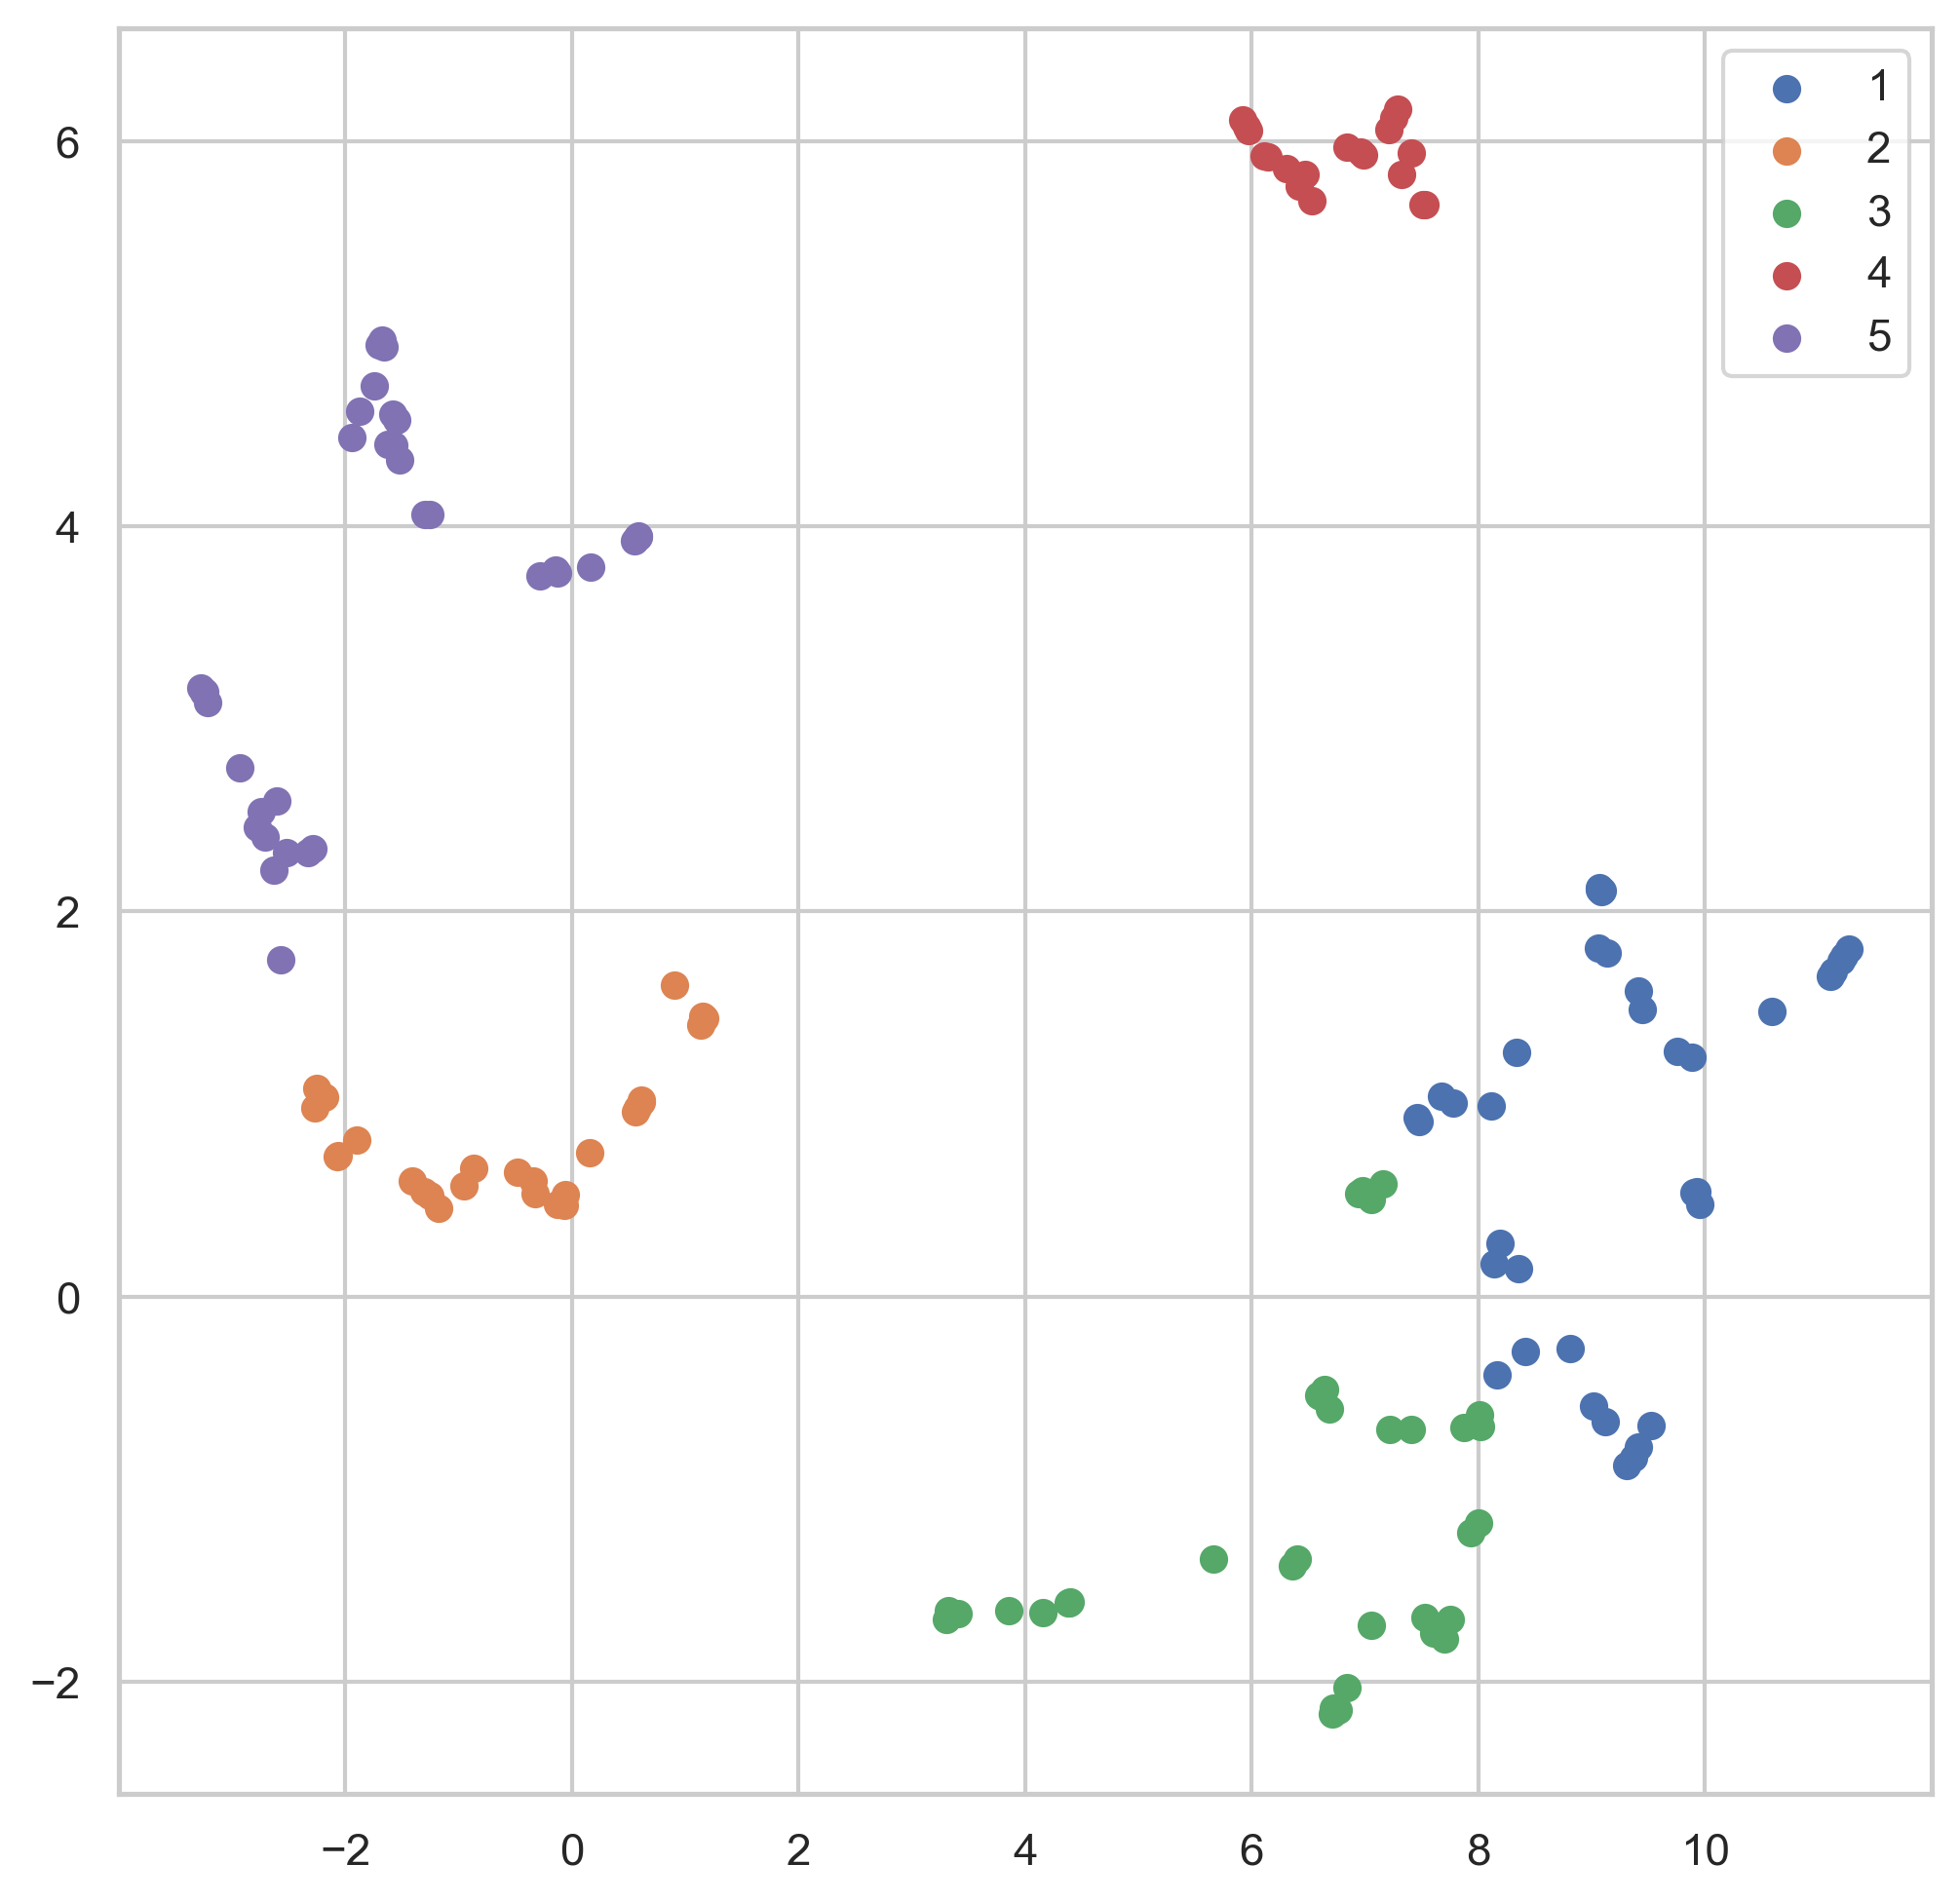

In [89]:
clust = cluster_umap(u,5, utmp,'upper right')

In [ ]:
analyze_clusters(clust,dizzy_all_labeled_nm,dt_feats) 

In [101]:
featimp.columns

AttributeError: 'Series' object has no attribute 'columns'

(82, 13) (82,)


array([[37,  7],
       [ 7, 31]], dtype=int64)

AUC =  0.8283492822966507 F1 =  0.8157894736842104
0.6529017857142858 0.1582288789123231


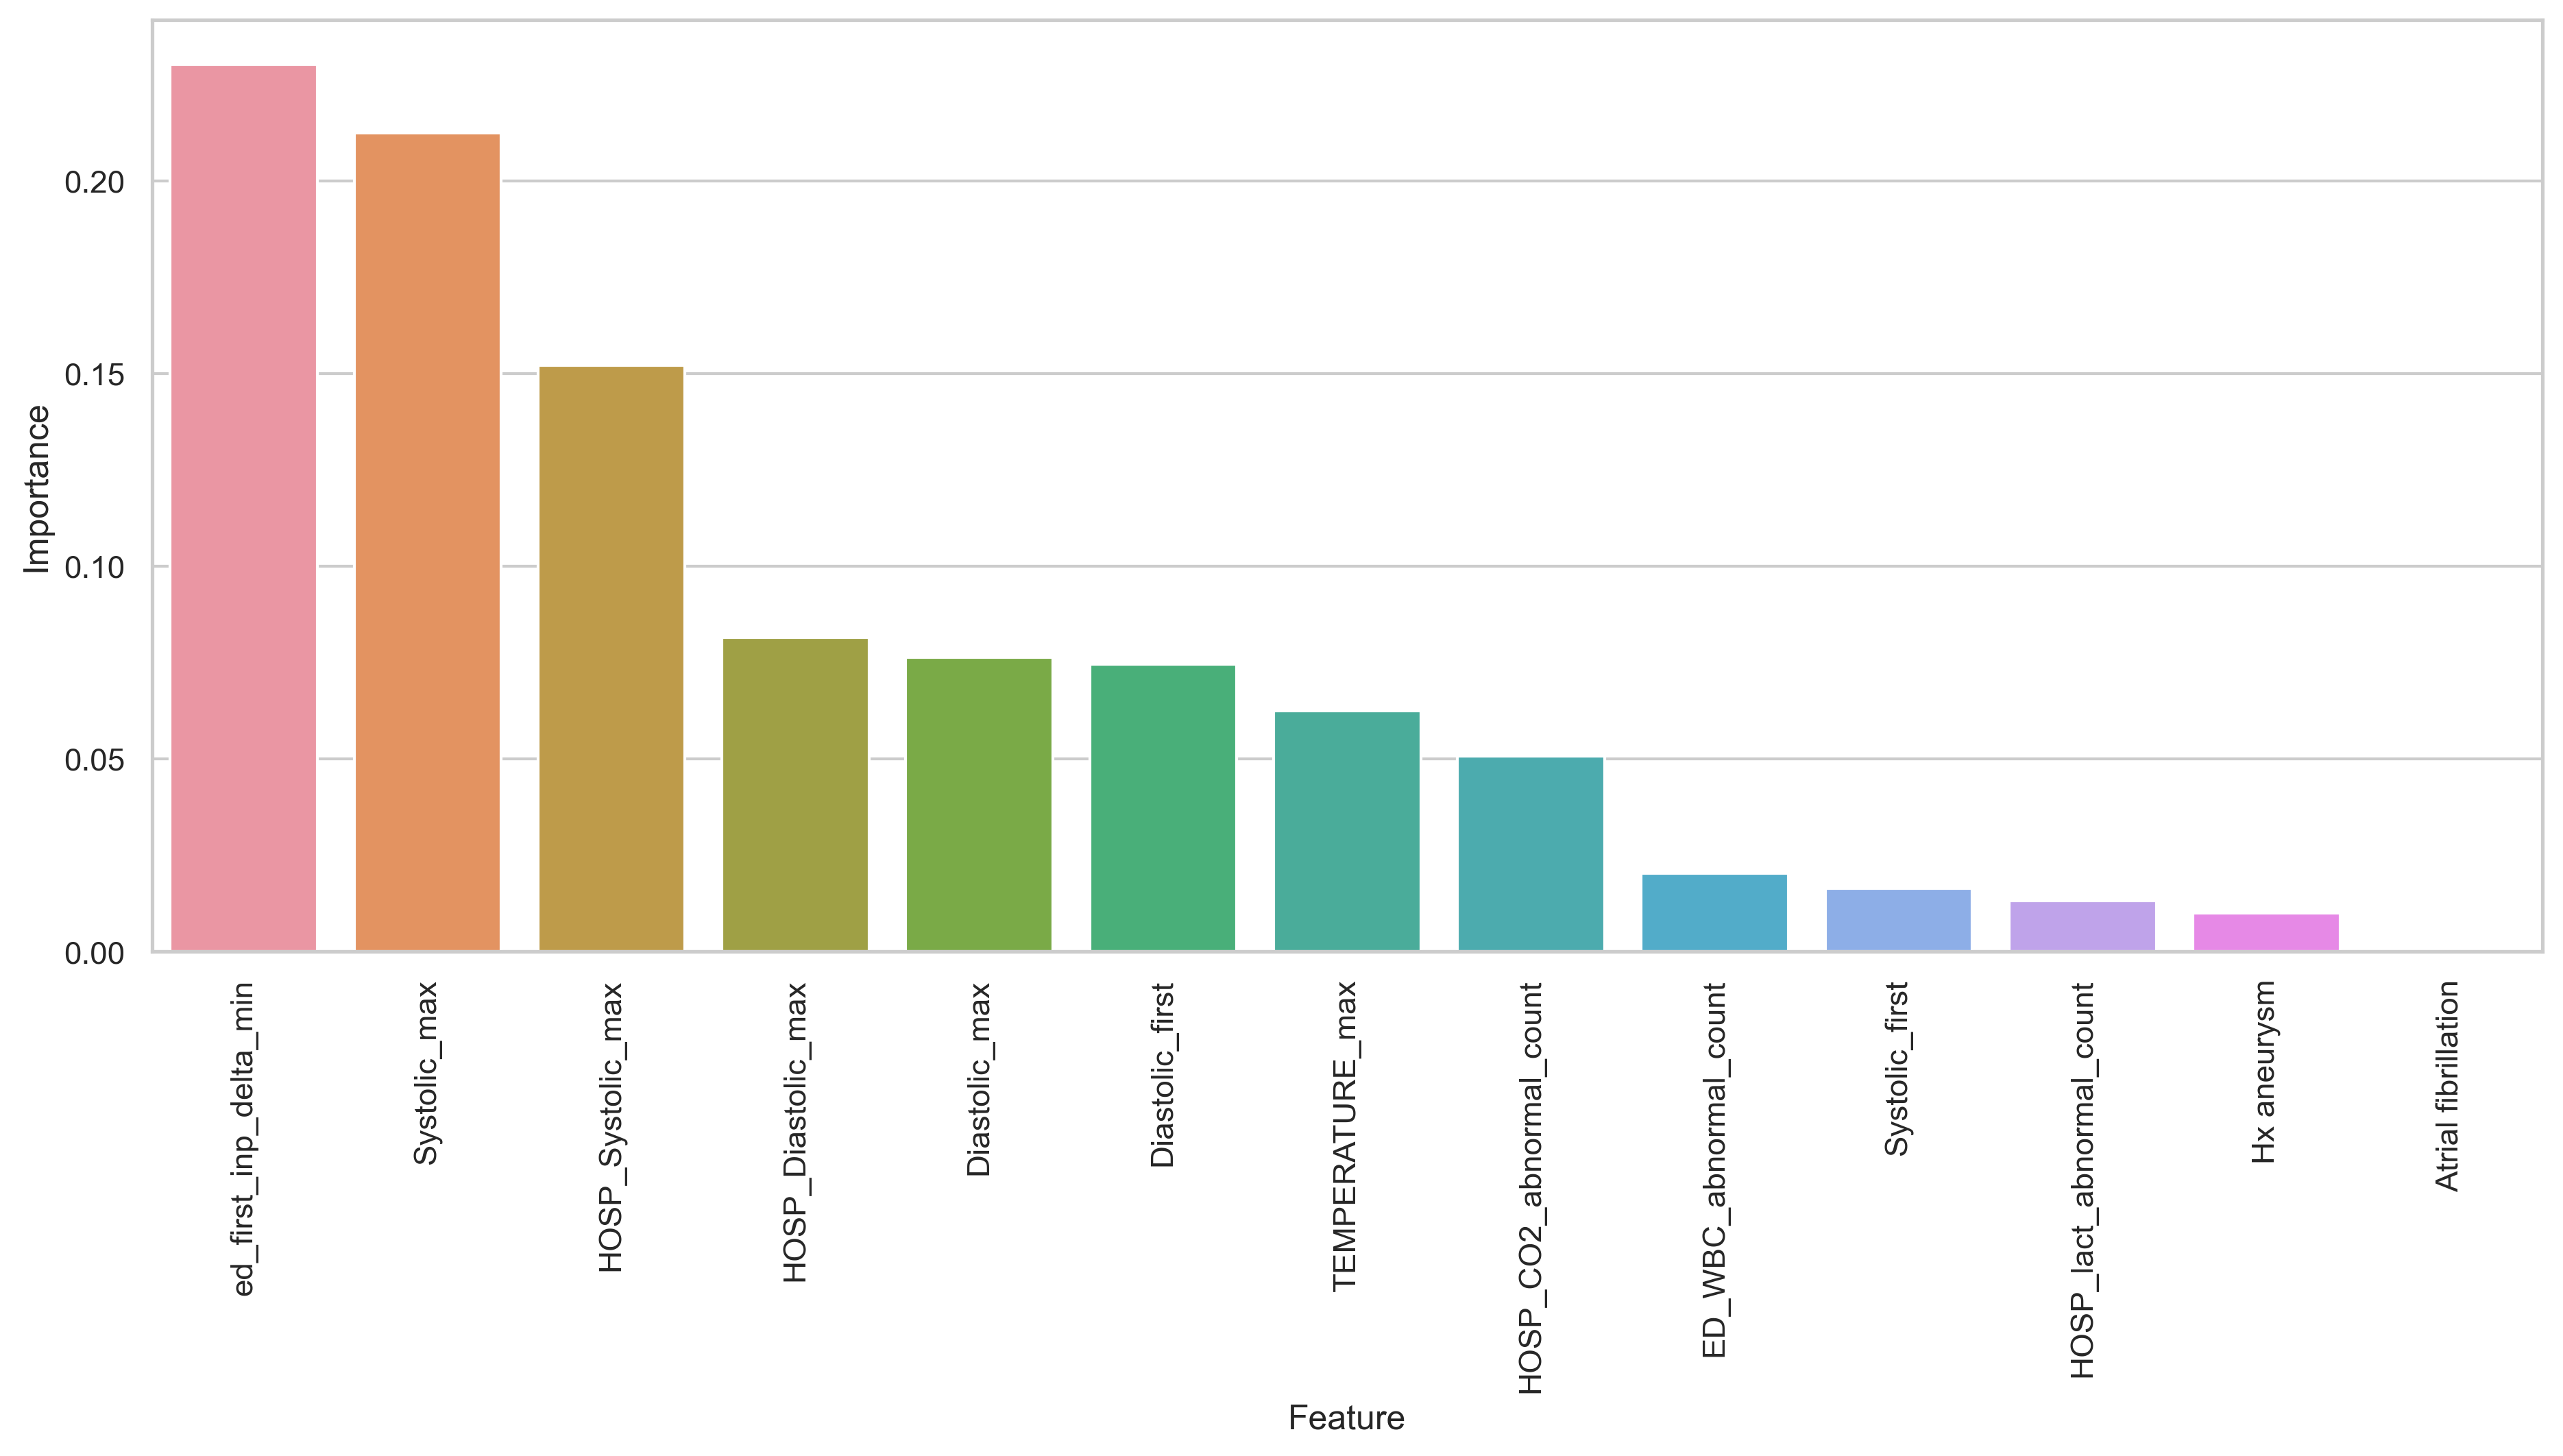

In [104]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5,max_depth=4)

#X = tmp[sig_fields]
X = bin_tmp.iloc[:,1:-1]
yy = bin_tmp['label']

y = np.array([1 if x=='MOD' else 0 for x in yy])
print(X.shape,y.shape)
rf.fit(X,y)

ypred = rf.predict(X)
display(metrics.confusion_matrix(y,ypred))
print('AUC = ',metrics.roc_auc_score(y,ypred), 'F1 = ',metrics.f1_score(y,ypred))
featimp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
featimp = featimp.reset_index()
featimp.columns=['Feature','Importance']
import seaborn as sns

plt.figure(figsize=(15,6))
myplot = sns.barplot(data=featimp, x = "Feature", y = "Importance")
myplot.set_xticklabels(myplot.get_xticklabels(),rotation = 90);

# run 5 fold CV
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=5,max_depth=4)

scores = cross_val_score(rf,X,y,cv=5,scoring='roc_auc')
print(np.mean(scores),np.std(scores))

# Does adding some NE testing features help?


# Using ttest to find significant features

In [66]:
ftypes = 34 *['c'] + 7 * ['d'] + 14*['c']
print(len(ftypes),dizzy_all_labeled_nm.shape)


55 (154, 57)


In [65]:
dizzy_all_labeled_nm.columns[1:-1]

Index(['ed_duration_sum', 'hosp_stay_sum', 'ed_first_inp_delta_min',
       'age_at_index_visit', 'Systolic_max', 'Systolic_min', 'Systolic_first',
       'Diastolic_max', 'Diastolic_min', 'Diastolic_first', 'PULSE_max',
       'PULSE_min', 'PULSE_first', 'TEMPERATURE_max', 'TEMPERATURE_min',
       'TEMPERATURE_first', 'HOSP_Systolic_max', 'HOSP_Systolic_min',
       'HOSP_Systolic_first', 'HOSP_Diastolic_max', 'HOSP_Diastolic_min',
       'HOSP_Diastolic_first', 'HOSP_PULSE_max', 'HOSP_PULSE_min',
       'HOSP_PULSE_first', 'HOSP_TEMPERATURE_max', 'HOSP_TEMPERATURE_min',
       'HOSP_TEMPERATURE_first', 'ED_NEUROLOGY', 'ED_TELEPHONE/NEUROLOGY',
       'HOSP_NEUROLOGY', 'HOSP_TELEPHONE/NEUROLOGY', 'mri_count',
       'hosp_mri_count', 'Atrial fibrillation',
       'Coronary artery disease (CAD)', 'Diabetes', 'Hx of stroke or TIA',
       'Hypertension', 'Occlusion/Stenosis of cerebral or precerebral artery',
       'Hx aneurysm', 'ED_WBC_abnormal_count', 'ED_CO2_count',
       'ED_CO2

In [67]:
# find a subset of the useful features and then UMAP it.
sig_fields = ttest_fields(dizzy_all_labeled_nm,dizzy_all_labeled_nm.columns[1:-1],ftypes,show=False)
sig_fields

['ed_duration_sum',
 'ed_first_inp_delta_min',
 'Systolic_max',
 'Systolic_first',
 'Diastolic_max',
 'Diastolic_first',
 'HOSP_Systolic_max',
 'HOSP_Diastolic_max',
 'Atrial fibrillation',
 'Hx aneurysm',
 'ED_WBC_abnormal_count',
 'HOSP_lact_abnormal_count']

In [84]:
print(sig_fields)
c = dizzy_all_labeled_nm[sig_fields].isnull().sum()
c[c> 10]

['ed_duration_sum', 'ed_first_inp_delta_min', 'CARDIOLOGY', 'NEUROLOGY', 'TELEPHONE/NEUROLOGY', 'Atrial fibrillation', 'Diabetes', 'Hx aneurysm', 'ED_WBC_abnormal_count', 'ED_glucose_count', 'ED_glucose_abnormal_count', 'ED_albumin_abnormal_count', 'ED_calcium_count', 'ED_lact_count', 'ED_troponin_count', 'ED_troponin_abnormal_count', 'ED_ast_abnormal_count', 'ED_alkphos_abnormal_count', 'ED_amylase_count', 'ED_hgb_abnormal_count', 'HOSP_WBC_abnormal_count', 'HOSP_potassium_count', 'HOSP_potassium_abnormal_count', 'HOSP_calcium_abnormal_count', 'HOSP_lact_count', 'HOSP_lact_abnormal_count', 'HOSP_chloride_count', 'HOSP_chloride_abnormal_count', 'HOSP_bun_count', 'HOSP_bun_abnormal_count', 'HOSP_creat_count', 'HOSP_creat_abnormal_count', 'HOSP_CO2_count', 'HOSP_CO2_abnormal_count', 'HOSP_ast_abnormal_count', 'HOSP_alkphos_count', 'HOSP_hgb_count', 'HOSP_hgb_abnormal_count']


Series([], dtype: int64)

In [85]:
print(dizzy_all_labeled_nm[sig_fields].shape)
print(dizzy_all_labeled_nm[sig_fields].dropna().shape)

(79, 38)
(79, 38)


# UMAP dizzy_all
- find ttest significant fields first
- then UMAP the dataset

In [204]:
# drop those fields which have more than 10 values missing
c = dizzy_all_labeled_nm[sig_fields].isnull().sum()
many_nas = list(c[c > 9].index)
print(many_nas)

fewna_fields = [x for x in dizzy_all_labeled_nm.columns[1:] if x not in many_nas ]
dizzy_all_labeled_nm[fewna_fields].dropna().shape

[]


(44, 182)

In [86]:
sirs_fields = ['TEMPERATURE_max','PULSE_max','RESPIRATION_max','HOSP_TEMPERATURE_max','HOSP_PULSE_max']
# what are others?

(68, 44)
(68, 42) (68,)


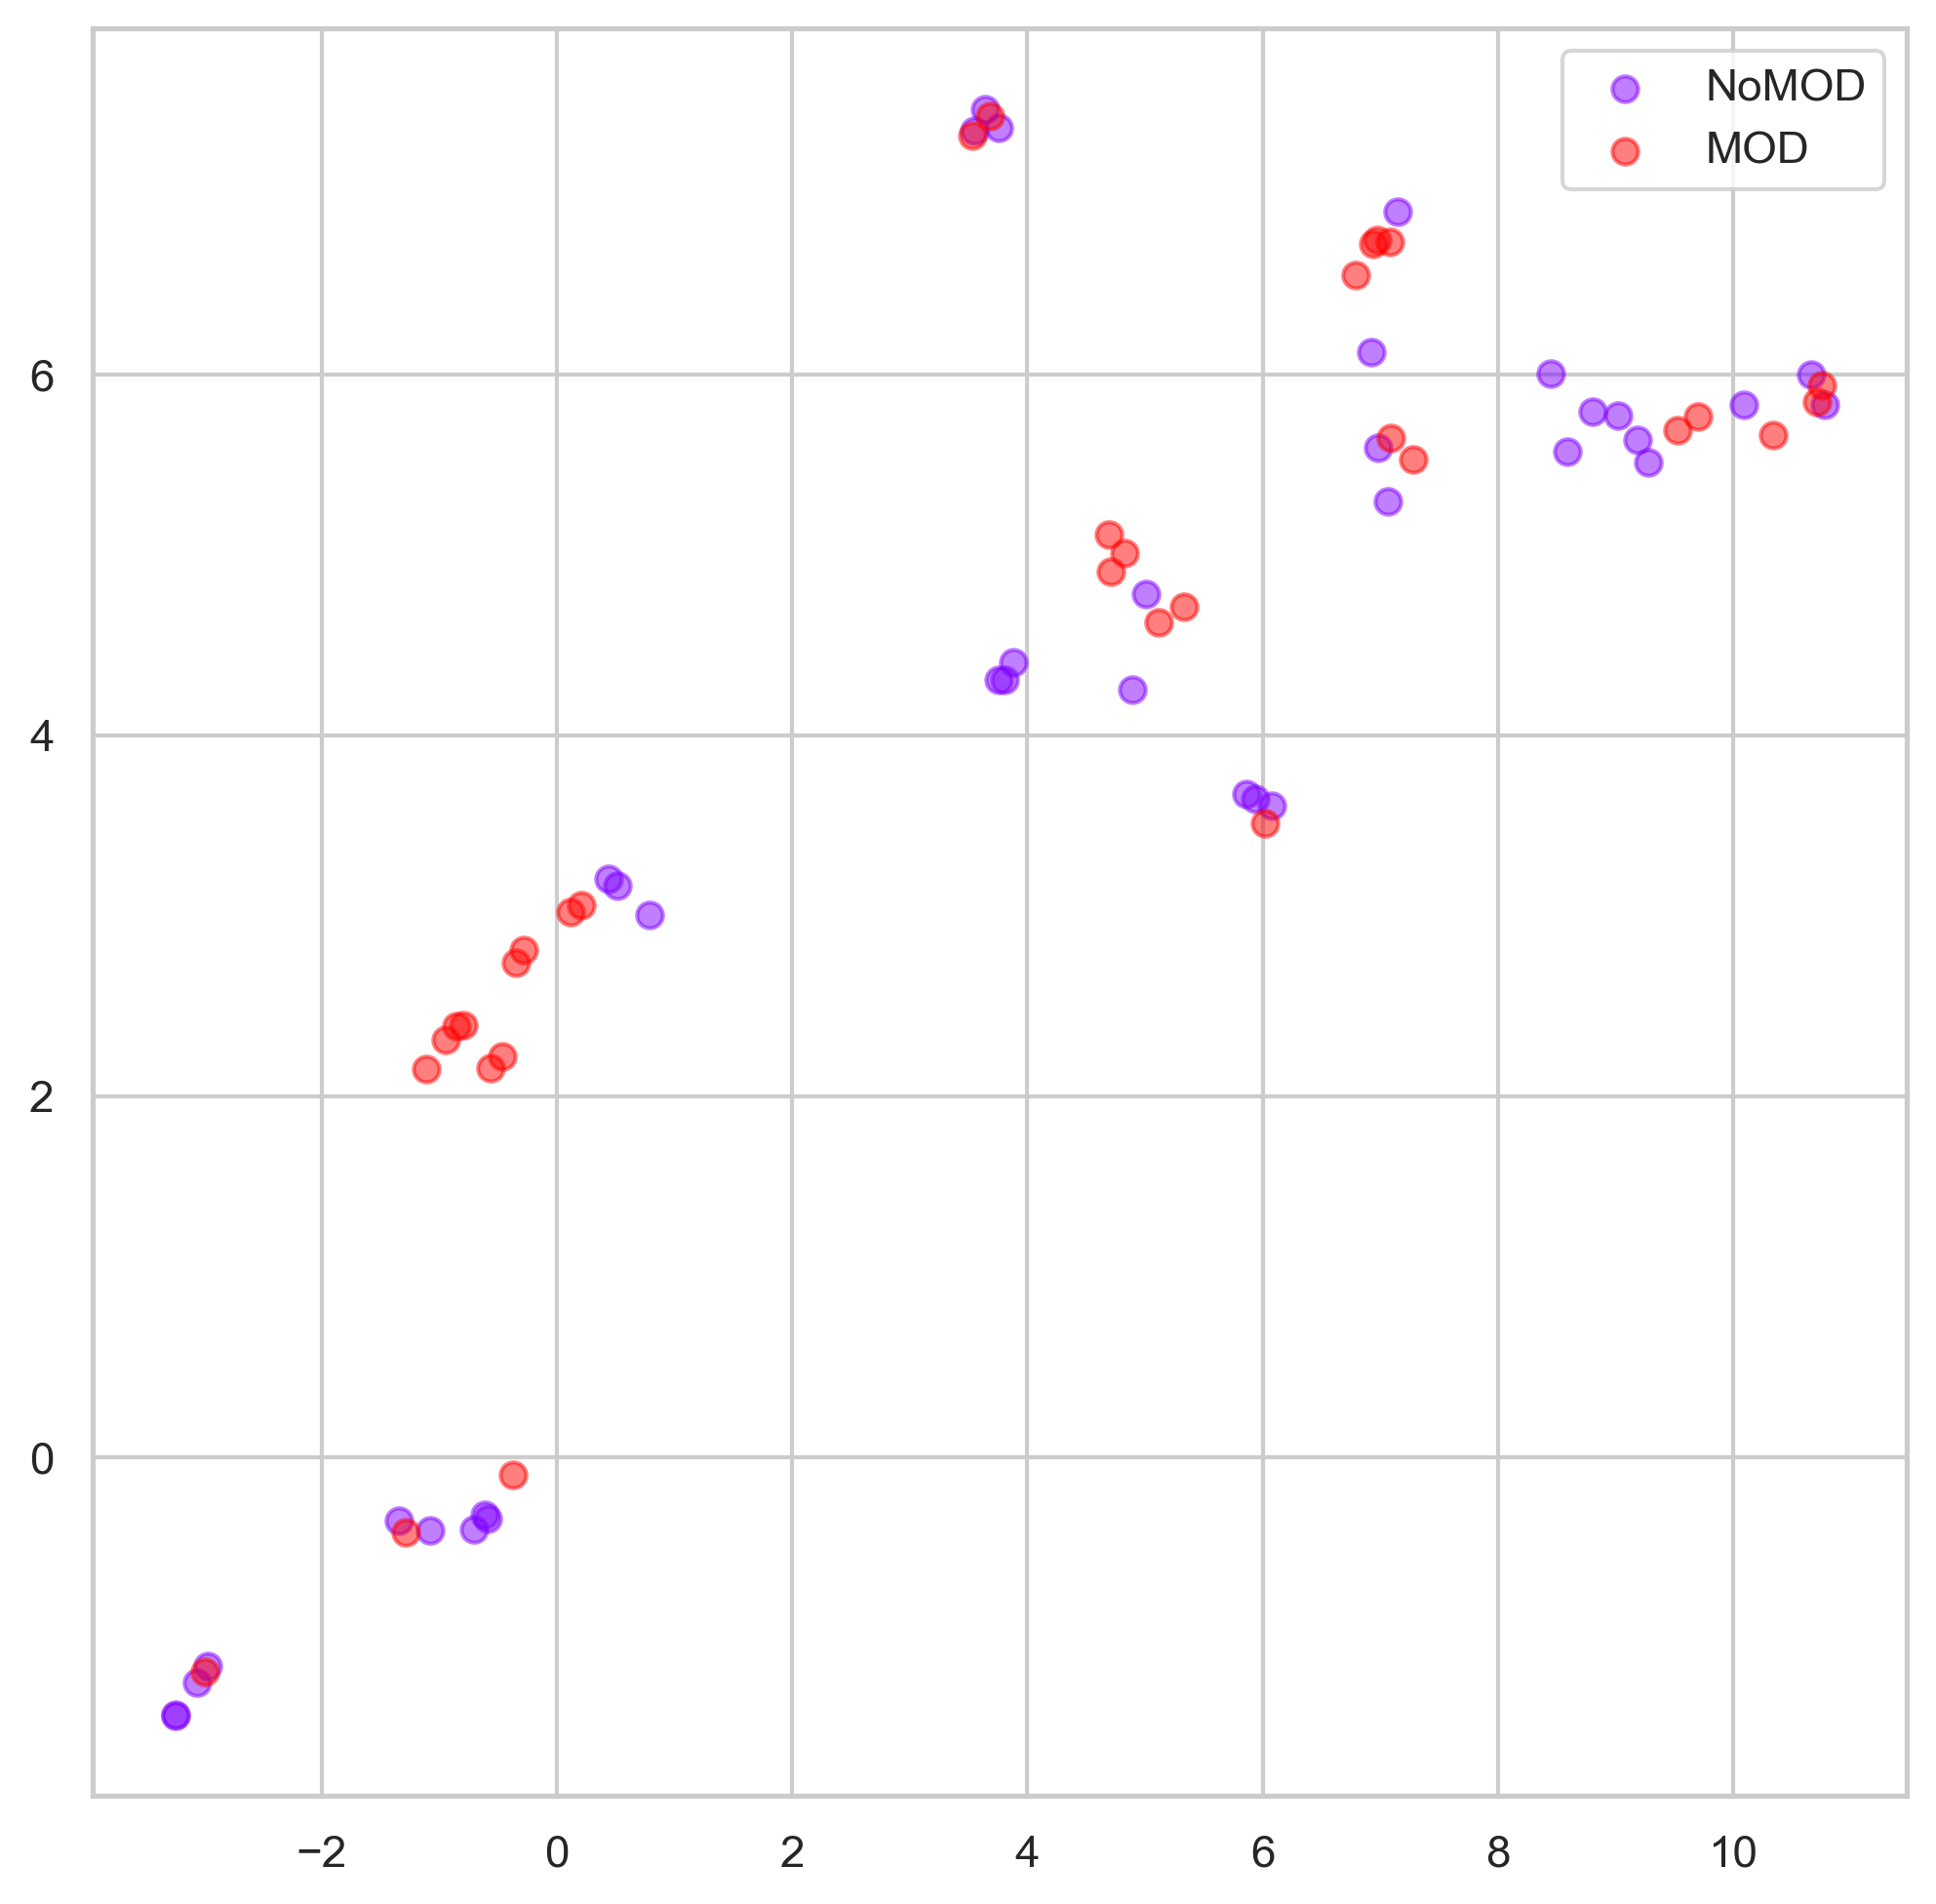

In [110]:
# need to drop NA on dizzy_all_labeled
tmp = dizzy_all_labeled_nm[sig_fields + sirs_fields +  ['label']].dropna()
#tmp = dizzy_all_labeled_nm[fewna_fields].dropna()
print(tmp.shape)

X = tmp.iloc[:,1:-1]
y = tmp['label']

print(X.shape,y.shape)
label_list = list(tmp.label.value_counts().index)
u = umap_plot_label(X,y,1,4,label_list,'upper right');


Cluster  1
NoMOD    3
MOD      2
Name: label, dtype: int64
Cluster  2
NoMOD    9
MOD      3
Name: label, dtype: int64
Cluster  3
NoMOD    9
MOD      5
Name: label, dtype: int64
Cluster  4
NoMOD    8
MOD      6
Name: label, dtype: int64
Cluster  5
MOD      10
NoMOD     3
Name: label, dtype: int64
Cluster  6
MOD      6
NoMOD    4
Name: label, dtype: int64
median statistics of cluster  1
NoMOD    3
MOD      2
Name: label, dtype: int64


ed_duration_sum                   3.410556
ed_first_inp_delta_min            4.402697
CARDIOLOGY                        0.000000
NEUROLOGY                         0.000000
TELEPHONE/NEUROLOGY               0.000000
Atrial fibrillation               0.000000
Diabetes                          0.000000
Hx aneurysm                       0.000000
ED_WBC_abnormal_count             0.000000
ED_glucose_count                  1.000000
ED_glucose_abnormal_count         1.000000
ED_albumin_abnormal_count         0.000000
ED_calcium_count                  1.000000
ED_lact_count                     0.000000
ED_troponin_count                 0.000000
ED_troponin_abnormal_count        0.000000
ED_ast_abnormal_count             0.000000
ED_alkphos_abnormal_count         0.000000
ED_amylase_count                  0.000000
ED_hgb_abnormal_count             1.000000
HOSP_WBC_abnormal_count           0.000000
HOSP_potassium_count              2.000000
HOSP_potassium_abnormal_count     1.000000
HOSP_calciu

median statistics of cluster  2
NoMOD    9
MOD      3
Name: label, dtype: int64


ed_duration_sum                   5.277222
ed_first_inp_delta_min           21.377431
CARDIOLOGY                        0.000000
NEUROLOGY                         0.000000
TELEPHONE/NEUROLOGY               0.000000
Atrial fibrillation               0.000000
Diabetes                          1.000000
Hx aneurysm                       0.000000
ED_WBC_abnormal_count             0.000000
ED_glucose_count                  1.000000
ED_glucose_abnormal_count         1.000000
ED_albumin_abnormal_count         0.000000
ED_calcium_count                  1.000000
ED_lact_count                     0.000000
ED_troponin_count                 0.000000
ED_troponin_abnormal_count        0.000000
ED_ast_abnormal_count             0.000000
ED_alkphos_abnormal_count         0.000000
ED_amylase_count                  0.000000
ED_hgb_abnormal_count             0.000000
HOSP_WBC_abnormal_count           0.000000
HOSP_potassium_count              1.000000
HOSP_potassium_abnormal_count     0.000000
HOSP_calciu

median statistics of cluster  3
NoMOD    9
MOD      5
Name: label, dtype: int64


ed_duration_sum                   4.373472
ed_first_inp_delta_min           10.415619
CARDIOLOGY                        0.000000
NEUROLOGY                         0.000000
TELEPHONE/NEUROLOGY               0.000000
Atrial fibrillation               0.000000
Diabetes                          1.000000
Hx aneurysm                       0.000000
ED_WBC_abnormal_count             0.000000
ED_glucose_count                  1.000000
ED_glucose_abnormal_count         1.000000
ED_albumin_abnormal_count         0.000000
ED_calcium_count                  1.000000
ED_lact_count                     0.000000
ED_troponin_count                 0.000000
ED_troponin_abnormal_count        0.000000
ED_ast_abnormal_count             0.000000
ED_alkphos_abnormal_count         0.000000
ED_amylase_count                  0.000000
ED_hgb_abnormal_count             0.000000
HOSP_WBC_abnormal_count           0.000000
HOSP_potassium_count              2.000000
HOSP_potassium_abnormal_count     0.000000
HOSP_calciu

median statistics of cluster  4
NoMOD    8
MOD      6
Name: label, dtype: int64


ed_duration_sum                   4.075139
ed_first_inp_delta_min            8.828490
CARDIOLOGY                        0.000000
NEUROLOGY                         0.000000
TELEPHONE/NEUROLOGY               0.000000
Atrial fibrillation               0.000000
Diabetes                          1.000000
Hx aneurysm                       0.000000
ED_WBC_abnormal_count             0.000000
ED_glucose_count                  1.000000
ED_glucose_abnormal_count         1.000000
ED_albumin_abnormal_count         0.000000
ED_calcium_count                  1.000000
ED_lact_count                     0.000000
ED_troponin_count                 0.000000
ED_troponin_abnormal_count        0.000000
ED_ast_abnormal_count             0.000000
ED_alkphos_abnormal_count         0.000000
ED_amylase_count                  0.000000
ED_hgb_abnormal_count             0.000000
HOSP_WBC_abnormal_count           0.000000
HOSP_potassium_count              7.000000
HOSP_potassium_abnormal_count     0.000000
HOSP_calciu

median statistics of cluster  5
MOD      10
NoMOD     3
Name: label, dtype: int64


ed_duration_sum                   3.030833
ed_first_inp_delta_min            7.877546
CARDIOLOGY                        0.000000
NEUROLOGY                         0.000000
TELEPHONE/NEUROLOGY               0.000000
Atrial fibrillation               0.000000
Diabetes                          0.000000
Hx aneurysm                       0.000000
ED_WBC_abnormal_count             0.000000
ED_glucose_count                  1.000000
ED_glucose_abnormal_count         1.000000
ED_albumin_abnormal_count         0.000000
ED_calcium_count                  1.000000
ED_lact_count                     0.000000
ED_troponin_count                 0.000000
ED_troponin_abnormal_count        0.000000
ED_ast_abnormal_count             0.000000
ED_alkphos_abnormal_count         0.000000
ED_amylase_count                  0.000000
ED_hgb_abnormal_count             0.000000
HOSP_WBC_abnormal_count           0.000000
HOSP_potassium_count              3.000000
HOSP_potassium_abnormal_count     0.000000
HOSP_calciu

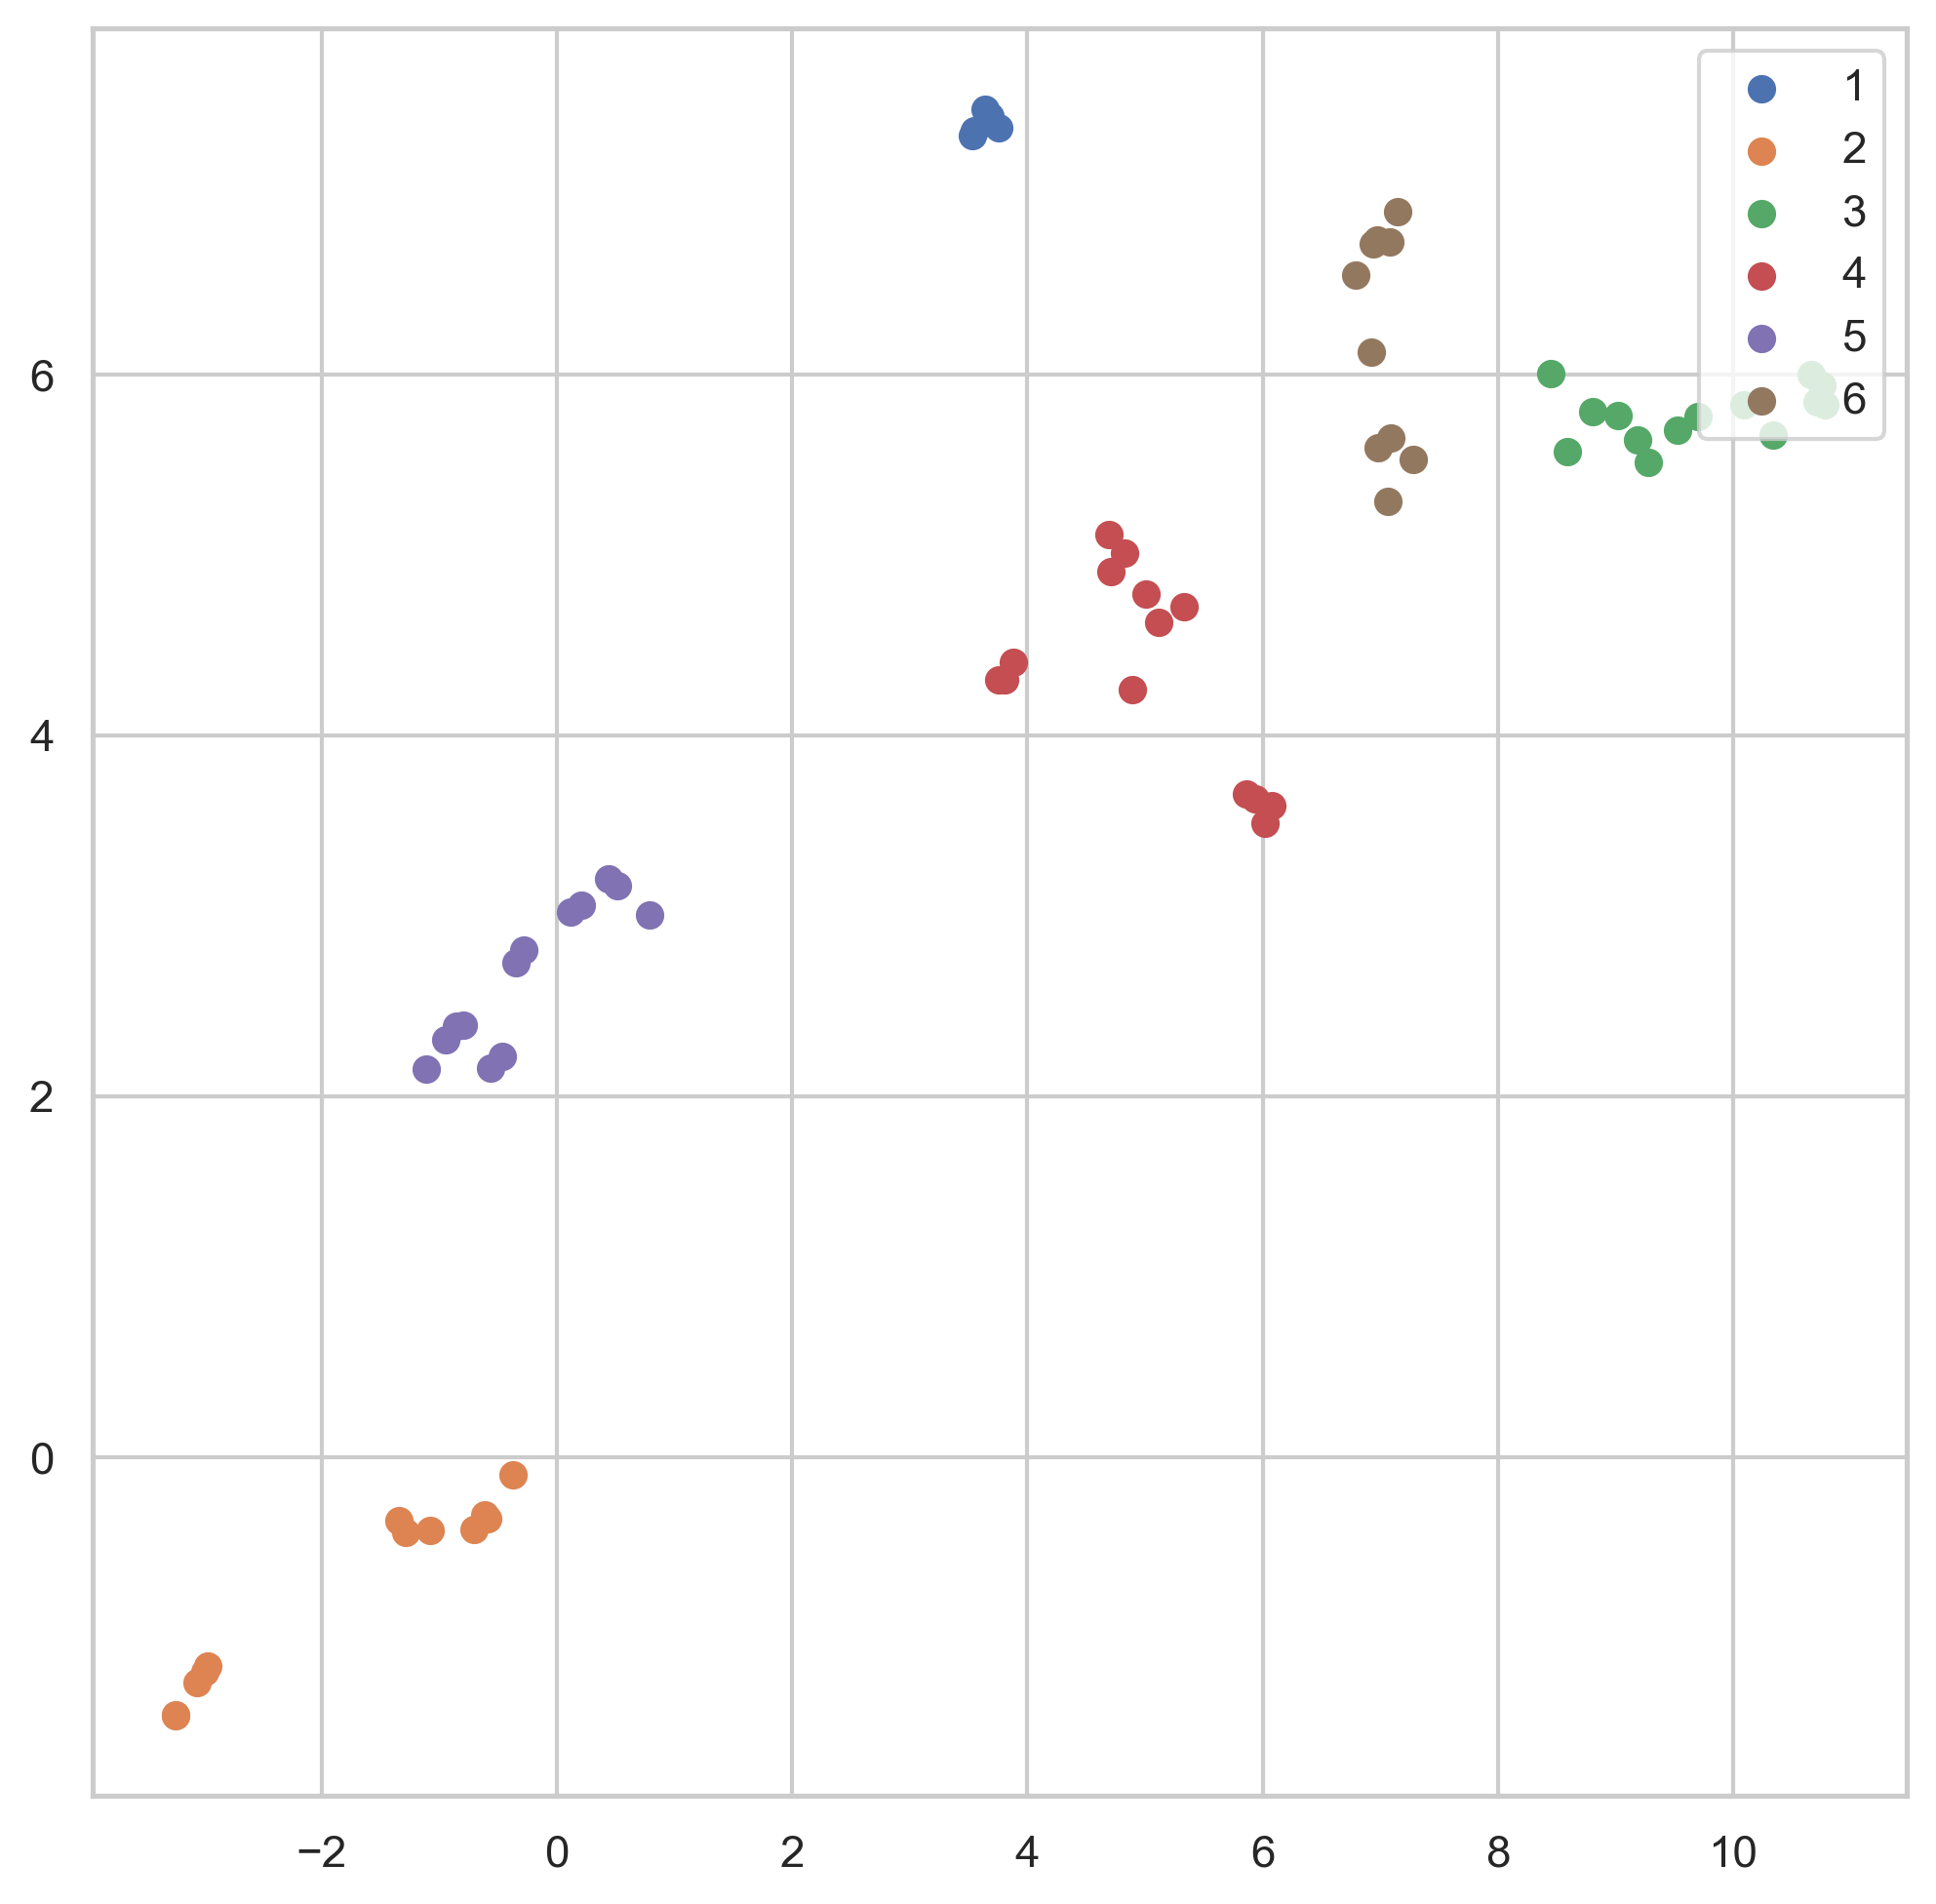

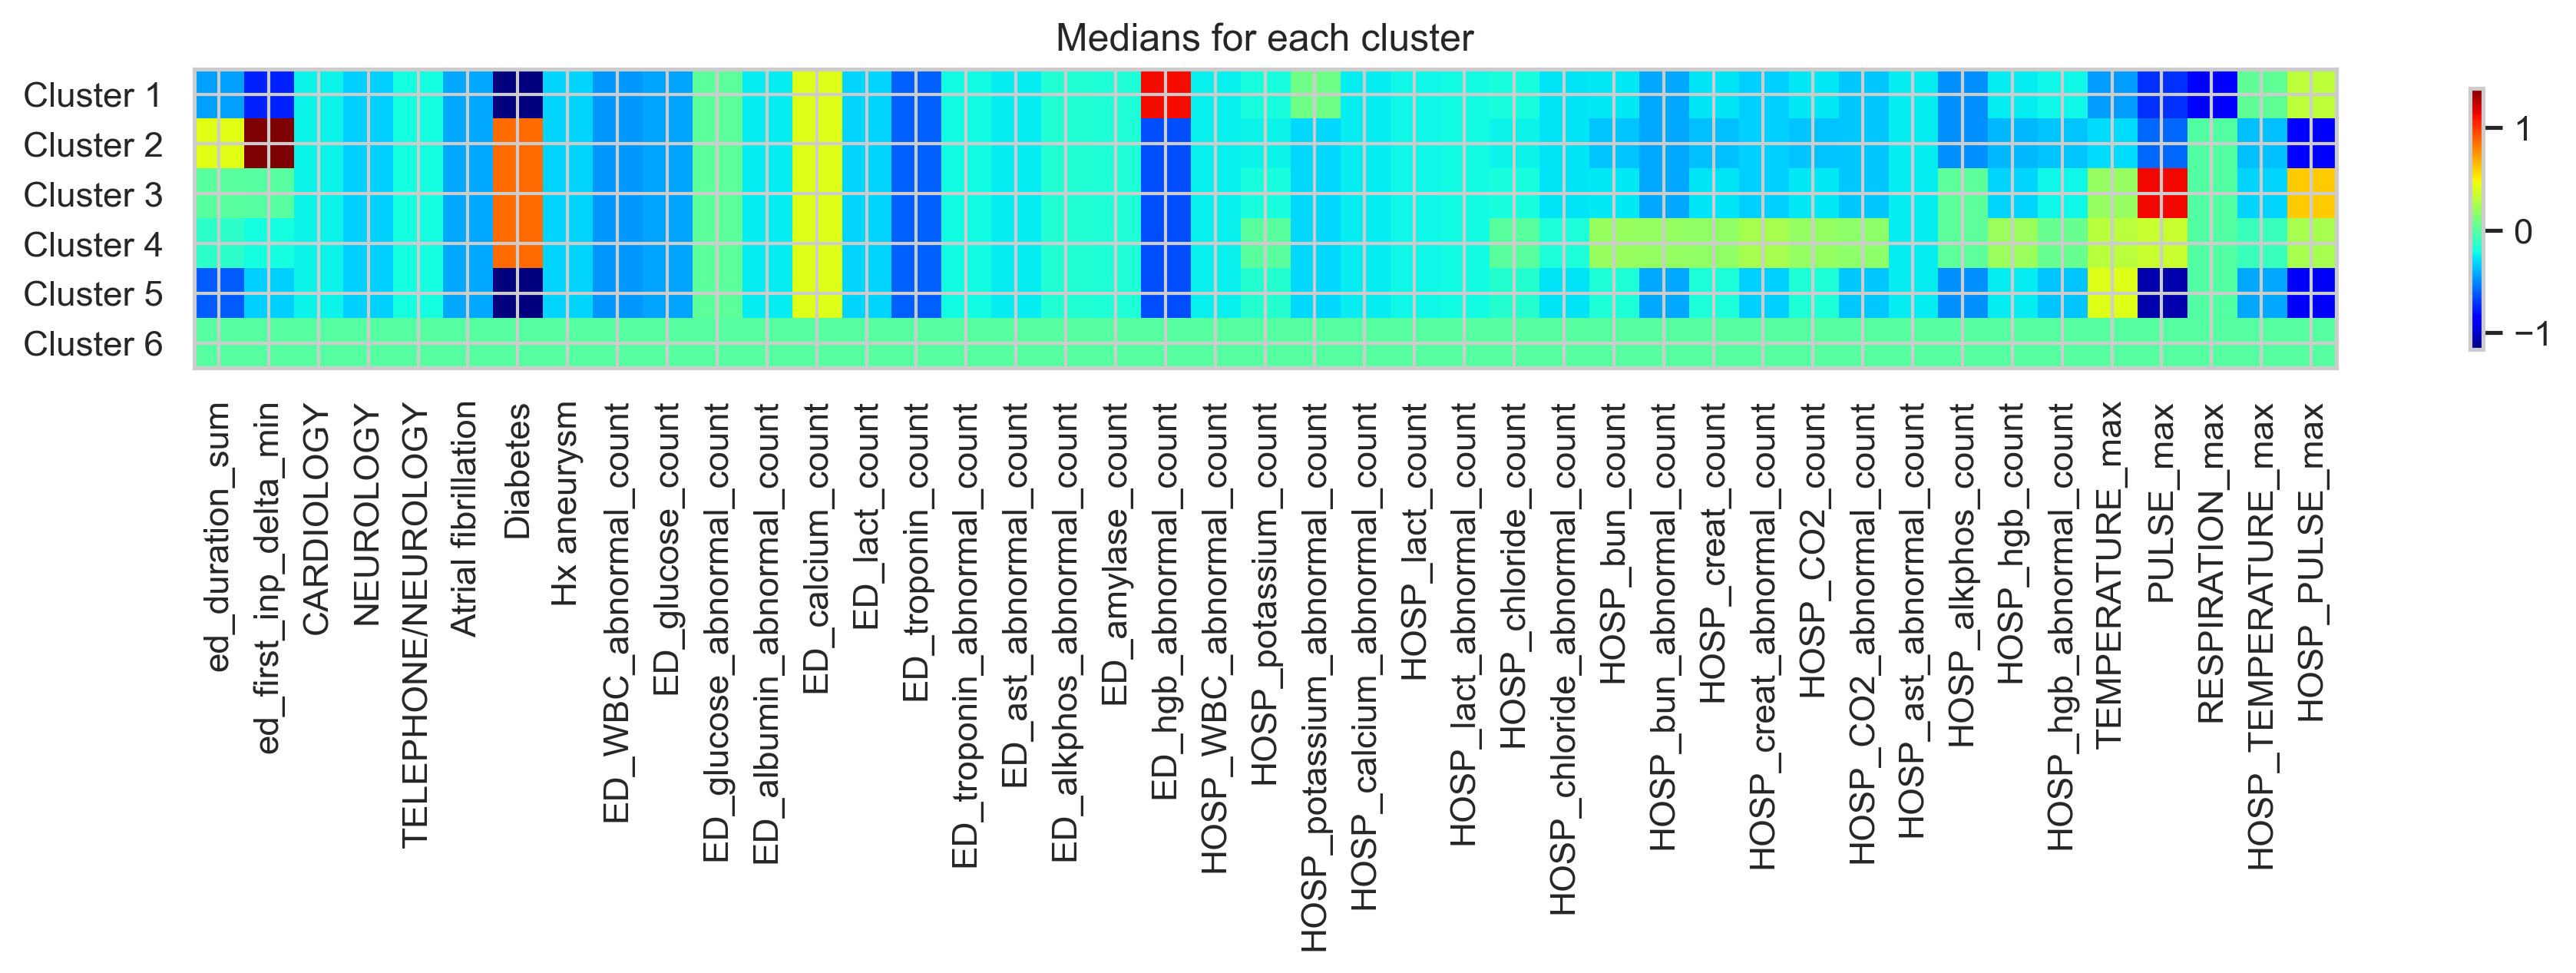

In [93]:
clust = cluster_umap(u,6,tmp[sig_fields+sirs_fields + ['label']],'upper right')
analyze_clusters(clust,tmp[sig_fields+sirs_fields+['label']],sig_fields+sirs_fields) 
#clust = cluster_umap(u,5,tmp,'upper left')
#analyze_clusters(clust,tmp,tmp.columns[1:-1]) 

(68, 42) (68,)
Best C =  0.07880462815669913
(68, 42) (68,)
AUC =  0.6941326530612244 0.22870128367160092
F1 =  0.6954670329670329 0.21114945679470146
Accuracy =  0.7043956043956044 0.19884948635195643
Confusion matrix:
[[27  9]
 [ 8 24]]
7  features chosen by L1 model.


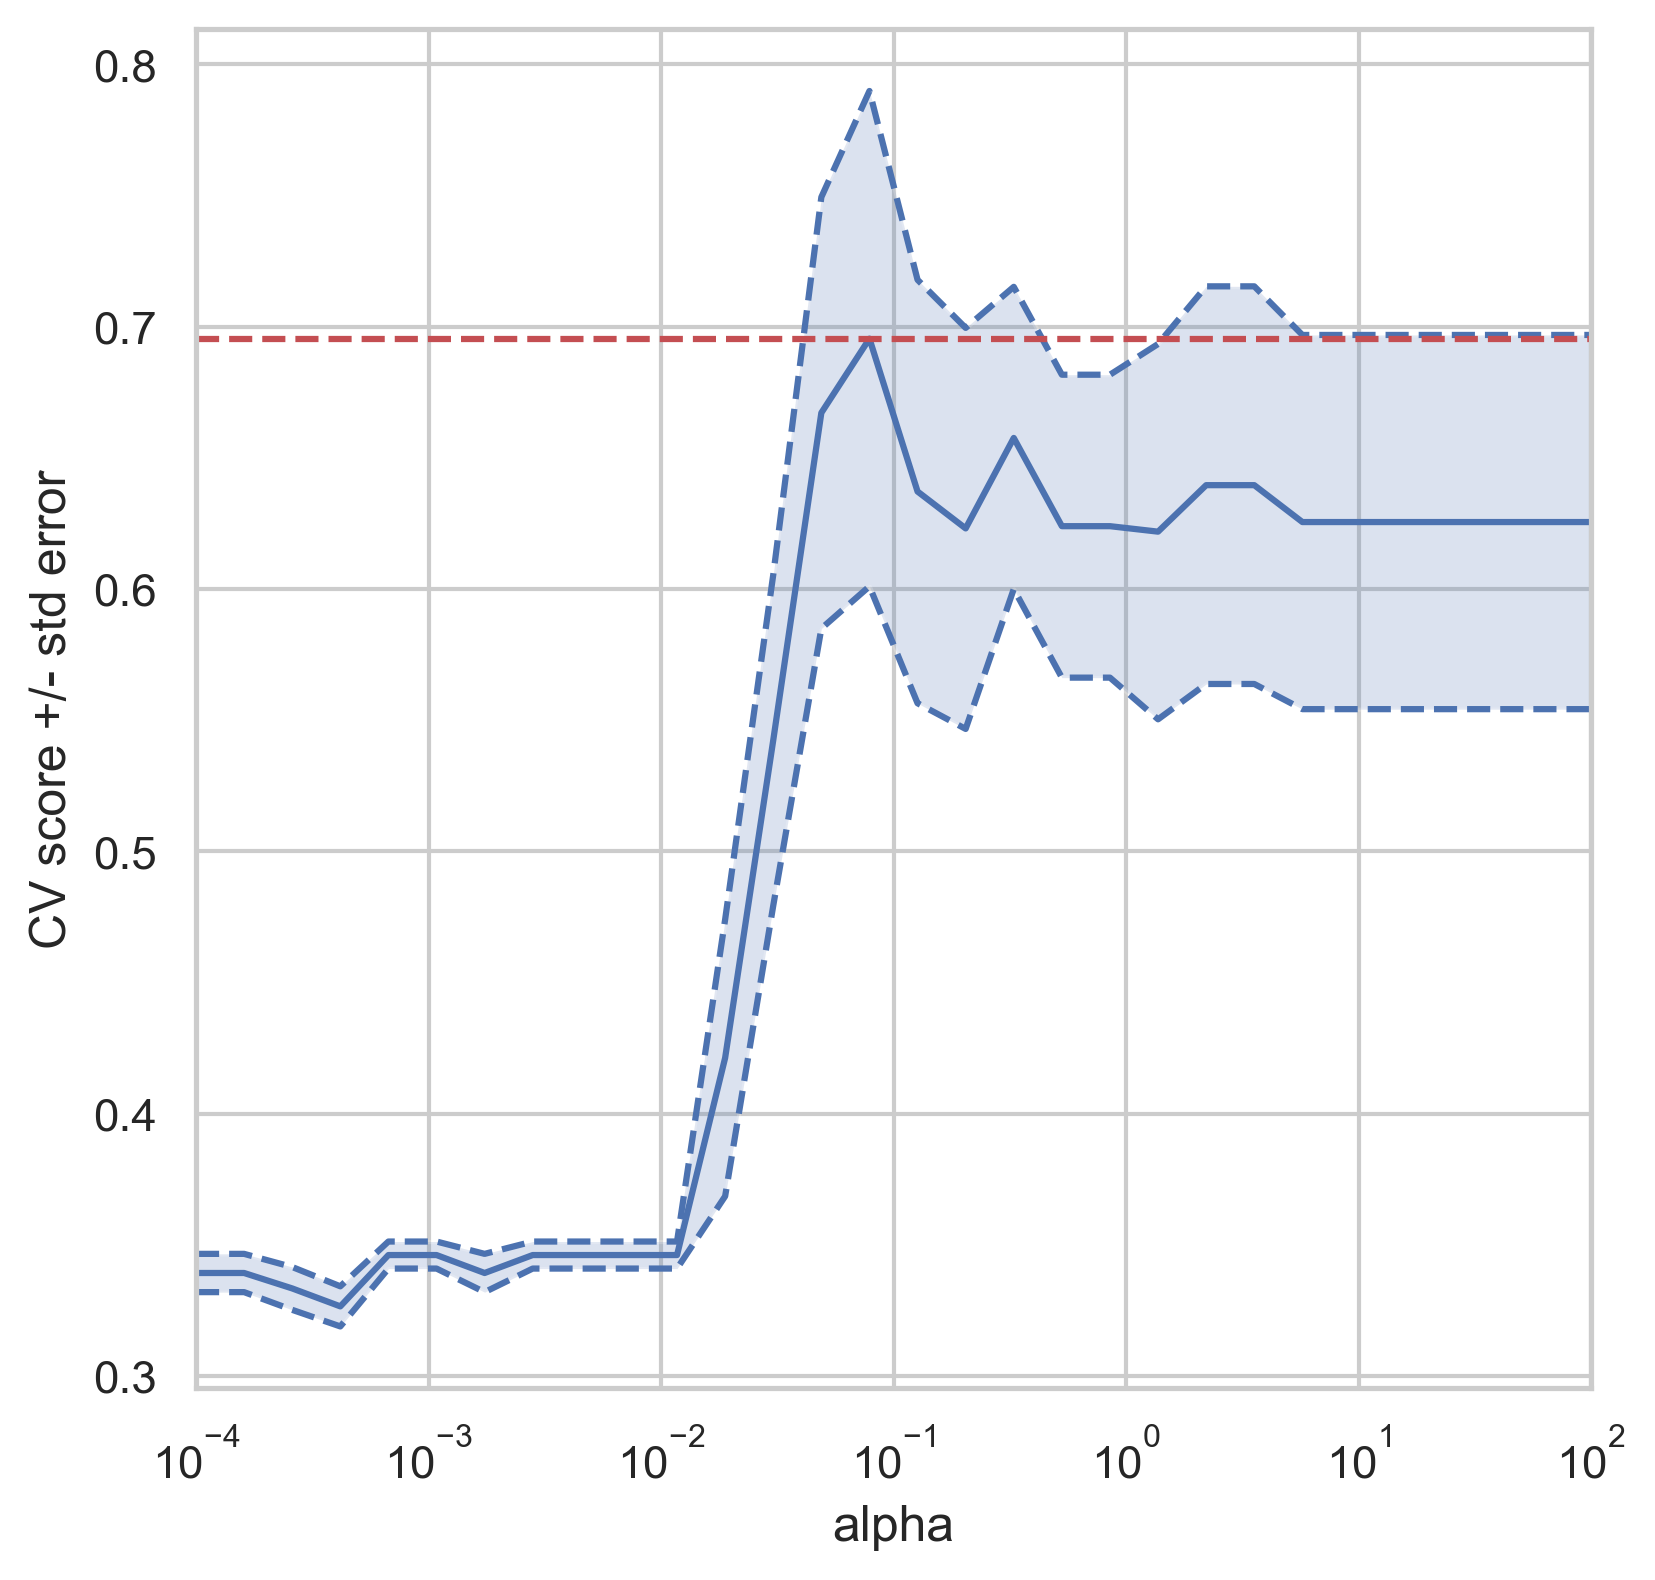

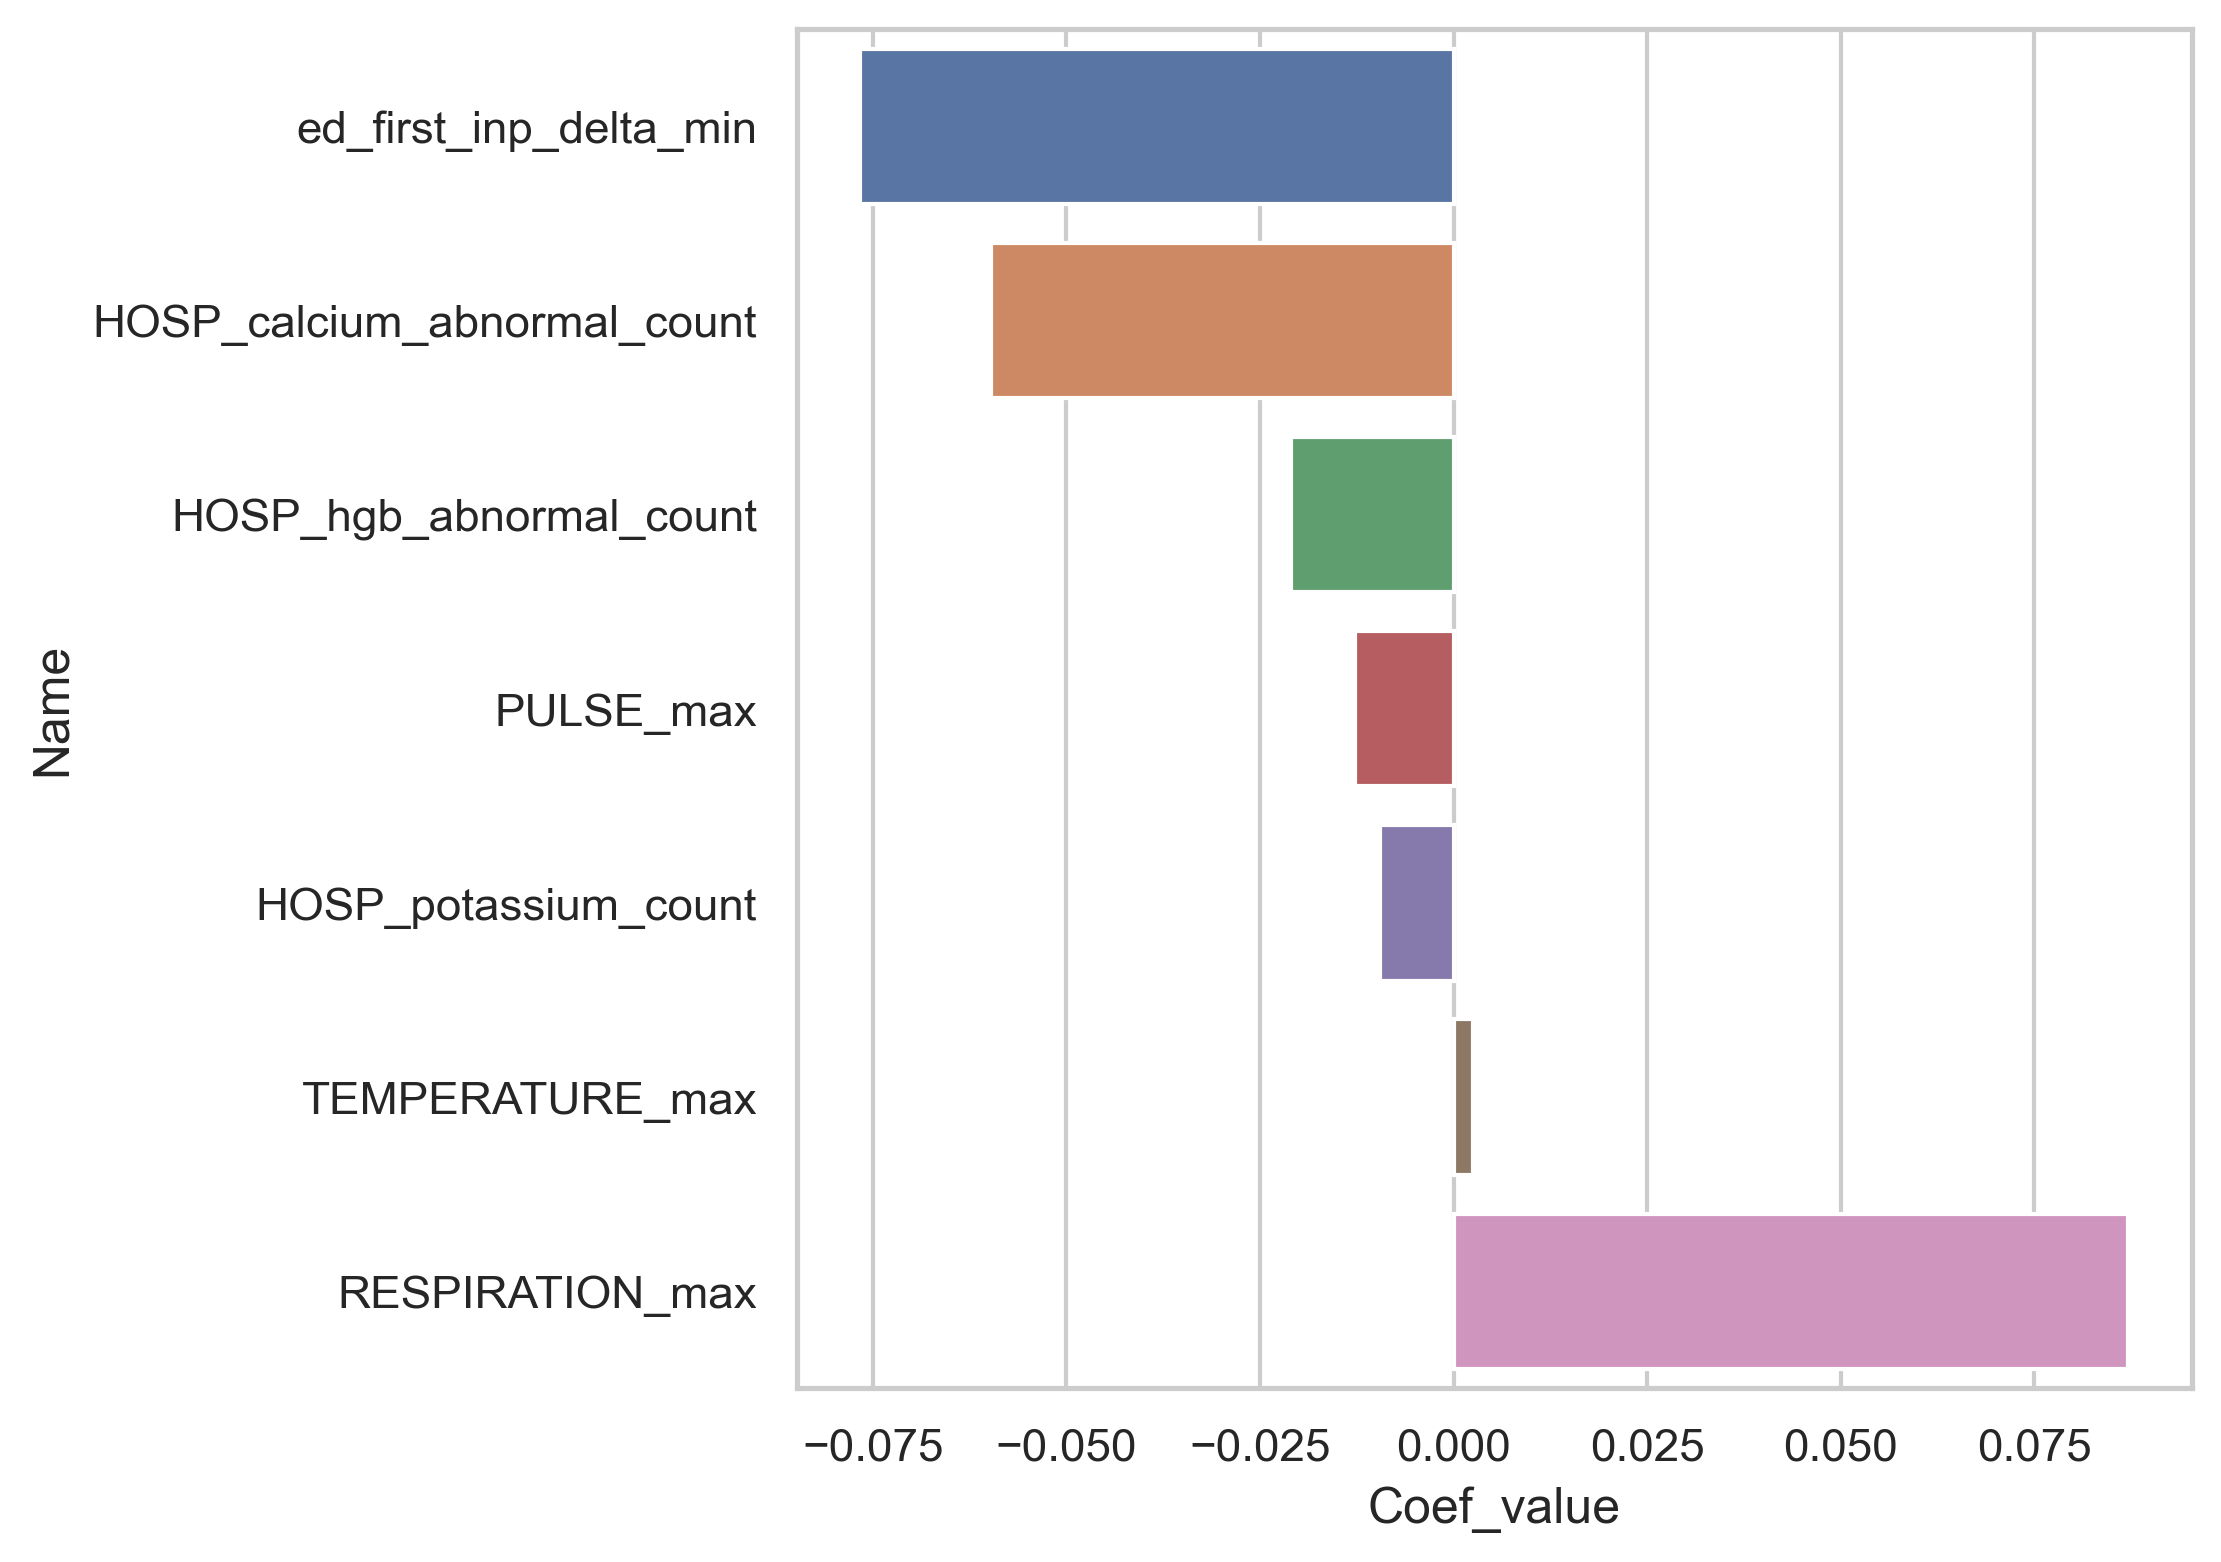

In [94]:
# a logistic regression model on ttest selected features
X = tmp.iloc[:,1:-1]
yy = tmp['label']
y = np.array([1 if (x=='MOD') else 0 for x in yy])
print(X.shape,y.shape)
clf = tune_model(X,y)
print('Best C = ',clf.best_params_['C'])

logreg, select_feats = build_L1_model(X,y,clf.best_params_['C'])
plt.figure()
visualize_model(logreg,select_feats)

array([[31,  5],
       [ 2, 30]], dtype=int64)

AUC =  0.8993055555555556 F1 =  0.8955223880597014


C:\Users\VHAHOUSubraD\Miniconda3\envs\ahrq\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


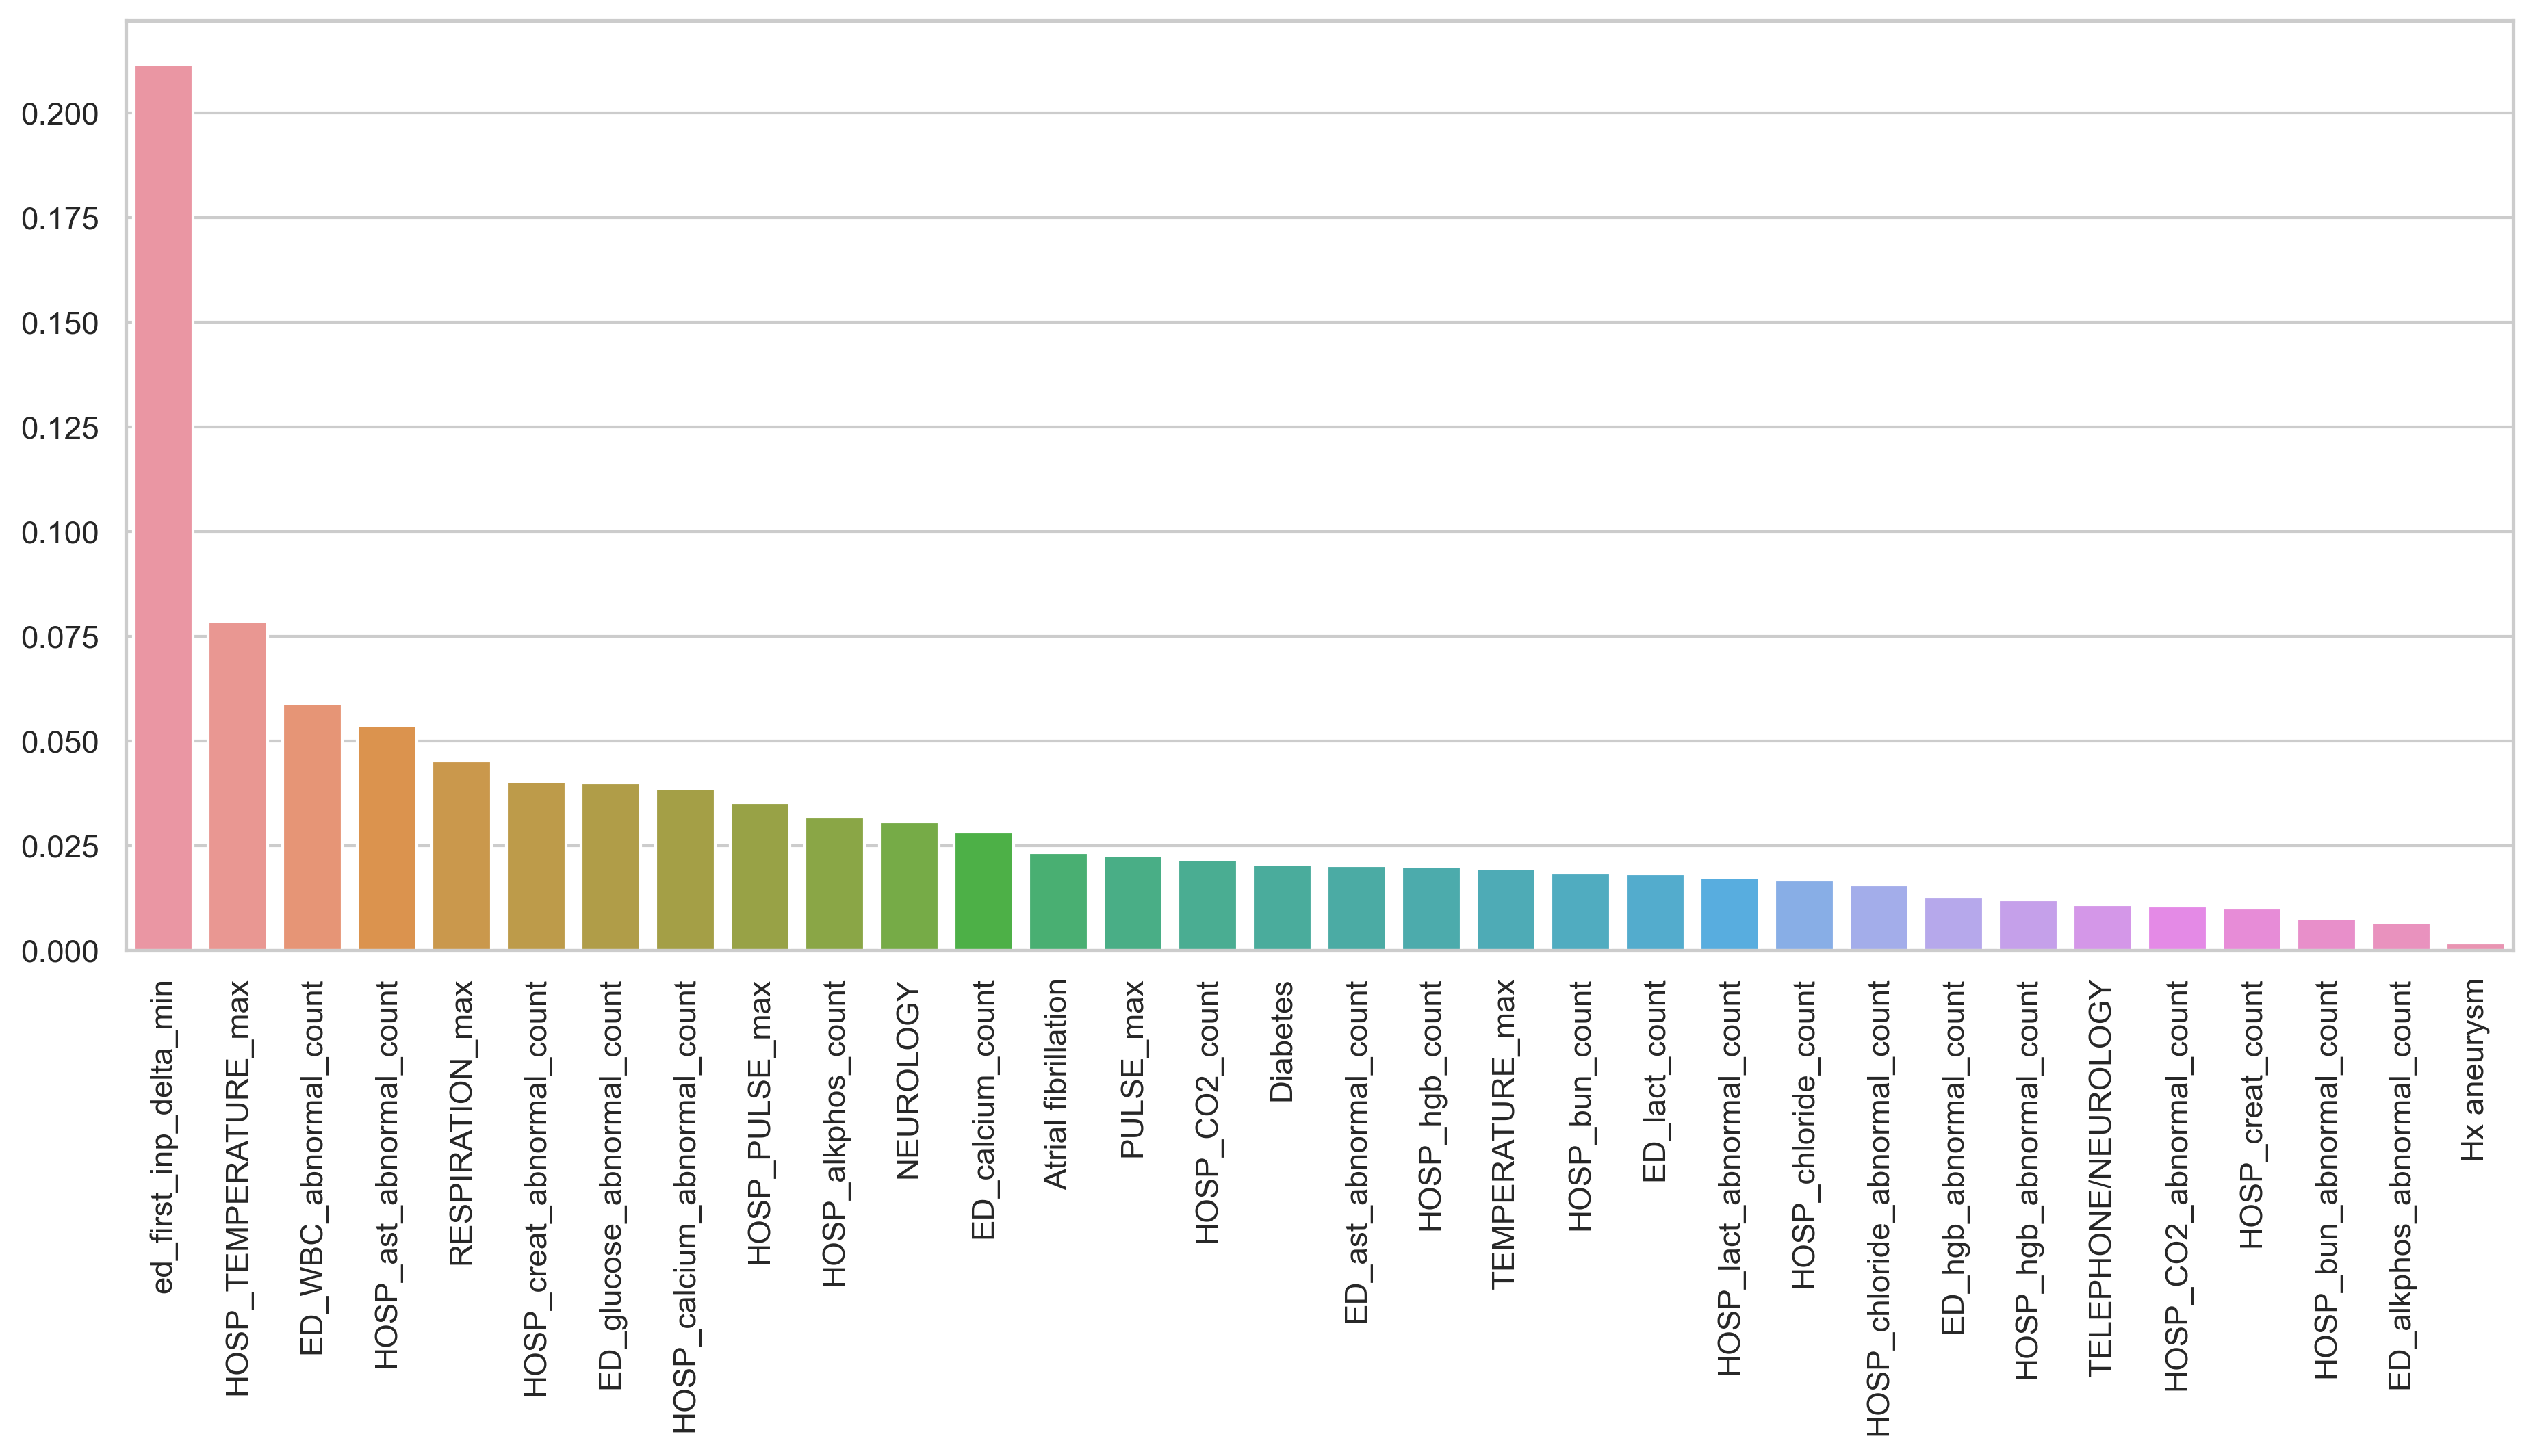

In [95]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10,max_depth=4)

#X = tmp[sig_fields]
X = tmp.iloc[:,1:-1]
yy = tmp['label']

y = np.array([1 if x=='MOD' else 0 for x in yy])
rf.fit(X,y)

ypred = rf.predict(X)
display(metrics.confusion_matrix(y,ypred))
print('AUC = ',metrics.roc_auc_score(y,ypred), 'F1 = ',metrics.f1_score(y,ypred))
featimp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
import seaborn as sns

plt.figure(figsize=(15,6))
myplot = sns.barplot(featimp[featimp.values > 0].index,featimp[featimp.values > 0].values)
myplot.set_xticklabels(myplot.get_xticklabels(),rotation = 90);

In [113]:
# run 5 fold CV
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=10,max_depth=4)

scores = cross_val_score(rf,X,y,cv=5,scoring='roc_auc')
print(np.mean(scores),np.std(scores))

0.6729591836734693 0.08558934312424323


In [109]:
# get the confusion matrix for each fold
from sklearn.model_selection import KFold

tmp = dizzy_all_labeled_nm[sig_fields + sirs_fields +  ['label']].dropna()
print(tmp.shape)
print(tmp.label.value_counts())
X = tmp.iloc[:,1:-1]
y = tmp['label']


kf = KFold(n_splits=5)
cms = np.zeros((2,2))
for train_index, test_index in kf.split(X,y):
    Xtrain,Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain,ytest = y.iloc[train_index],y.iloc[test_index]
    #print(Xtrain.shape,Xtest.shape,ytrain.shape,ytest.shape)
    # train model
    rf = RandomForestClassifier(n_estimators=10,max_depth=4)
    rf.fit(Xtrain,ytrain)
    ypred = rf.predict(Xtest)
    cm = metrics.confusion_matrix(ytest,ypred)
    cms = cms + cm
    
print(cms)

(68, 44)
NoMOD    36
MOD      32
Name: label, dtype: int64
[[18. 14.]
 [21. 15.]]


In [68]:
32/38

0.8421052631578947

In [129]:
dizzy_labels_df.label.value_counts()

NoMOD       44
MOD         38
PMOD        12
CodingEr     6
Name: label, dtype: int64

In [130]:
dizzy_all_labeled_nm.label.value_counts()

NoMOD    41
MOD      38
Name: label, dtype: int64

In [132]:
s1 = dizzy_labels_df[dizzy_labels_df.label=='NoMOD'].PtSSN
s2 = dizzy_all_labeled_nm[dizzy_all_labeled_nm.label=='NoMOD'].PtSSN
set(s1).difference(set(s2))

{358403554, 479520409, 580966577}

In [136]:
38/79

0.4810126582278481

In [138]:
# use logistic regression with features called important by random forest
rf_features = featimp[featimp.values > 0].index
rf_features

Index(['ed_first_inp_delta_min', 'HOSP_hgb_abnormal_count',
       'ED_glucose_abnormal_count', 'HOSP_calcium_abnormal_count',
       'ED_WBC_abnormal_count', 'Hx aneurysm', 'ED_alkphos_abnormal_count',
       'Atrial fibrillation', 'HOSP_potassium_abnormal_count',
       'HOSP_hgb_count', 'ED_hgb_abnormal_count',
       'HOSP_chloride_abnormal_count', 'Diabetes', 'ED_lact_count',
       'HOSP_lact_abnormal_count', 'HOSP_ast_abnormal_count',
       'HOSP_WBC_abnormal_count', 'CARDIOLOGY'],
      dtype='object')

(79, 18) (79,)
Best C =  0.12689610031679222
(79, 18) (79,)
AUC =  0.7426587301587302 0.15961131600062775
F1 =  0.6641296680615566 0.13988791237629655
Accuracy =  0.6683333333333333 0.1369712054086957
Confusion matrix:
[[25 16]
 [10 28]]
3  features chosen by L1 model.


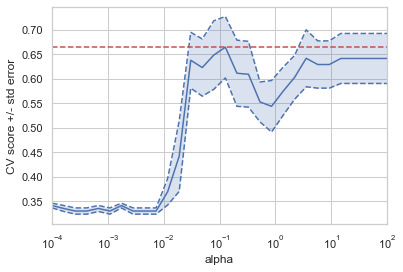

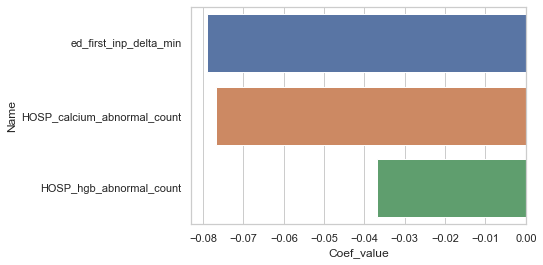

In [139]:
X = dizzy_all_labeled_nm[rf_features]
yy = dizzy_all_labeled_nm['label']
y = np.array([1 if (x=='MOD') else 0 for x in yy])
print(X.shape,y.shape)
clf = tune_model(X,y)
print('Best C = ',clf.best_params_['C'])

logreg, select_feats = build_L1_model(X,y,clf.best_params_['C'])
plt.figure()
visualize_model(logreg,select_feats)